In [9]:
SRC_DIR = '../../src'
DATA_DIR = '/extra/graffc0/fire_prediction/data'
DATA_DIR2 = '/lv_scratch/scratch/graffc0/fire_prediction/data'


# Load system-wide packages
import os
import sys
import functools
from matplotlib import pyplot as plt
import numpy as np
import scipy
from scipy.stats import cumfreq
from scipy.stats.stats import pearsonr
import datetime as dt
import pytz
import seaborn as sb
import xarray as xr
from collections import Counter, defaultdict
from tabulate import tabulate
from matplotlib import gridspec
from IPython.core.display import Image, display
import pandas as pd
import pickle
%matplotlib inline

# Load project packages
src_path = os.path.abspath(os.path.join(SRC_DIR))
if src_path not in sys.path:
    sys.path.append(src_path)

import helper.loaders as load
from helper import date_util as du
from visualization.mapping import make_map
from helper.geometry import get_default_bounding_box
import visualization.mapping as vmap
from helper.geometry import LatLonBoundingBox
import evaluation.evaluate_model as evm
import evaluation.setup_data_structs as setup_ds

import evaluation.metrics as metrics
import evaluation.setup_data_structs as setup_ds
import evaluation.evaluate_model as evm
import evaluation.model_configs as model

In [10]:
# Days to predict
T_K_MAX = 5
T_K_ARR = np.arange(1,T_K_MAX+1)

# Years to use
YEAR_START, YEAR_END = 2007, 2016
YEARS_ARR = np.arange(YEAR_START, YEAR_END+1)

# === DATA FILES ===
land_cover_src = os.path.join(DATA_DIR, 'interim/land_cover/land_cover_alaska.pkl')
weather_proc_region_src = os.path.join(DATA_DIR, 'interim/gfs/weather_proc/4/weather_proc_gfs_4_alaska_2007-2016.pkl')
ignition_cube_src = os.path.join(DATA_DIR, 'interim/modis/fire_cube/fire_ignition_cube_modis_alaska_2007-2016.pkl')
detection_cube_src = os.path.join(DATA_DIR, 'interim/modis/fire_cube/fire_detection_cube_modis_alaska_2007-2016.pkl')

alaska_interior_mask_src = os.path.join(DATA_DIR, 'processed/masks/alaska_interior_mask_05.nc')

integrated_cluster_df_fmt = 'interim/integrated/fire_weather/fire_weather_integrated_gfs_4_modis_5km_10days_forwards_day_cents_1400_%dk_alaska_2007-2016.pkl'
integrated_cluster_df_src_list = map(lambda k: (k, os.path.join(DATA_DIR, integrated_cluster_df_fmt % k)), T_K_ARR)

In [11]:
# === DATA LOADING ===
modis_df = pd.read_pickle(os.path.join(DATA_DIR, 'interim/modis/fire/fire_modis_alaska_2007-2016.pkl'))
cluster_id_5km_10day_df = pd.read_pickle(os.path.join(DATA_DIR, 'interim/modis/fire_cluster/old/fire_cluster_ids_5km_10days_modis_alaska_2007-2016.pkl'))
land_cover = load.load_pickle(land_cover_src)
weather_proc_region = load.load_pickle(weather_proc_region_src)
gfs = pd.read_pickle(os.path.join(DATA_DIR, 'interim/gfs/weather_proc/4/weather_proc_gfs_4_alaska_2007-2016.pkl'))
X_ignition_c, Y_detection_c = evm.setup_ignition_data(ignition_cube_src, detection_cube_src)
alaska_interior_mask = xr.open_dataset(alaska_interior_mask_src)


X_active_df = evm.setup_multiple_active_fire_data(integrated_cluster_df_src_list)

In [12]:
# Add local_time column to modis_df
modis_df = modis_df.assign(datetime_local=list(map(lambda x: du.utc_to_local_time(x[0], x[1], du.round_to_nearest_quarter_hour), zip(modis_df.datetime_utc, modis_df.lon))))

# Add year column to cluste_ids
cluster_id_5km_10day_df['year'] = cluster_id_5km_10day_df.datetime_utc.dt.year

### Temporal distribution of detections (spearated by satellite)

In [14]:
# Helper functions MODIS
def dt_to_hours_frac(dt):
    return dt.hour + (dt.minute / 60.)

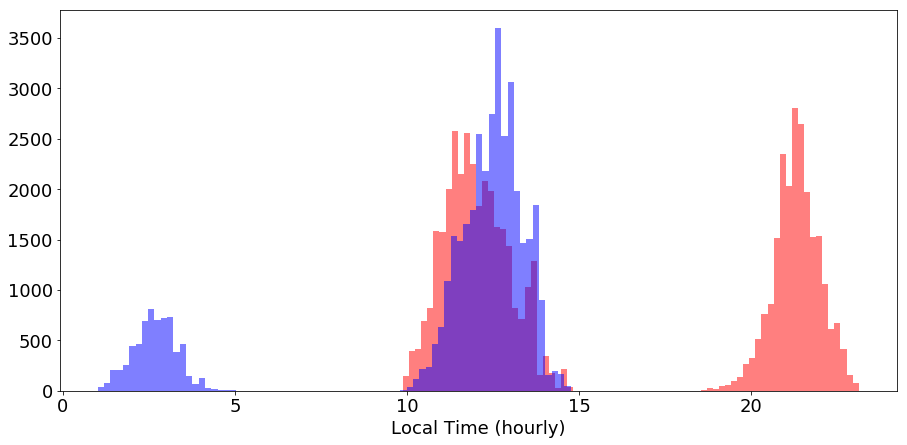

In [52]:
plt.rcParams['figure.figsize'] = [15,7]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

# Plot a histogram of the times of measurements across all of Alaska (Aqua vs Terra)
times_terra = map(dt_to_hours_frac, modis_df[modis_df.sat=='T'].datetime_local)
times_aqua = map(dt_to_hours_frac, modis_df[modis_df.sat=='A'].datetime_local)

_ = plt.hist(times_terra, 75, facecolor='red', alpha=.5)
_ = plt.hist(times_aqua, 75, facecolor='blue', alpha=.5)
#_ = plt.title('Time distribution of fire detections')
_ = plt.xlabel('Local Time (hourly)')

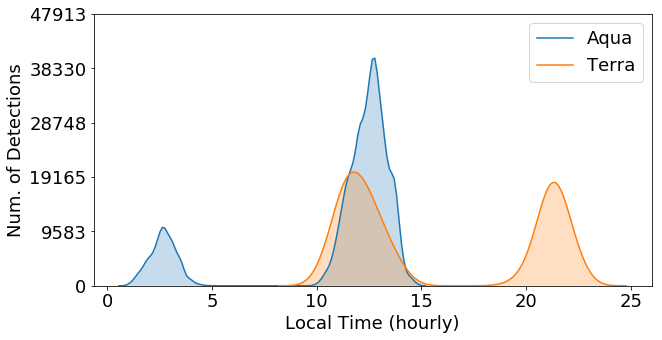

In [17]:
plt.rcParams['figure.figsize'] = [10,5]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)


times_terra = list(map(dt_to_hours_frac, modis_df[modis_df.sat=='T'].datetime_local))
times_aqua = list(map(dt_to_hours_frac, modis_df[modis_df.sat=='A'].datetime_local))

# Plot a KDE of the times of measurements across all of Alaska (Aqua vs Terra)
fig = sb.kdeplot(times_aqua, shade=True, label='Aqua')
sb.kdeplot(times_terra, shade=True, label='Terra')

plt.yticks(fig.get_yticks(), np.round(fig.get_yticks() * len(modis_df)).astype(np.int32))

#_ = plt.title('Time distribution of fire detections')
_ = plt.xlabel('Local Time (hourly)')
_ = plt.ylabel('Num. of Detections')

### Spatial detections plot

In [111]:
lons, lats = mp.makegrid(55, 33) # get lat/lons of ny by nx evenly space grid.
lats2, lons2 = ALASKA_BB.make_grid(inclusive_lon=True)
print(type(lats2), type(lons2))
print(np.all(lats==lats2))
print(np.all(lons==lons2))
print(lats2)
lats2 = np.array(lats2, order='c')

print(lats2)
print(lats)

a = np.zeros((33,55))
mp(lons2,lats2)

print(lats.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
False
True
[[ 71.   71.   71.  ...,  71.   71.   71. ]
 [ 70.5  70.5  70.5 ...,  70.5  70.5  70.5]
 [ 70.   70.   70.  ...,  70.   70.   70. ]
 ..., 
 [ 56.   56.   56.  ...,  56.   56.   56. ]
 [ 55.5  55.5  55.5 ...,  55.5  55.5  55.5]
 [ 55.   55.   55.  ...,  55.   55.   55. ]]
[[ 71.   71.   71.  ...,  71.   71.   71. ]
 [ 70.5  70.5  70.5 ...,  70.5  70.5  70.5]
 [ 70.   70.   70.  ...,  70.   70.   70. ]
 ..., 
 [ 56.   56.   56.  ...,  56.   56.   56. ]
 [ 55.5  55.5  55.5 ...,  55.5  55.5  55.5]
 [ 55.   55.   55.  ...,  55.   55.   55. ]]
[[ 55.          55.          55.         ...,  55.          55.          55.        ]
 [ 55.64531147  55.64531147  55.64531147 ...,  55.64531147  55.64531147
   55.64531147]
 [ 56.2801627   56.2801627   56.2801627  ...,  56.2801627   56.2801627
   56.2801627 ]
 ..., 
 [ 70.24748037  70.24748037  70.24748037 ...,  70.24748037  70.24748037
   70.24748037]
 [ 70.62725378  70.62725378  70.62725378 

/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4979: MatplotlibDeprecationWarning: The is_scalar function was deprecated in version 2.1.
  elif masked and is_scalar(masked):
/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/mpl_toolkits/basemap/_

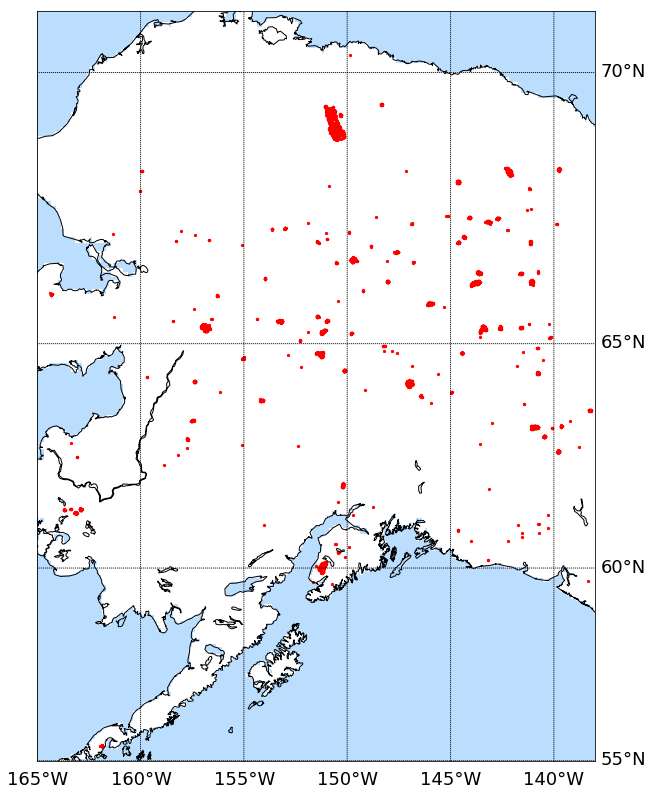

In [46]:
plt.rcParams['figure.figsize'] = [10,15]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

ALASKA_BB = get_default_bounding_box()
YEAR_SEL = 2007

mp = vmap.make_map(ALASKA_BB, (5,0,5,0))
mp.drawlsmask(land_color='w', ocean_color=(30./256,144./256,255./256,.3))


b = np.array(list(map(lambda x: x.year, np.array(modis_df.datetime_local))))==YEAR_SEL
#c = np.array(map(lambda x: x.dayofyear, np.array(modis_df.datetime_local)))==241
#d = np.array(map(lambda x: x.dayofyear, np.array(modis_df.datetime_local)))<241
#b = b & c

sel_df = modis_df[b]
_ = mp.scatter(list(sel_df.lon), list(sel_df.lat), 5, latlon=True, marker='o', color='r')
#_ = plt.title('Detections for %d' % YEAR_SEL)

### Individual cluster plot (with coloring for day of year)

2007-05-01 12:34:00-09:45 2007-09-13 10:46:00-10:00


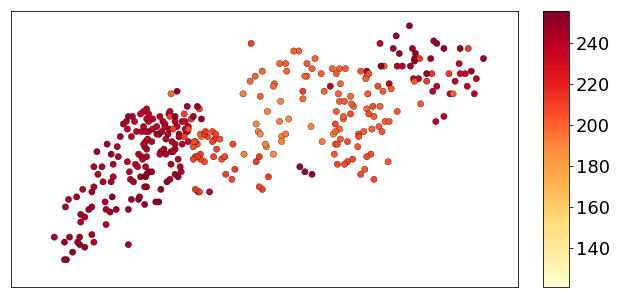

In [428]:
plt.rcParams['figure.figsize'] = [10,15]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

# Plot an indvidual cluster
start = modis_df[b].datetime_local.iloc[0]
end = modis_df[b].datetime_local.iloc[4600]

sel_BB = LatLonBoundingBox(66.15,66.26,-144.05,-143.55)

mp = vmap.make_map(sel_BB, (0,0,0,0))

print start,end
sel_df1 = modis_df[b & (modis_df.datetime_local>=start) & (modis_df.datetime_local<=end)]
dayofyear = sel_df1.datetime_utc.dt.dayofyear
cs = mp.scatter(list(sel_df1.lon), list(sel_df1.lat), 40, latlon=True, edgecolor='black', linewidth='.3', c=dayofyear, cmap='YlOrRd')
cbar = mp.colorbar(cs,location='right',pad="5%")
#_ = plt.title('Detections)

### Unconditional, ignition, and active cell dist.

0.0468084147258
11.1058558559
0.00731729630501


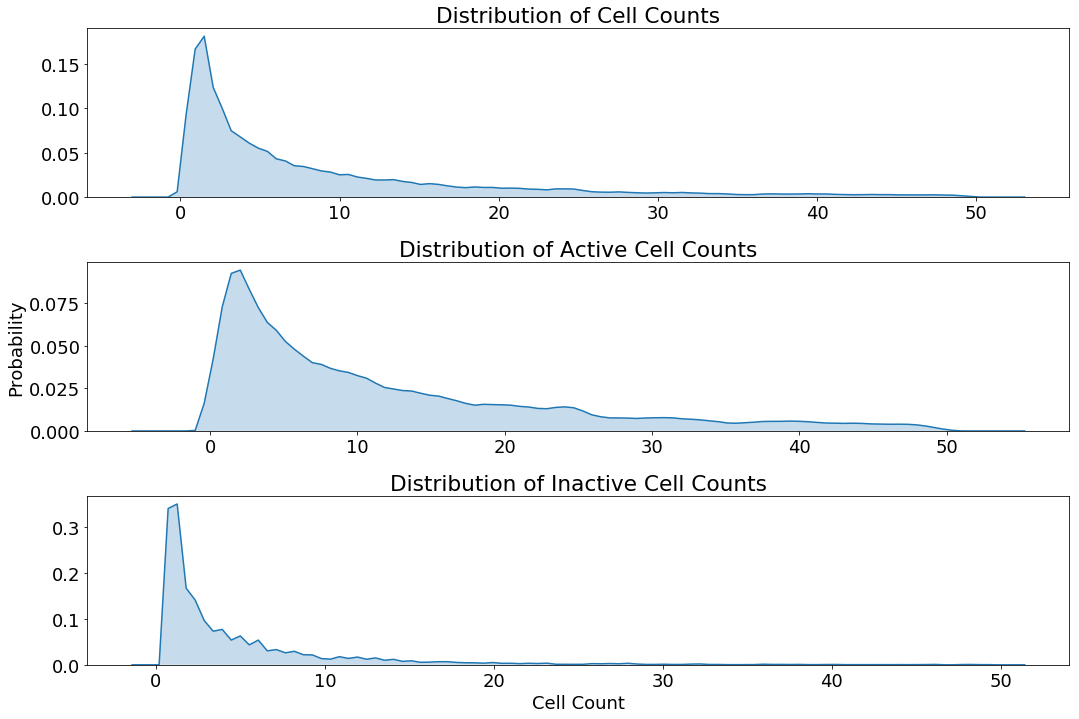

In [435]:
plt.rcParams['figure.figsize'] = [15,10]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

fig = plt.figure()

KERNEL = 'biw'

values = Y_detection_c.values
values_flat = values.flatten()

# Plot a KDE of the unconditional cell counts
ax = fig.add_subplot(311)
ax.set_title("Distribution of Cell Counts")
sb.kdeplot(values_flat, clip=(0,np.max(50)), shade=True, kernel=KERNEL)

#_ = plt.xlabel('Cell Count')
#_ = plt.ylabel('Probability')

# Plot a KDE of the active cell counts
ax = fig.add_subplot(312)
ax.set_title("Distribution of Active Cell Counts")

values_shift = np.concatenate([np.zeros(values.shape[:-1]+(1,)), values[:,:,:-1]], axis=2)
values_active = values[values_shift!=0]

values_active_flat = values_active.flatten()

sb.kdeplot(values_active_flat, clip=(0,np.max(50)), shade=True, kernel=KERNEL)

#_ = plt.xlabel('Cell Count')
_ = plt.ylabel('Probability')


# Plot a KDE of the active cell counts
ax = fig.add_subplot(313)
ax.set_title("Distribution of Inactive Cell Counts")

values_inactive = values[values_shift==0]
values_inactive_flat = values_inactive.flatten()

sb.kdeplot(values_inactive_flat, clip=(0,np.max(50)), shade=True, kernel=KERNEL)

_ = plt.xlabel('Cell Count')
#_ = plt.ylabel('Probability')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


print np.mean(values)
print np.mean(values_active)
print np.mean(values_inactive)

0.0468084147258
11.1058558559
0.00731729630501
1989396
7104


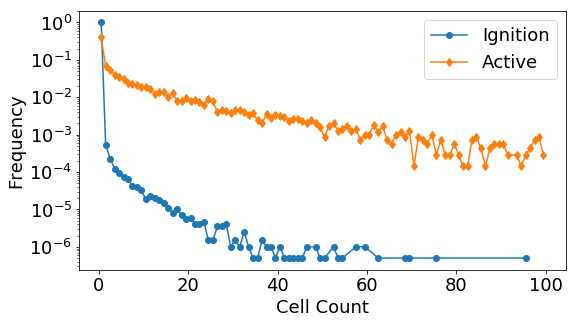

In [48]:
plt.rcParams['figure.figsize'] = [8,4.5]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

BINS = 100

fig = plt.figure()

values = Y_detection_c.values
values_flat = values.flatten()

# Plot a KDE of the unconditional cell counts
#ax = fig.add_subplot(311)
#ax.set_title("Distribution of Cell Counts")
#sb.distplot(values_flat, kde=False, bins=BINS)


#_ = plt.xlabel('Cell Count')
#_ = plt.ylabel('Probability')

# Plot a KDE of the active cell counts
#ax = fig.add_subplot(211)
#ax.set_title("Distribution of Active Cell Counts")




#_ = plt.xlabel('Cell Count')
#_ = plt.ylabel('Probability')

# Plot a KDE of the active cell counts
#ax = fig.add_subplot(212)
#ax.set_title("Distribution of Inactive Cell Counts")

values_inactive = values[values_shift==0]
values_inactive_flat = values_inactive.flatten()

#plt.hist(values_inactive_flat, alpha=.5, bins=BINS//2, normed=True, label='Ignition')

y,binEdges=np.histogram(values_inactive_flat,bins=BINS,density=True,range=(0,100))
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])

bincenters = bincenters[y>0]
y = y[y>0]

plt.semilogy(bincenters,y,'o-', label='Ignition')


values_shift = np.concatenate([np.zeros(values.shape[:-1]+(1,)), values[:,:,:-1]], axis=2)
values_active = values[values_shift!=0]

values_active_flat = values_active.flatten()

#plt.hist(values_active_flat, alpha=.5, bins=BINS, normed=True, label='Active')
y,binEdges=np.histogram(values_active_flat,bins=BINS, density=True,range=(0,100))
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])

bincenters = bincenters[y>0]
y = y[y>0]

plt.semilogy(bincenters,y,'d-', label='Active')

_ = plt.xlabel('Cell Count')
_ = plt.ylabel('Frequency')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

map(lambda x: x.set_yscale('log'), fig.get_axes())
plt.legend()

print( np.mean(values))
print( np.mean(values_active))
print( np.mean(values_inactive))

print(len(values_inactive_flat))
print(len(values_active_flat))

https://stats.stackexchange.com/questions/65866/good-methods-for-density-plots-of-non-negative-variables-in-r

#### Truncate negative values and reweight
#### Estimating density using splines (Kooperberg)

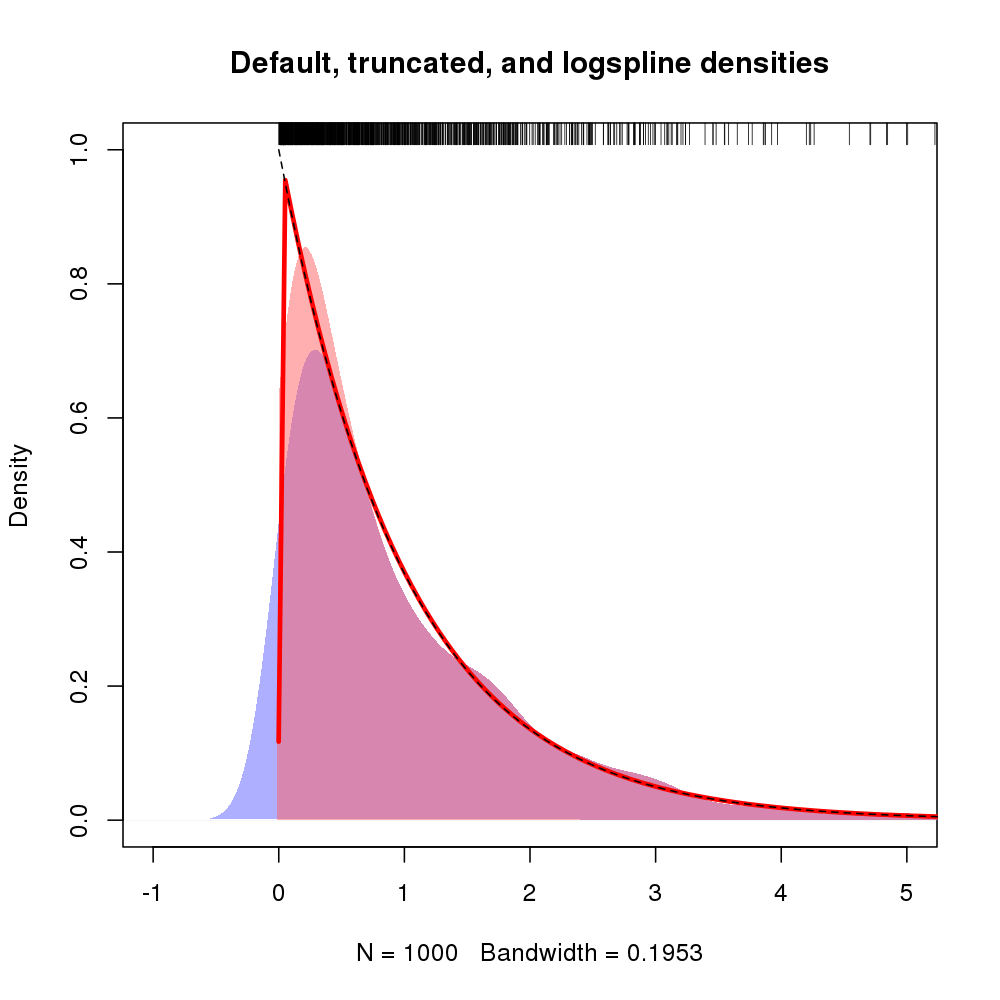

In [441]:
display(Image('https://i.stack.imgur.com/633iI.png', width=500, unconfined=True))

0.0468084147258
11.1058558559
0.00731729630501


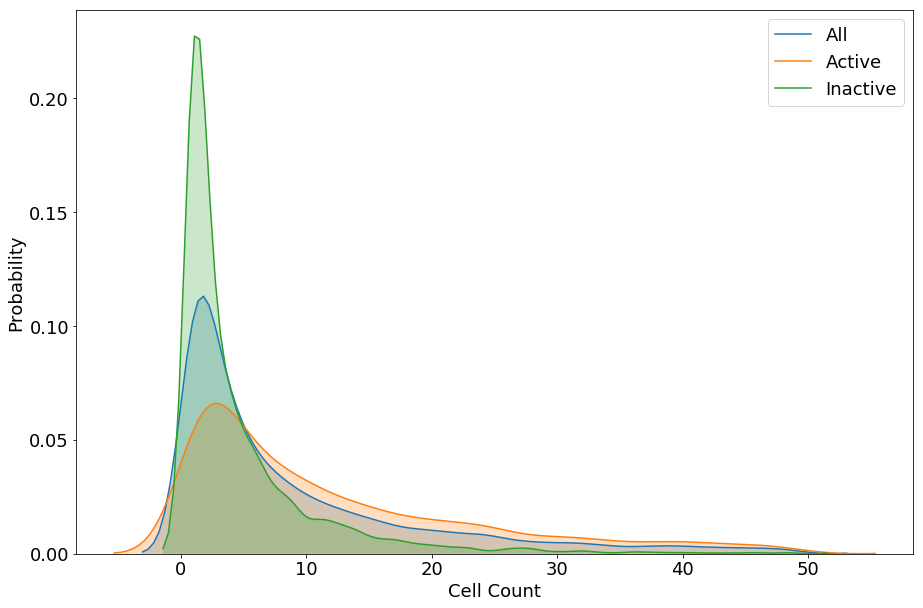

In [443]:
plt.rcParams['figure.figsize'] = [15,10]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

values = Y_detection_c.values
values_flat = values.flatten()

# Plot a KDE of the unconditional cell counts
sb.kdeplot(values_flat, clip=(0,np.max(50)), shade=True, label='All')
_ = plt.xlabel('Cell Count')
_ = plt.ylabel('Probability')
#_ = plt.title('Distribution of Cell Counts')

# Plot a KDE of the active cell counts

values_shift = np.concatenate([np.zeros(values.shape[:-1]+(1,)), values[:,:,:-1]], axis=2)
values_active = values[values_shift!=0]

values_active_flat = values_active.flatten()

sb.kdeplot(values_active_flat, clip=(0,np.max(50)), shade=True, label='Active')

# Plot a KDE of the inactive cell counts
values_inactive = values[values_shift==0]
values_inactive_flat = values_inactive.flatten()

sb.kdeplot(values_inactive_flat, clip=(0,np.max(50)), shade=True, label='Inactive')

print np.mean(values)
print np.mean(values_active)
print np.mean(values_inactive)

### Cluster Size Dist.

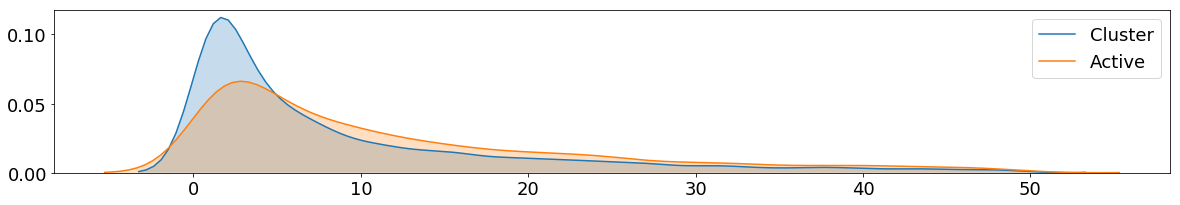

In [296]:
plt.rcParams['figure.figsize'] = [20,3]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

ax.set_title("Distribution of Cluster Counts")
_ = sb.kdeplot(X_active_df[1].num_det, clip=(0,np.max(50)), shade=True, label='Cluster')
sb.kdeplot(values_active_flat, clip=(0,np.max(50)), shade=True, label='Active')

### Cluster lifetimes vs. covariates (blanket plot)

### Summary Statistics

In [79]:
mask = np.zeros(gfs['temperature'].values.shape[0:2], dtype=bool)

lats, lons = weather_proc_region.bounding_box.make_grid(inclusive_lon=True)
for i in range(alaska_interior_mask.mask_Int_05.shape[0]):
    for j in range(alaska_interior_mask.mask_Int_05.shape[1]):
        lat = alaska_interior_mask.Lat_AK_05.values[i,j] + .25
        lon = alaska_interior_mask.Lon_AK_05.values[i,j] - .25

        if alaska_interior_mask.mask_Int_05[i,j] == 1:
            u = np.where(lats[:,0]==lat)[0][0]
            v = np.where(lons[0,:]==lon)[0][0]
            mask[u,v] = 1

/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


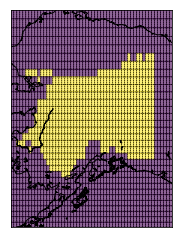

In [67]:
mp = make_map(weather_proc_region.bounding_box, (0, .5, 0, .5))
#mp.shadedrelief()

values = mask
lats, lons = weather_proc_region.bounding_box.make_grid(inclusive_lon=True)

cs = mp.pcolormesh(lons, lats , values, latlon=True, alpha=.6)

In [83]:
num_det = Counter(modis_df.datetime_utc.dt.year)
keys = list(num_det.keys())
keys.sort()

num_det = [num_det[k] for k in keys]
num_clust = list(cluster_id_5km_10day_df.groupby('year').cluster_id.nunique())

# Add climate
years = np.array(list(map(lambda x: x.year, gfs.dates)))
temp = []
humid = []
for year in range(2007, 2016+1):
    vals = gfs['temperature'].filter_dates(dt.datetime(year, 5,14, 0, 0, 0, tzinfo=pytz.UTC), dt.datetime(year, 8,31, 11, 59, 59, tzinfo=pytz.UTC)).values
    temp.append(np.nanmean(vals[mask,:]))
    
    vals = gfs['humidity'].filter_dates(dt.datetime(year, 5,14, 0, 0, 0, tzinfo=pytz.UTC), dt.datetime(year, 8,31, 11, 59, 59, tzinfo=pytz.UTC)).values
    humid.append(np.nanmean(vals[mask,:]))
    
temp_a = list(temp - np.mean(temp))
humid_a = list(humid - np.mean(humid))

# Add means and std dev
num_det += [np.mean(num_det), np.std(num_det)]
num_clust += [np.mean(num_clust), np.std(num_clust)]
#temp += [np.mean(temp), np.std(temp)]
#humid += [np.mean(humid), np.std(humid)]
temp_a += [np.mean(temp), np.std(temp)]
humid_a += [np.mean(humid), np.std(humid)]

# Round values
num_det = list(map(lambda x: round(x), num_det))
num_clust = list(map(lambda x: round(x), num_clust))
#temp = list(map(lambda x: round(x, 1), temp))
#humid = list(map(lambda x: round(x, 1), humid))
temp_a = list(map(lambda x: round(x, 1), temp_a))
humid_a = list(map(lambda x: round(x, 1), humid_a))

# Add row names
num_det = ['Num. of Detections'] + num_det
num_clust = ['Num. of Clusters'] + num_clust
#temp = ['Mean Temp.'] + temp
#humid = ['Mean Humid.'] + humid
temp_a = ['Temp. Anomaly'] + temp_a
humid_a = ['Humid. Anomaly'] + humid_a

headers = keys + ['Mean', 'Std.']
rows = [num_det, num_clust, temp_a, humid_a]

print(tabulate(rows, headers=headers, tablefmt='latex'))

\begin{tabular}{lrrrrrrrrrrrr}
\hline
                    &   2007 &   2008 &    2009 &   2010 &   2011 &   2012 &   2013 &   2014 &    2015 &   2016 &   Mean &    Std. \\
\hline
 Num. of Detections & 5109   &   1077 & 29423   & 7997   & 1658   & 1381   & 9323   & 1273   & 34808   & 3777   & 9583   & 11652   \\
 Num. of Clusters   &  170   &     49 &   168   &  191   &   90   &   74   &  220   &   47   &   401   &  126   &  154   &   100   \\
 Temp. Anomaly      &    0.7 &     -2 &     0.1 &    0.1 &   -0.6 &   -0.3 &    0.7 &   -0.5 &     0.7 &    0.9 &  284.8 &     0.8 \\
 Humid. Anomaly     &   -1.4 &      3 &    -3.9 &    1.3 &    1.7 &    1.7 &   -1.7 &    0.9 &    -2.9 &    1.2 &   68.1 &     2.2 \\
\hline
\end{tabular}


### Topography, land cover, and temp. maps

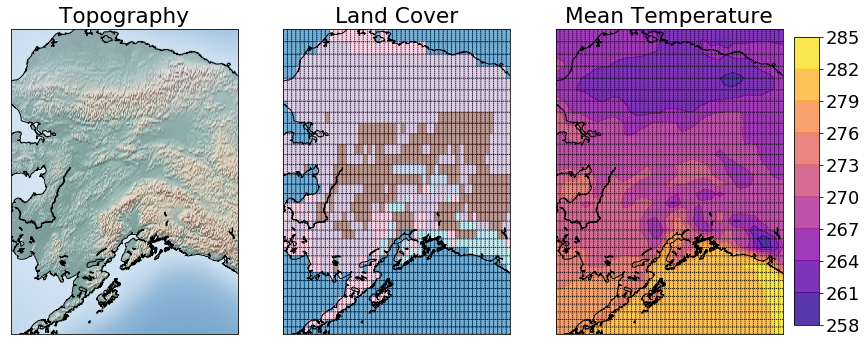

In [478]:
plt.rcParams['figure.figsize'] = [15,25]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

# Plot 1x3 of topography, land cover and temp
BOUNDING_BOX = weather_proc_region.bounding_box 
fig = plt.figure()

# Plot topography
ax = fig.add_subplot(131)
ax.set_title("Topography")
mp = make_map(BOUNDING_BOX, (0,0,0,0))
mp.shadedrelief()

# Plot land cover
ax = fig.add_subplot(132)
ax.set_title("Land Cover")

mp = make_map(BOUNDING_BOX, (0, .5, 0, .5))
#mp.shadedrelief()

values = np.argmax(land_cover, axis=2)
lats, lons = BOUNDING_BOX.make_grid()


cs = mp.pcolormesh(lons, lats , values, latlon=True, alpha=.6, cmap='tab20')
#cbar = mp.colorbar(cs,location='bottom',pad="5%")

# Plot temperature
ax = fig.add_subplot(133)
ax.set_title("Mean Temperature")

DATA_TYPE = 'temperature'   

mp = make_map(gfs[DATA_TYPE].bounding_box,  (0, .5, 0, .5))
#mp.shadedrelief()

values = np.nanmean(gfs['temperature'].values, axis=2)
lats, lons = gfs[DATA_TYPE].bounding_box.make_grid()

cs = mp.contourf(lons, lats , values, latlon=True, alpha=.8, cmap='plasma')
#cbar = mp.colorbar(cs,location='right',pad="5%")

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, .423, 0.023, 0.16])
_ = fig.colorbar(cs, cax=cbar_ax)

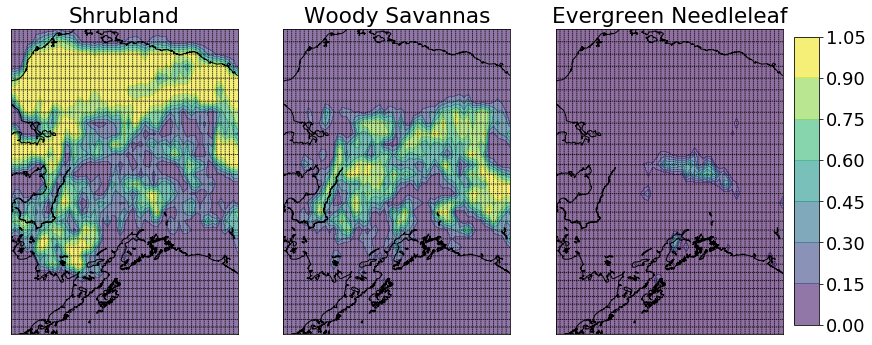

In [35]:
plt.rcParams['figure.figsize'] = [15,25]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

fig = plt.figure()

ax = fig.add_subplot(131)
ax.set_title("Shrubland")

mp = make_map(BOUNDING_BOX, (0, .5, 0, .5))
#mp.shadedrelief()

values = land_cover[:,:,7]/100
lats, lons = BOUNDING_BOX.make_grid()

cs0 = mp.contourf(lons, lats , values, latlon=True, alpha=.6, vmin=0, vmax=1)

ax = fig.add_subplot(132)
ax.set_title("Woody Savannas")
mp = make_map(BOUNDING_BOX, (0, .5, 0, .5))
values = land_cover[:,:,8]/100

cs1 = mp.contourf(lons, lats , values, latlon=True, alpha=.6, vmin=0, vmax=1)

ax = fig.add_subplot(133)
ax.set_title("Evergreen Needleleaf")
mp = make_map(BOUNDING_BOX, (0, .5, 0, .5))
values = land_cover[:,:,1]/100

cs2 = mp.contourf(lons, lats , values, latlon=True, alpha=.6, vmin=0, vmax=1)

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, .423, 0.023, 0.16])
cb = fig.colorbar(cs0, cax=cbar_ax)

### Clustered detections vs. fire boundaries

In [484]:
np.sum(land_cover.reshape(33*55, 17), axis=0)/100

array([  6.66520000e+02,   1.80500000e+01,   0.00000000e+00,
         1.00000000e-02,   1.90000000e-01,   1.22500000e+01,
         0.00000000e+00,   5.87860000e+02,   3.03840000e+02,
         1.97000000e+00,   1.63630000e+02,   8.80000000e-01,
         1.00000000e-02,   6.00000000e-02,   4.40000000e-01,
         5.61800000e+01,   3.11000000e+00])

## === Results & Error Analysis ===

In [92]:
YEARS_TRAIN = [2007,2008,2009,2010, 2011, 2012, 2013, 2014, 2015, 2016]
YEARS_TEST = [2007,2008,2009,2010, 2011, 2012, 2013, 2014, 2015, 2016]
T_K_ARR = np.arange(1,T_K_MAX+1)

y_grid_dict = setup_ds.build_y(Y_detection_c, T_K_ARR, YEARS_TRAIN)
X_active_dict = setup_ds.build_x_active(X_active_df, T_K_ARR, YEARS_TRAIN)
X_grid_dict = setup_ds.build_x_grid(weather_proc_region, Y_detection_c, land_cover, T_K_ARR, 15, 15, [2,5,10], [.25, .5, .75], [5,10,15], YEARS_TRAIN)

T_k=1T_k=2T_k=3T_k=4T_k=5


In [100]:
from importlib import reload
from models import poisson_regression_grid as prg
reload(model)
reload(prg)
# Get results of persistence model
#results_auto_grid, models_auto_grid = evm.evaluate_model_params(model.auto_grid_model, {'None': []}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

# Get results of poisson w/ climate
results_active_only_grid, models_active_only_grid = evm.evaluate_model_params(model.active_only_grid_model_poisson, {'All': ['temperature','humidity','wind','rain']}, X_grid_dict, y_grid_dict, None, T_K_ARR)

# Get results of poisson w/ memory (no climate)
results_active_only_grid_mem, models_active_only_grid_mem = evm.evaluate_model_params(model.active_only_grid_model_poisson, {'Memory' : ['num_det_' + str(i) for i in range(1,10)]}, X_grid_dict, y_grid_dict, None, T_K_ARR)

# Get results of zip w/ memory (no climate)
results_active_grid_all_zip, models_active_grid_all_zip = evm.evaluate_model_params(model.active_only_grid_model_zip, {'Memory' : ['num_det_' + str(i) for i in range(1,10)]}, X_grid_dict, y_grid_dict, None, T_K_ARR)


T_k=1T_k=2T_k=3T_k=4T_k=5
T_k=1T_k=2T_k=3T_k=4T_k=5
T_k=1

/home/graffc/Documents/dev/fire_prediction/src/models/zip_regression_grid.py:66: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  X_df = pd.DataFrame.from_csv(StringIO(X_df.to_csv()))
/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 7.387889
         Iterations: 35
         Function evaluations: 52
         Gradient evaluations: 52


/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


T_k=2

/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 7.128341
         Iterations: 35
         Function evaluations: 52
         Gradient evaluations: 52


/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


T_k=3

/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.043172
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 49


/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


T_k=4

/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 5.329392
         Iterations: 35
         Function evaluations: 53
         Gradient evaluations: 53


/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


T_k=5

/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 4.938655
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 50


/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [110]:
reload(model)
results_active_only_grid_mem_hurdle, models_active_only_grid_mem_hurdle = evm.evaluate_model_params(model.active_only_grid_model_hurdle, {'Memory' : ['num_det_' + str(i) for i in range(1,10)]}, X_grid_dict, y_grid_dict, None, T_K_ARR)


T_k=1

TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

[1, 2, 3, 4, 5]

### Comparison of models using fixed covariates (table w/ skill score)

### Comparison of Poisson and linear regr. (table w/ skill score)

### Comparison of Covariates for best model (table w/ skill score)

### Model coeff. (normalized and unnormalized)

### Simulation of learned coeff.

### Spatial errors

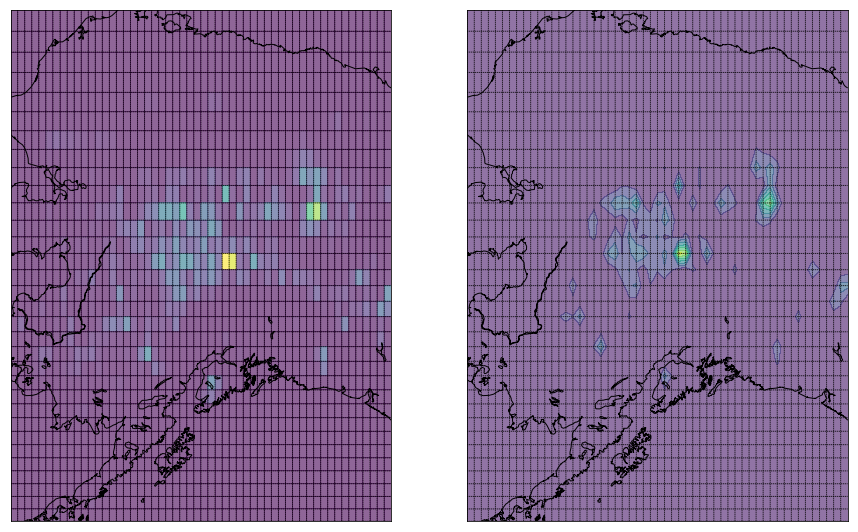

In [57]:
plt.rcParams['figure.figsize'] = [15,10]

ALASKA_BB = get_default_bounding_box()

fig = plt.figure()

ax = fig.add_subplot(121)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))

values = np.mean(Y_detection_c.values, axis=2)
lats, lons = ALASKA_BB.make_grid()

cs = mp.pcolormesh(lons, lats , values, latlon=True, alpha=.6)

ax = fig.add_subplot(122)
mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)

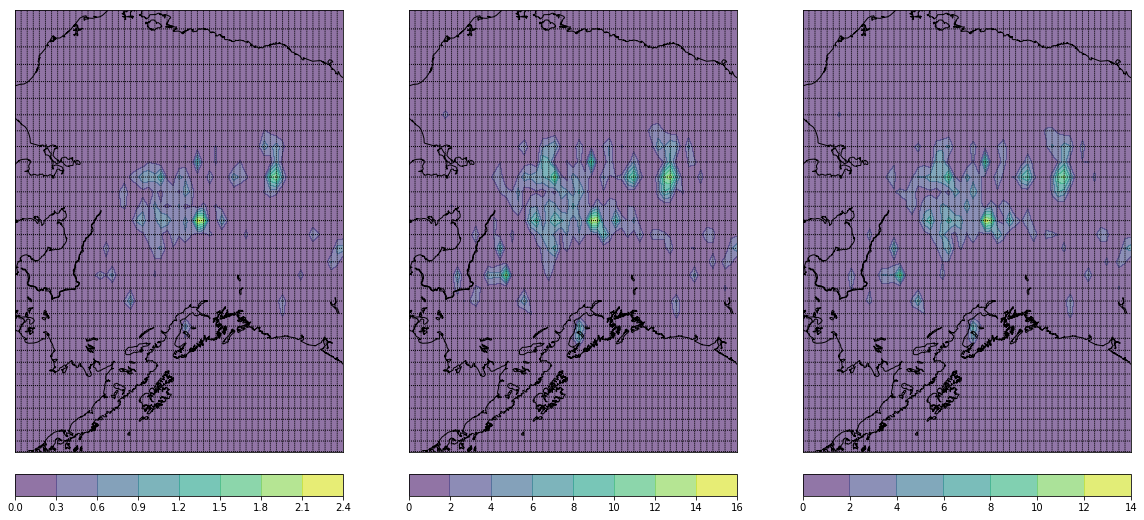

In [58]:
plt.rcParams['figure.figsize'] = [20,10]

ALASKA_BB = get_default_bounding_box()

fig = plt.figure()

# Plot mean counts
ax = fig.add_subplot(131)

values = np.mean(Y_detection_c.values, axis=2)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
lats, lons = ALASKA_BB.make_grid()
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

# Plot RMSE of persistence
ax = fig.add_subplot(132)

metric = metrics.root_mean_squared_error
values = metric(results_auto_grid[1]['None'][0][0], results_auto_grid[1]['None'][0][1], axis=2)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

# Plot RMSE of poisson w/ climate
ax = fig.add_subplot(133)

metric = metrics.root_mean_squared_error
values = metric(results_active_only_grid[1]['All'][0][0], results_active_only_grid[1]['All'][0][1], axis=2)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

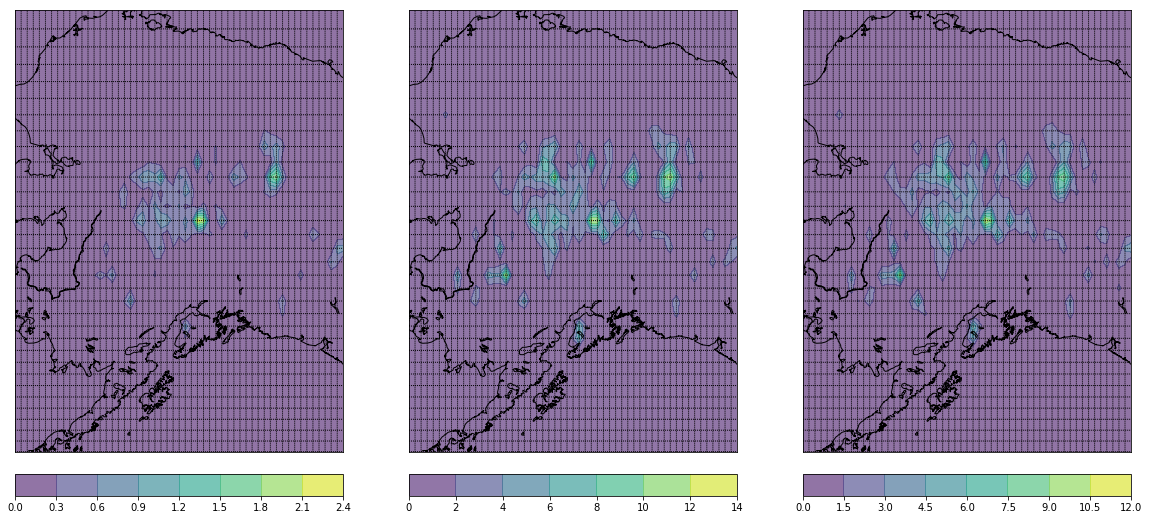

In [59]:
plt.rcParams['figure.figsize'] = [20,10]

ALASKA_BB = get_default_bounding_box()

fig = plt.figure()

# Plot mean counts
ax = fig.add_subplot(131)

values = np.mean(Y_detection_c.values, axis=2)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
lats, lons = ALASKA_BB.make_grid()
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

# Plot RMSE of persistence
ax = fig.add_subplot(132)

metric = metrics.root_mean_squared_error
values = metric(results_auto_grid[1]['None'][0][0], results_auto_grid[1]['None'][0][1], axis=2)
values = values - np.mean(Y_detection_c.values, axis=2)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

# Plot RMSE of poisson w/ climate
ax = fig.add_subplot(133)

metric = metrics.root_mean_squared_error
values = metric(results_active_only_grid[1]['All'][0][0], results_active_only_grid[1]['All'][0][1], axis=2)
values = values - np.mean(Y_detection_c.values, axis=2)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

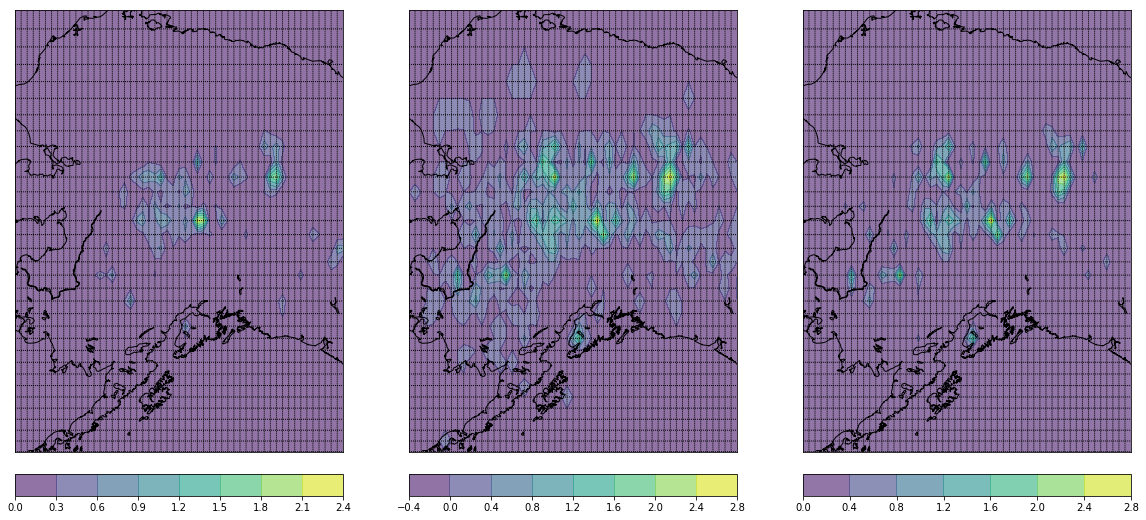

In [60]:
plt.rcParams['figure.figsize'] = [20,10]

ALASKA_BB = get_default_bounding_box()

fig = plt.figure()

# Plot mean counts
ax = fig.add_subplot(131)

values = np.mean(Y_detection_c.values, axis=2)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
lats, lons = ALASKA_BB.make_grid()
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

# Plot RMSE
ax = fig.add_subplot(132)

metric = metrics.root_mean_squared_error
error1 = metric(results_active_only_grid[1]['All'][0][0], results_active_only_grid[1]['All'][0][1], axis=2)
error2 = metric(results_auto_grid[1]['None'][0][0], results_auto_grid[1]['None'][0][1], axis=2)

values = error2 - error1

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

# Plot RMSE
ax = fig.add_subplot(133)

values = np.abs(error2 - error1)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

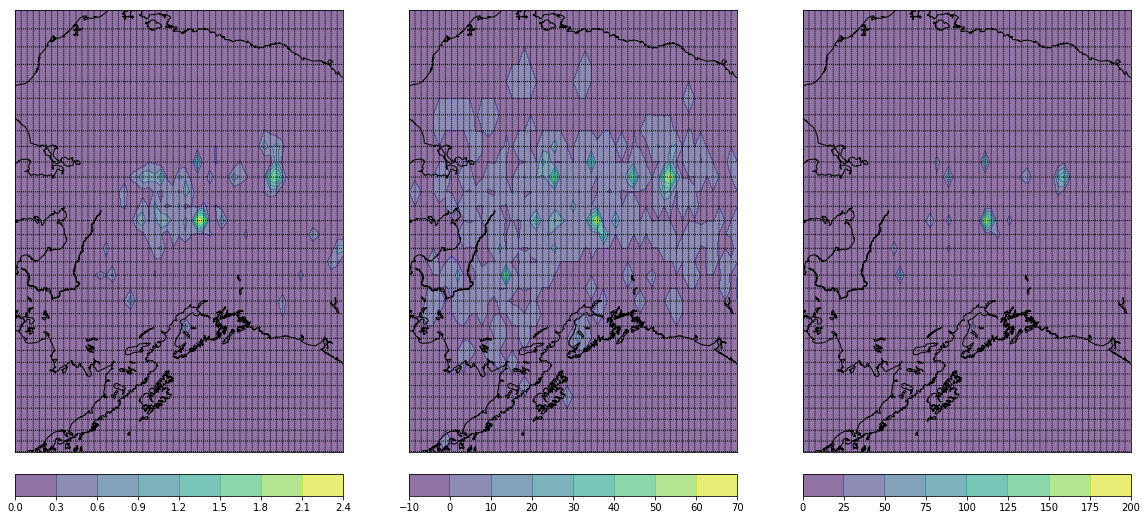

In [63]:
plt.rcParams['figure.figsize'] = [20,10]

ALASKA_BB = get_default_bounding_box()

fig = plt.figure()

# Plot mean counts
ax = fig.add_subplot(131)

values = np.mean(Y_detection_c.values, axis=2)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
lats, lons = ALASKA_BB.make_grid()
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

# Plot RMSE
ax = fig.add_subplot(132)


error1 = np.square(results_active_only_grid[1]['All'][0][1] - results_active_only_grid[1]['All'][0][0])
error2 = np.square(results_auto_grid[1]['None'][0][1] - results_auto_grid[1]['None'][0][0])

values = np.mean(error2 - error1, axis=2)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

# Plot RMSE
ax = fig.add_subplot(133)

values = np.mean(np.abs(error2 - error1), axis=2)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

### Temporal errors

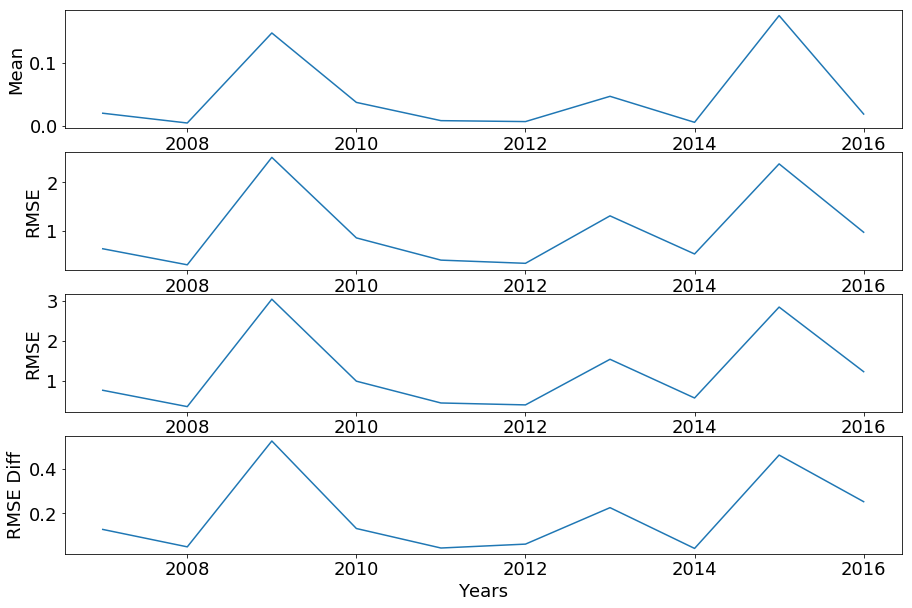

In [108]:
plt.rcParams['figure.figsize'] = [15,10]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

fig = plt.figure()


ax = fig.add_subplot(411)
y_years = np.array(map(lambda x: x.flatten(), np.split(results_active_only_grid[1]['All'][0][0], 10, axis=2)))
_ = plt.plot(range(2007, 2017), np.mean(y_years, axis=1))

_ = plt.ylabel('Mean')

# 1
ax = fig.add_subplot(412)

y_years = np.array(map(lambda x: x.flatten(), np.split(results_active_only_grid[1]['All'][0][0], 10, axis=2)))
y_hat_years = np.array(map(lambda x: x.flatten(), np.split(results_active_only_grid[1]['All'][0][1], 10, axis=2)))

metric1 = metrics.root_mean_squared_error
rmse_years1 = metric(y_years, y_hat_years, axis=1)

_ = plt.plot(range(2007, 2017), rmse_years1)
#_ = plt.xlabel('Years')
_ = plt.ylabel('RMSE')

# 2
ax = fig.add_subplot(413)
y_years = np.array(map(lambda x: x.flatten(), np.split(results_auto_grid[1]['None'][0][0], 10, axis=2)))
y_hat_years = np.array(map(lambda x: x.flatten(), np.split(results_auto_grid[1]['None'][0][1], 10, axis=2)))

metric2 = metrics.root_mean_squared_error
rmse_years2 = metric(y_years, y_hat_years, axis=1)

_ = plt.plot(range(2007, 2017), rmse_years2)
#_ = plt.xlabel('Years')
_ = plt.ylabel('RMSE')

# 3
ax = fig.add_subplot(414)
_ = plt.plot(range(2007, 2017), rmse_years2-rmse_years1)
_ = plt.xlabel('Years')
_ = plt.ylabel('RMSE Diff')

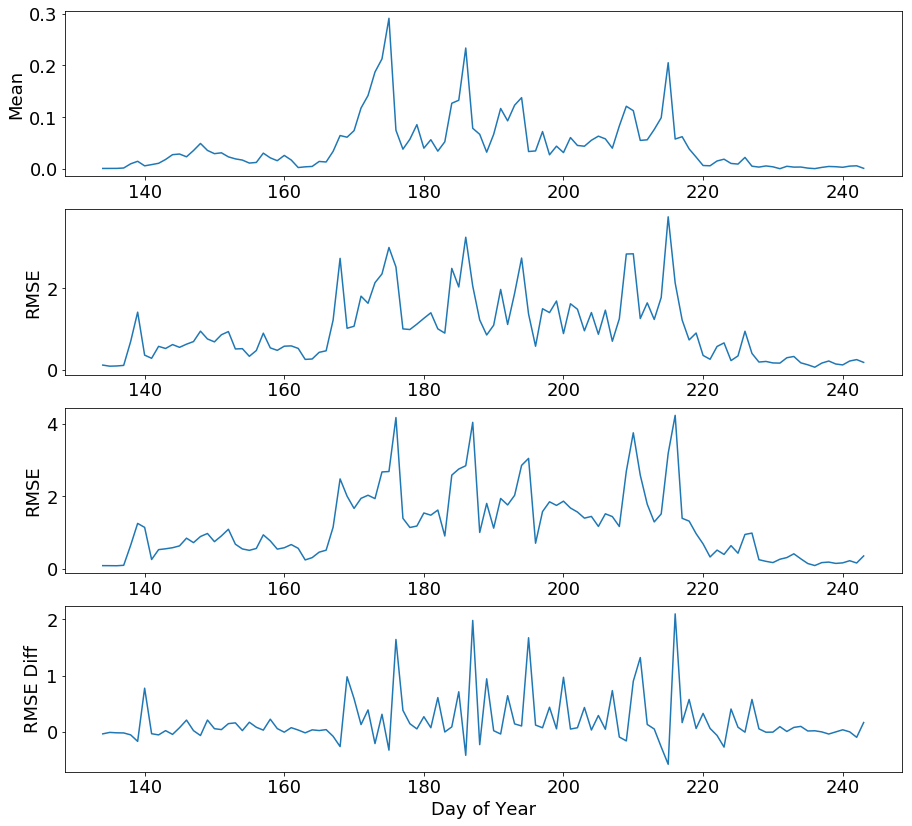

In [109]:
plt.rcParams['figure.figsize'] = [15,14]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

fig = plt.figure()

ax = fig.add_subplot(411)
y_years = np.array(np.split(results_active_only_grid[1]['All'][0][0], 10, axis=2))
y_years = np.reshape(y_years, (10*33*55, 110))

_ = plt.plot(map(lambda x: x.strftime('%j'), Y_detection_c.dates[:110]), np.mean(y_years, axis=0))

_ = plt.ylabel('Mean')


# 1
ax = fig.add_subplot(412)

y_years = np.array(np.split(results_active_only_grid[1]['All'][0][0], 10, axis=2))
y_hat_years = np.array(np.split(results_active_only_grid[1]['All'][0][1], 10, axis=2))

y_years = np.reshape(y_years, (10*33*55, 110))
y_hat_years = np.reshape(y_hat_years, (10*33*55, 110))

metric1 = metrics.root_mean_squared_error
rmse_years1 = metric(y_years, y_hat_years, axis=0)

_ = plt.plot(map(lambda x: x.strftime('%j'), Y_detection_c.dates[:110]), rmse_years1)
#_ = plt.xlabel('Years')
_ = plt.ylabel('RMSE')

# 2
ax = fig.add_subplot(413)
y_years = np.array(np.split(results_auto_grid[1]['None'][0][0], 10, axis=2))
y_hat_years = np.array(np.split(results_auto_grid[1]['None'][0][1], 10, axis=2))

y_years = np.reshape(y_years, (10*33*55, 110))
y_hat_years = np.reshape(y_hat_years, (10*33*55, 110))

metric2 = metrics.root_mean_squared_error
rmse_years2 = metric(y_years, y_hat_years, axis=0)

_ = plt.plot(map(lambda x: x.strftime('%j'), Y_detection_c.dates[:110]), rmse_years2)
#_ = plt.xlabel('Years')
_ = plt.ylabel('RMSE')

# 3
ax = fig.add_subplot(414)
_ = plt.plot(map(lambda x: x.strftime('%j'), Y_detection_c.dates[:110]), rmse_years2-rmse_years1)
_ = plt.xlabel('Day of Year')
_ = plt.ylabel('RMSE Diff')

### Errors by fire size

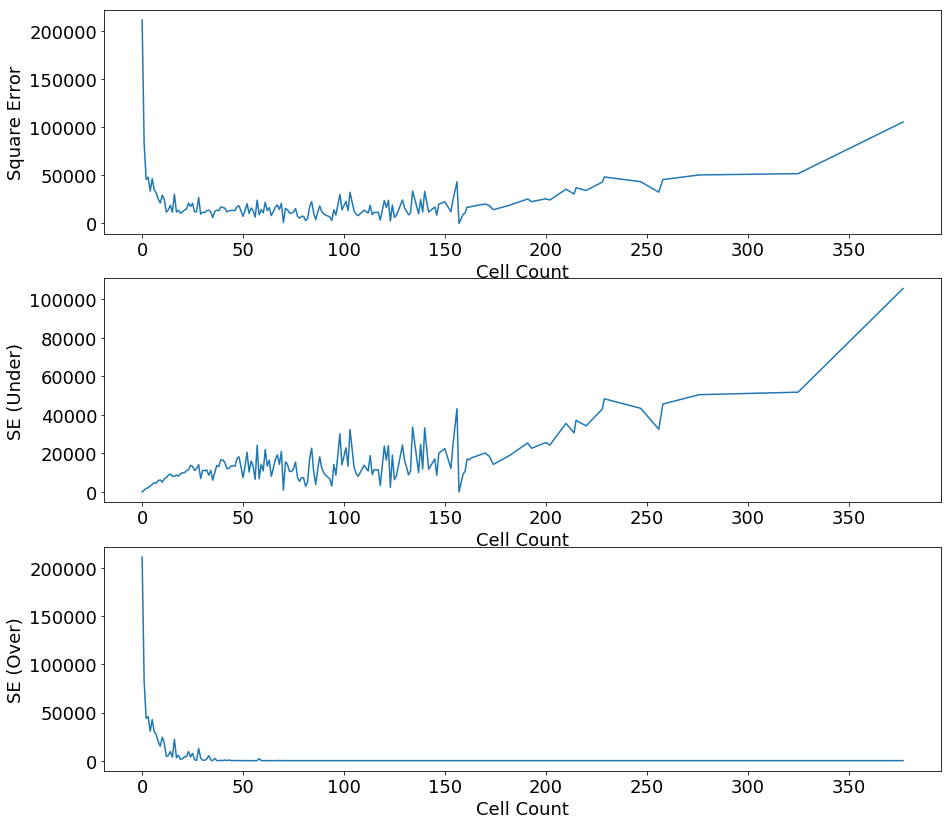

In [182]:
plt.rcParams['figure.figsize'] = [15,14]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

fig = plt.figure()

errors = zip(results_active_only_grid[1]['All'][0][0].flatten(), np.square(results_active_only_grid[1]['All'][0][0].flatten()-results_active_only_grid[1]['All'][0][1].flatten()))
errors2 = zip(results_active_only_grid[1]['All'][0][0].flatten(), results_active_only_grid[1]['All'][0][0].flatten()-results_active_only_grid[1]['All'][0][1].flatten())

d1 = defaultdict(int)
d2 = defaultdict(int)
d3 = defaultdict(int)
d4 = defaultdict(int)


def func(a,b):
    a[b[0]] = a[b[0]] + b[1]
    return a

def func2(a,b):
    a[b[0]] = a[b[0]] + 1
    return a

def func3(a,b):
    if b[1] > 0:
        a[b[0]] = a[b[0]] + np.square(b[1])
    else:
        a[b[0]] = a[b[0]]
    return a

def func4(a,b):
    if b[1] < 0:
        a[b[0]] = a[b[0]] + np.square(b[1])
    else:
        a[b[0]] = a[b[0]]
    return a

results = functools.reduce(func, errors, d1)
results2 = functools.reduce(func2, errors, d2)
results3 = functools.reduce(func3, errors2, d3)
results4 = functools.reduce(func4, errors2, d4)


ax = fig.add_subplot(311)
x = []
y = []
for k,v in results.iteritems():
    x.append(k)
    y.append(v)

_ = plt.plot(x,y)
_ = plt.xlabel('Cell Count')
_ = plt.ylabel('Square Error')

ax = fig.add_subplot(311)



ax = fig.add_subplot(312)

x = []
y = []
for k,v in results3.iteritems():
    x.append(k)
    y.append(v) 

_ = plt.plot(x,y)
_ = plt.xlabel('Cell Count')
_ = plt.ylabel('SE (Under)')

ax = fig.add_subplot(313)

x = []
y = []
for k,v in results4.iteritems():
    x.append(k)
    y.append(v) 

_ = plt.plot(x,y)
_ = plt.xlabel('Cell Count')
_ = plt.ylabel('SE (Over)')

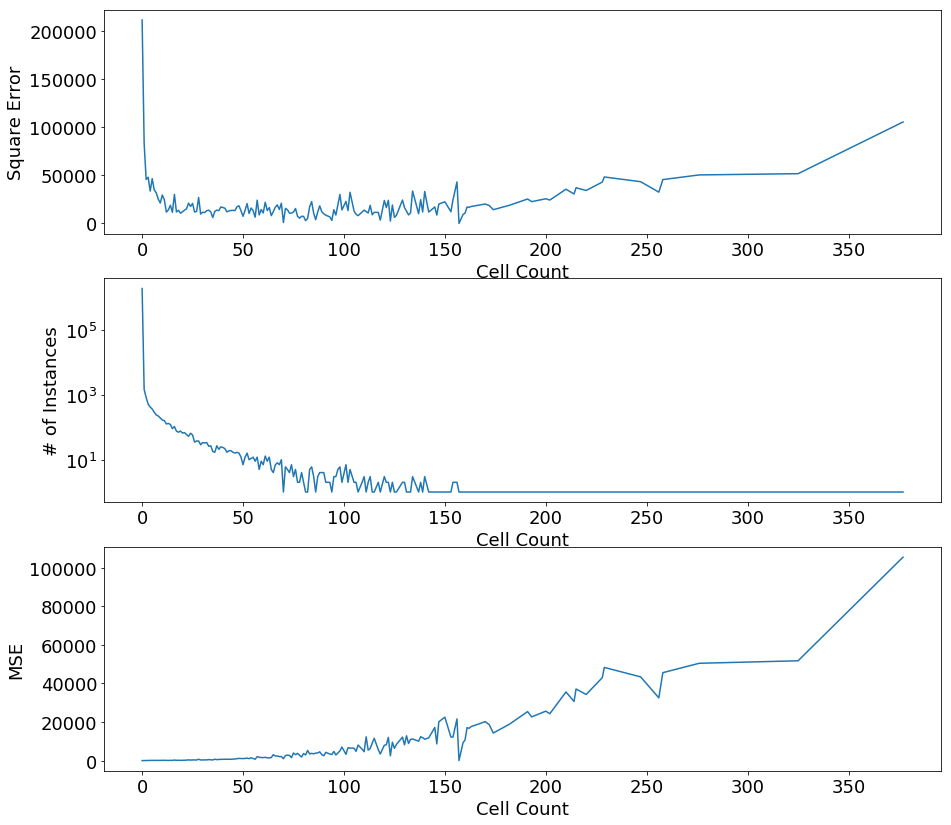

In [181]:
fig = plt.figure()

ax = fig.add_subplot(311)
x = []
y = []
for k,v in results.iteritems():
    x.append(k)
    y.append(v)

_ = plt.plot(x,y)
_ = plt.xlabel('Cell Count')
_ = plt.ylabel('Square Error')


ax = fig.add_subplot(312)
x = []
y = []
for k,v in results2.iteritems():
    x.append(k)
    y.append(v)

_ = plt.semilogy(x,y)
_ = plt.xlabel('Cell Count')
_ = plt.ylabel('# of Instances')


ax = fig.add_subplot(313)
x = []
y = []
for k,v in results.iteritems():
    x.append(k)
    y.append(v/float(results2[k])) 

_ = plt.plot(x,y)
_ = plt.xlabel('Cell Count')
_ = plt.ylabel('MSE')

### Magnitude of Errors

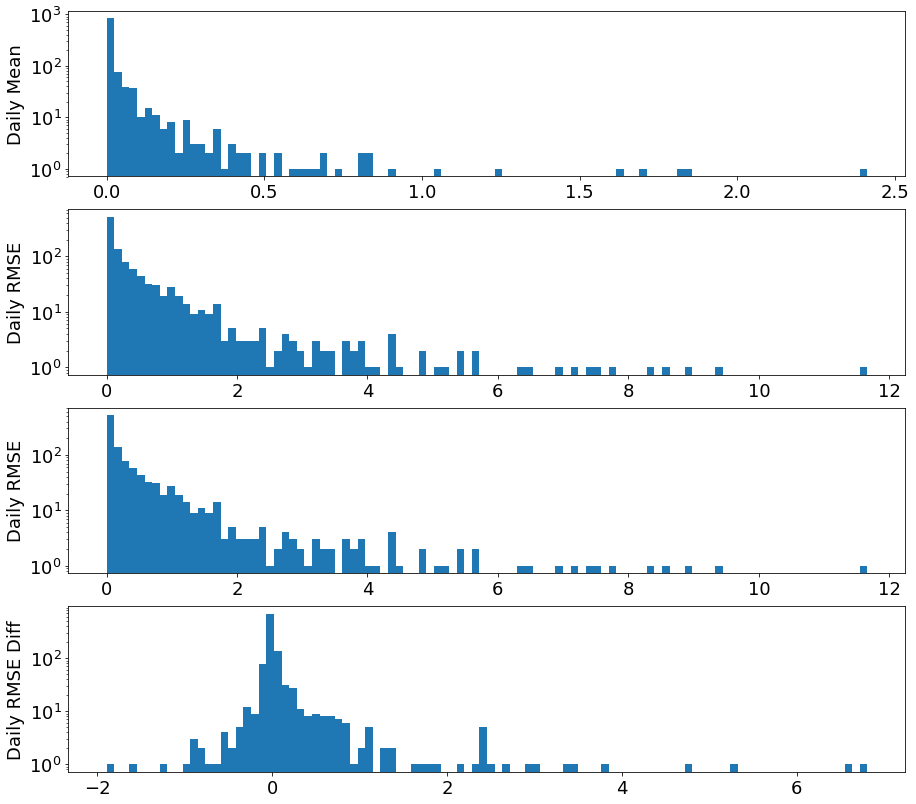

In [132]:
plt.rcParams['figure.figsize'] = [15,14]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

fig = plt.figure()

metric = metrics.root_mean_squared_error

ax = fig.add_subplot(411)
counts = np.mean(results_active_only_grid[1]['All'][0][0].reshape(33*55,1100), axis=0)
_ = plt.hist(counts, bins=100)
_ = plt.ylabel('Daily Mean')
plt.yscale('log', nonposy='clip')


ax = fig.add_subplot(412)
error1 = metric(results_active_only_grid[1]['All'][0][0].reshape(33*55,1100), results_active_only_grid[1]['All'][0][1].reshape(33*55,1100), axis=0)
_ = plt.hist(error1, bins=100)
_ = plt.ylabel('Daily RMSE')
plt.yscale('log', nonposy='clip')


ax = fig.add_subplot(413)

error2 = metric(results_auto_grid[1]['None'][0][0].reshape(33*55,1100), results_auto_grid[1]['None'][0][1].reshape(33*55,1100), axis=0)
_ = plt.hist(error1, bins=100)
_ = plt.ylabel('Daily RMSE')
plt.yscale('log', nonposy='clip')

ax = fig.add_subplot(414)
_ = plt.hist(error2-error1, bins=100)
_ = plt.ylabel('Daily RMSE Diff')
plt.yscale('log', nonposy='clip')



### Expected Change in Counts Between Days

In [42]:
def simulate_day(prev_fires, coeff, random=True, zip_model=False):
    if random:
        if zip_model:
            zip_means = coeff[0]
            coeff = coeff[1]
            
            logit_coeff = coeff[0]
            poisson_coeff = coeff[1]
            
            new = logit_coeff[0]
            new +=  np.sum((np.flip(np.log(np.array(prev_fires)+1),0) - zip_means) * np.array(logit_coeff[1:]))
            
            pi = 1/(1+np.exp(-new))
            
            
            new = poisson_coeff[0]
            new +=  np.sum((np.flip(np.log(np.array(prev_fires)+1),0) - zip_means) * np.array(poisson_coeff[1:]))
            
            lambda_ = np.exp(new)
                        
            is_zero = np.random.binomial(1, 1-pi)
            new = is_zero * np.random.poisson(new)
            
        else:
            new = coeff[0]
            new +=  np.sum(np.flip(np.log(np.array(prev_fires)+1),0) * np.array(coeff[1:]))
            new = np.exp(new)
                
            new = np.random.poisson(new)
            
    return np.concatenate([prev_fires[1:], [new]]), new

def count_zeros(arr, ind):
    count = 0
    for i in range(ind, -1, -1):
        if arr[i] == 0:
            count += 1
        else:
            return count
    return count

def simulate_days(prev_fires, coeff, days, random=True, zero_death=1, zip_model=False):
    cur = prev_fires
    hist = [prev_fires[-1]]
    for day in range(days):
        num_prev_zeros = count_zeros(hist, day)
        if (zero_death > 0) and (num_prev_zeros >= zero_death):
            hist += [0] * (days - day)
            return cur, hist, day-1
        cur,new = simulate_day(cur, coeff, random, zip_model=zip_model)
        hist.append(new)
    return cur, hist, None

def simulate(prev_fires_arr, coeff, days, times, zero_death=1, zip_model=False):
    cur = []
    hist = []
    day_end = np.zeros(days+1)
    for t in range(times):
        prev_fires = prev_fires_arr[t]
        new_cur,new_hist,day = simulate_days(prev_fires, coeff, days, zero_death=zero_death, zip_model=zip_model)
        cur.append(new_cur)
        hist.append(new_hist)
        if day is not None:
            day_end[day+1] += 1
    
    return cur, hist, day_end

In [43]:
zip_params = [[-5.30422653e-01, -9.04580094e-01,  4.79652165e-02,  4.76853541e-02,
       -8.14872031e-02,  9.45073504e-04, -7.38566570e-02, -5.50520473e-02,
        7.93362003e-02, -2.33224917e-02, -3.47471786e-02], [2.58877260e+00,
        4.49447024e-01,  2.28586871e-02, -4.48726441e-03,  1.47596671e-02,
        4.63004902e-02, -2.28040587e-02,  2.04581114e-02, -6.93798034e-02,
        8.48256505e-02,  4.57105462e-02]]

zip_means = [1.97742013, 1.39389888, 1.07652052, 0.87382713, 0.76265957,
 0.69270579, 0.63636549, 0.57127233, 0.5058478,  0.45250233]

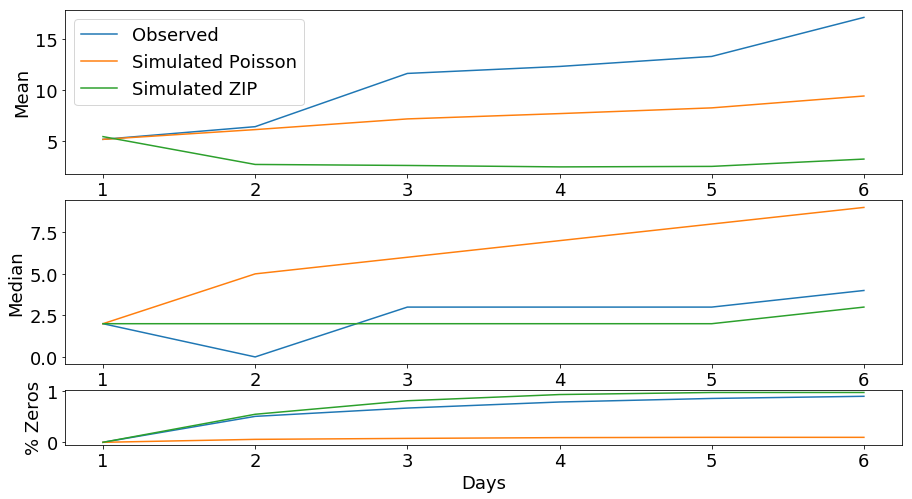

In [594]:
plt.rcParams['figure.figsize'] = [15,8]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)



fig = plt.figure()
gs = gridspec.GridSpec(3,1, height_ratios=[3,3,1])
ax0 = plt.subplot(gs[0])

sel = (X_grid_dict[1][0]['num_det_1'].values==0) & (X_grid_dict[1][0]['num_det'].values!=0)
day1 = X_grid_dict[1][0]['num_det'].values[sel]

# Simulate
#orig = np.zeros(num_hist)
#orig[-1] = 5
days = 6
num_hist = 10
num_trials = len(day1)
num_trials_mult = 3

orig = np.zeros((num_trials, num_hist))
orig[:,-1] = day1
orig[:,-2] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-3] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-4] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-5] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-6] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-7] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-8] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-9] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-10] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig = np.repeat(orig, num_trials_mult, axis=0)
cur, hist0,day_end = simulate(orig, models_active_only_grid_mem['Memory'][0][0][0].params,days-1, num_trials * num_trials_mult, zero_death=1)
hist0 = np.array(hist0)

cur, hist1,day_end2 = simulate(orig, (zip_means, zip_params), days-1, num_trials, zero_death=1, zip_model=True)
hist1 = np.array(hist1)


day1_sim = hist0[np.all(hist0[:,:1] != 0, axis=1), 0]
day1_sim2 = hist1[np.all(hist1[:,:1] != 0, axis=1), 0]

sel = sel
day2 = X_grid_dict[1][0]['num_det_target'].values[sel]
day2_sim = hist0[np.all(hist0[:,:2] != 0, axis=1), 1]
day2_sim2 = hist1[np.all(hist1[:,:2] != 0, axis=1), 1]

sel = sel & (X_grid_dict[1][0]['num_det_target'].values!=0)
day3 = X_grid_dict[2][0]['num_det_target'].values[sel]
day3_sim = hist0[np.all(hist0[:,:3] != 0, axis=1), 2]
day3_sim2 = hist1[np.all(hist1[:,:3] != 0, axis=1), 2]

sel = sel & (X_grid_dict[2][0]['num_det_target'].values!=0)
day4 = X_grid_dict[3][0]['num_det_target'].values[sel]
day4_sim = hist0[np.all(hist0[:,:4] != 0, axis=1), 3]
day4_sim2 = hist1[np.all(hist1[:,:4] != 0, axis=1), 3]

sel = sel & (X_grid_dict[3][0]['num_det_target'].values!=0)
day5 = X_grid_dict[4][0]['num_det_target'].values[sel]
day5_sim = hist0[np.all(hist0[:,:5] != 0, axis=1), 4]
day5_sim2 = hist1[np.all(hist1[:,:5] != 0, axis=1), 4]

sel = sel & (X_grid_dict[4][0]['num_det_target'].values!=0)
day6 = X_grid_dict[5][0]['num_det_target'].values[sel]
day6_sim = hist0[np.all(hist0[:,:6] != 0, axis=1), 5]
day6_sim2 = hist1[np.all(hist1[:,:6] != 0, axis=1), 5]

values = [day1, day2, day3, day4, day5, day6]
values_sim = [day1_sim, day2_sim, day3_sim, day4_sim, day5_sim, day6_sim]
values_sim2 = [day1_sim2, day2_sim2, day3_sim2, day4_sim2, day5_sim2, day6_sim2]

_ = ax0.plot(range(1,days+1), map(np.mean, values), label='Observed')
_ = ax0.plot(range(1,days+1), map(np.mean, values_sim), label='Simulated Poisson')
_ = ax0.plot(range(1,days+1), map(np.mean, values_sim2), label='Simulated ZIP')
_ = ax0.set_ylabel('Mean')
_ = ax0.legend()
#ax0.boxplot(values, sym='')

ax1 = plt.subplot(gs[1], sharex=ax0)
_ = ax1.plot(range(1,days+1), map(np.median, values), label='Observed')
_ = ax1.plot(range(1,days+1), map(np.median, values_sim), label='Simulated Poisson')
_ = ax1.plot(range(1,days+1), map(np.median, values_sim2), label='Simulated ZIP')
_ = ax1.set_ylabel('Median')

ax2 = plt.subplot(gs[2], sharex=ax0)
_ = ax2.plot(range(1,days+1), np.cumsum(map(lambda x: np.sum(x==0)/float(len(day1)), values)))
_ = ax2.plot(range(1,days+1), np.cumsum(day_end)/num_trials)
_ = ax2.plot(range(1,days+1), np.cumsum(day_end2)/num_trials)
_ = ax2.set_ylabel('% Zeros')
_ = ax2.set_xlabel('Days')

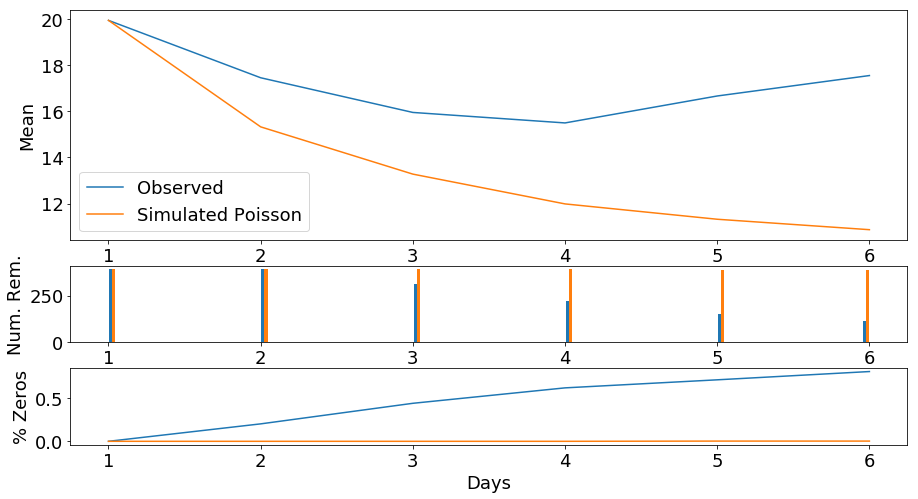

In [137]:
plt.rcParams['figure.figsize'] = [15,8]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

START_VAL_RANGE = [range(10,400)]

fig = plt.figure()
gs = gridspec.GridSpec(3,1, height_ratios=[3,1,1])
ax0 = plt.subplot(gs[0])

sel = (X_grid_dict[1][0]['num_det_1'].values==0) & (X_grid_dict[1][0]['num_det'].values!=0) & (np.isin(X_grid_dict[1][0]['num_det'].values, START_VAL_RANGE))
day1 = X_grid_dict[1][0]['num_det'].values[sel]

# Simulate
#orig = np.zeros(num_hist)
#orig[-1] = 5
days = 6
num_hist = 10
num_trials = len(day1)
num_trials_mult = 3

orig = np.zeros((num_trials, num_hist))
orig[:,-1] = day1
orig[:,-2] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-3] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-4] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-5] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-6] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-7] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-8] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-9] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-10] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig = np.repeat(orig, num_trials_mult, axis=0)
cur, hist0,day_end = simulate(orig, models_active_only_grid_mem['Memory'][0][0].afm.fit_result.params,days-1, num_trials * num_trials_mult, zero_death=1)
hist0 = np.array(hist0)

cur, hist1,day_end2 = simulate(orig, (zip_means, zip_params), days-1, num_trials, zero_death=1, zip_model=True)
hist1 = np.array(hist1)


day1_sim = hist0[np.all(hist0[:,:1] != 0, axis=1), 0]
day1_sim2 = hist1[np.all(hist1[:,:1] != 0, axis=1), 0]

sel = sel
day2 = X_grid_dict[1][0]['num_det_target'].values[sel]
day2_sim = hist0[np.all(hist0[:,:2] != 0, axis=1), 1]
day2_sim2 = hist1[np.all(hist1[:,:2] != 0, axis=1), 1]

sel = sel & (X_grid_dict[1][0]['num_det_target'].values!=0)
day3 = X_grid_dict[2][0]['num_det_target'].values[sel]
day3_sim = hist0[np.all(hist0[:,:3] != 0, axis=1), 2]
day3_sim2 = hist1[np.all(hist1[:,:3] != 0, axis=1), 2]

sel = sel & (X_grid_dict[2][0]['num_det_target'].values!=0)
day4 = X_grid_dict[3][0]['num_det_target'].values[sel]
day4_sim = hist0[np.all(hist0[:,:4] != 0, axis=1), 3]
day4_sim2 = hist1[np.all(hist1[:,:4] != 0, axis=1), 3]

sel = sel & (X_grid_dict[3][0]['num_det_target'].values!=0)
day5 = X_grid_dict[4][0]['num_det_target'].values[sel]
day5_sim = hist0[np.all(hist0[:,:5] != 0, axis=1), 4]
day5_sim2 = hist1[np.all(hist1[:,:5] != 0, axis=1), 4]

sel = sel & (X_grid_dict[4][0]['num_det_target'].values!=0)
day6 = X_grid_dict[5][0]['num_det_target'].values[sel]
day6_sim = hist0[np.all(hist0[:,:6] != 0, axis=1), 5]
day6_sim2 = hist1[np.all(hist1[:,:6] != 0, axis=1), 5]

values = [day1, day2, day3, day4, day5, day6]
values_sim = [day1_sim, day2_sim, day3_sim, day4_sim, day5_sim, day6_sim]
values_sim2 = [day1_sim2, day2_sim2, day3_sim2, day4_sim2, day5_sim2, day6_sim2]

_ = ax0.plot(range(1,days+1), list(map(np.mean, values)), label='Observed')
_ = ax0.plot(range(1,days+1), list(map(np.mean, values_sim)), label='Simulated Poisson')
#_ = ax0.plot(range(1,days+1), list(map(np.mean, values_sim2)), label='Simulated ZIP')
_ = ax0.set_ylabel('Mean')
_ = ax0.legend()
#ax0.boxplot(values, sym='')

ax1 = plt.subplot(gs[1], sharex=ax0)
end_day = []
for i,day in enumerate(values):
    end_day += [i+1]*len(day)
    
end_day_sim = []
for i,day in enumerate(values_sim):
    end_day_sim += [i+1]*(len(day)//3)
    

_ = ax1.hist([end_day, end_day_sim], bins=100)
#_ = ax1.plot(range(1,days+1), np.cumsum(day_end)/num_trials)
#_ = ax1.plot(range(1,days+1), np.cumsum(day_end2)/num_trials)
_ = ax1.set_ylabel('Num. Rem.')
_ = ax1.set_xlabel('Days')

ax2 = plt.subplot(gs[2], sharex=ax0)
_ = ax2.plot(range(1,days+1), np.cumsum(list(map(lambda x: np.sum(x==0)/float(len(day1)), values))))
_ = ax2.plot(range(1,days+1), np.cumsum(day_end)/num_trials)
#_ = ax2.plot(range(1,days+1), np.cumsum(day_end2)/num_trials)
_ = ax2.set_ylabel('% Zeros')
_ = ax2.set_xlabel('Days')

In [42]:
from helper.multidata_wrapper import MultidataWrapper
# Simulate
def simulate_day_new(params, model, random, poisson, hurdle):
    if hurdle:
        pred, rem = model.predict(params, choice='all')
        pi, lam = rem[0]
        if random:
            out = np.random.poisson(lam) * np.random.binomial(1, pi)
            pi = out==0
        else:
            out = pred
            pi = (1-pi)
    elif poisson:
        lam = model.predict(params).values
        if random:
            out = np.random.poisson(lam)
            pi = out==0
        else:
            out = lam            
            pi = scipy.stats.poisson.pmf(0,lam)
            
    else:
        lam = model.predict(params).values
        pi = 0
        out = lam
            
    return out, pi

def simulate_new(params, models, days, random, val_range=None, poisson=True, hurdle=False, start_day=1, filter=True):
    if filter:
        if start_day == 0:
            sel = params[1]['active']
        elif start_day == 1:
            sel = (params[1]['num_det_2'] == 0) & (params[1]['num_det_1'] == 0) & (params[1]['num_det'] != 0) 
        elif start_day == 2:
            sel = (params[1]['num_det_2'] == 0) & (params[1]['num_det_1'] != 0) & (params[1]['num_det'] != 0) 

        if val_range:
            sel &= (np.isin(params[1]['num_det'].values, val_range))

        df = params[1][sel]
    else:
        df = params[1]
    
    pred = [df['num_det'].values]
    zero = [np.zeros(df['num_det'].values.shape)]
    observed = [df['num_det'].values]
    data = [df]
    
    for d in range(1, days+1):
        if filter:
            df = params[d][sel]
        else:
            df = params[d]
        param = MultidataWrapper((df, df))
        
        model = models[d]
        p, z = simulate_day_new(param, model, random, poisson, hurdle)
        pred.append(p)
        zero.append(z)
        observed.append(df['num_det_target'].values)
        data.append(df)
    
    return pred, observed, zero, data

In [45]:
df = X_grid_dict_nw[1]
active = df.num_det!=0
start = (df.num_det_1==0) & (df.num_det_2==0)

start &= (df.num_det_3==0)
sel = df[active & start]
print(sel.temperature_2.mean())


second = (df.num_det_3==0) & (df.num_det_2==0) & (df.num_det_1!=0)
sel = df[second]
print(sel.temperature_1.mean())

NameError: name 'X_grid_dict_nw' is not defined

In [39]:
# Load models
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/241137040635271628013073457540171122769.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
models_persistence = saved['models']
params_persistence = saved['params']

In [6]:
%%capture
# Load models
#fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/318419731866508480593519438194412662304.pkl'
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/119791235995849706822981195996904888530.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
models_poisson = saved['models']
params_poisson = saved['params']

FileNotFoundError: [Errno 2] No such file or directory: '/lv_scratch/scratch/graffc0/fire_prediction/experiments/119791235995849706822981195996904888530.pkl'

In [90]:
%%capture
# Load models
#fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/318419731866508480593519438194412662304.pkl'
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/338482008014467796978758602764805520099.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
models_poisson_large = saved['models']
params_poisson_large = saved['params']

In [40]:
%%capture
# Load models
#fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/185131625028432534302241153293744440089.pkl'
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/190540304654206759166883913704858344042.pkl'

with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
models_hurdle = saved['models']
params_hurdle = saved['params']

In [93]:
# Load data
from importlib import reload
import models
reload(models.regression_models)
from pipeline import train_pipeline 

file_str = '/lv_scratch/scratch/graffc0/fire_prediction/data/processed/grid/grid_ds_gfs_4_modis_alaska_2007-01-01_2016-12-31_integrate_interp_0roff_%dk.nc'
in_files = {k: file_str % k for k in range(1,6)}

start_date = dt.date(2007,1,1)
end_date = dt.date(2016,12,31)

forecast_horizon = 5
params_poisson['memory_covariates']+= ('wind',)
X_grid_dict_nw, y_grid_dict, _, _, _ = train_pipeline.setup_data(in_files, start_date, end_date, forecast_horizon, params_poisson)
X_grid_dict_nw = {k: v[0].to_dataframe() for (k,v) in X_grid_dict_nw.items()}

NameError: name 'params_poisson' is not defined

In [5]:
# Load data
from importlib import reload
import models
reload(models.regression_models)
from pipeline import train_pipeline 

file_str = '/lv_scratch/scratch/graffc0/fire_prediction/data/processed/grid/grid_ds_era_4_modis_alaska_2007-01-01_2016-12-31_interpolate_0roff_%dk.nc'
in_files = {k: file_str % k for k in range(1,6)}

start_date = dt.date(2007,1,1)
end_date = dt.date(2016,12,31)

forecast_horizon = 5
params_poisson['memory_covariates']+= ('wind',)
X_grid_dict_nw_era, y_grid_dict, _, _, _ = train_pipeline.setup_data(in_files, start_date, end_date, forecast_horizon, params_poisson)
X_grid_dict_nw_era = {k: v[0].to_dataframe() for (k,v) in X_grid_dict_nw_era.items()}

NameError: name 'params_poisson' is not defined

In [51]:
def add_count_col(df):
    col = np.arange(len(df))
    df['count_col'] = col
    
    return df

In [50]:
X_grid_dict_nw = {k: add_coundt_col(v) for k,v in X_grid_dict_nw.items()}

NameError: name 'add_count_col' is not defined

In [37]:
LOW = [1,2,3]
HIGH=list(range(10,400))
SEL=None
SEL_ROW = 20901

def sel_func(df):
    return df[df.count_col==SEL_ROW]

#SEL_DF = {k: sel_func(v) for k,v in X_grid_dict_nw.items()}
SEL_DF = X_grid_dict_nw
FILTER = True

In [43]:
# Run models
models_persistence_dict = {k: models_persistence[k-1][0] for k in range(1,6)}
pred_persistence, observed, zero_persistence, data = simulate_new(SEL_DF, models_persistence_dict, 5, False, poisson=False, start_day=1, val_range=SEL, filter=FILTER)

In [44]:
# Run models
models_poisson_dict = {k: models_poisson[k-1][0] for k in range(1,6)}
pred_poisson, observed, zero_poisson, data = simulate_new(SEL_DF, models_poisson_dict, 5, random=False, poisson=True, start_day=1, val_range=SEL, filter=FILTER)

In [91]:
# Run models
models_poisson_large_dict = {k: models_poisson_large[k-1][0] for k in range(1,6)}
pred_poisson_large, observed, zero_poisson_large, data = simulate_new(X_grid_dict_nw_era, models_poisson_large_dict, 5, random=False, poisson=True, start_day=1, val_range=SEL, filter=FILTER)

In [45]:
# Run models
from models import zero_inflated_models
from importlib import reload
reload(zero_inflated_models)
models_hurdle_dict = {k: models_hurdle[k-1][0] for k in range(1,6)}
pred_hurdle, observed, zero_hurdle, data = simulate_new(SEL_DF, models_hurdle_dict, 5, False, hurdle=True, start_day=1, val_range=SEL, filter=FILTER)

g (2, 2364)
ai (2, 2364)
g (1, 2364)
g (2, 2364)
ai (2, 2364)
g (1, 2364)
g (2, 2364)
ai (2, 2364)
g (1, 2364)
g (2, 2364)
ai (2, 2364)
g (1, 2364)
g (2, 2364)
ai (2, 2364)
g (1, 2364)


In [92]:
d = {'Persistence': (pred_persistence, zero_persistence), 'Poisson': (pred_poisson, zero_poisson), 'Poisson Large': (pred_poisson_large, zero_poisson_large)}

In [47]:
def build_df(data, observed):
    vars = ['temperature', 'humidity', 'wind', 'rain']
    df = pd.DataFrame()
    
    for i,o in enumerate(observed):
        df['num_det_%d'%i] = np.array(o)
    
    for v in vars:
        df[v+'_0'] = data[0][v+'_1'].values
    
    for i,d in enumerate(data[1:]):
        for v in vars:
            df[v+'_%d'%(i+1)] = d[v].values 
            
    return df

In [48]:
def add_pred(df, d):
    for k,(pred,zeros) in d.items():
        for i in range(len(pred)):
            df[k+'_pred_%d'%i] = np.array(pred[i])
            df[k+'_zeros_%d'%i] = np.array(zeros[i])
    return df

In [99]:
def build_forecast_dict(df):
    forecast_dict = {}
    for m in ['Persistence', 'Poisson', 'Poisson Large']:
        pred = []
        zero = []
        for i in range(6):
            pred.append(df[m+'_pred_%d'%i])
            zero.append(df[m+'_zeros_%d'%i])

        forecast_dict[m] = (pred, zero)

    observed = []
    for i in range(6):
        observed.append(df['num_det_%d'%i])

    return forecast_dict, observed

In [93]:
df = build_df(data, observed)

In [94]:
df = add_pred(df, d)

/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in long_scalars


ValueError: too many values to unpack (expected 3)

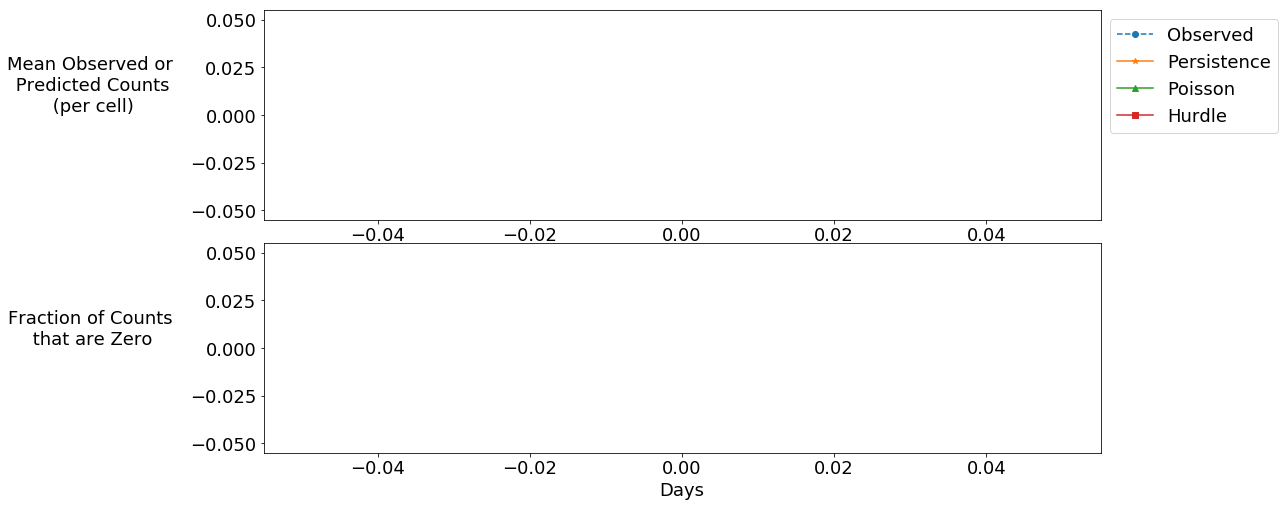

In [54]:
plt.rcParams['figure.figsize'] = [15,15]

i = 2671#2679

df_sel = df.iloc[i:i+1]

data_dict,observed = build_forecast_dict(df_sel)

display_simulation(data_dict,observed, data=df_sel, covars=['Temperature', 'Humidity', 'Wind', 'Rain'], markers=['*', '^', 's'])

In [55]:
# Display simulation
def without_zeros(arr):
    new_arr = [arr[0]]
    for i in range(1, len(arr)):
        ind = arr[i-1]!=0
        new_arr.append(arr[i][ind])
        
    return np.array(new_arr)
def display_simulation(pred_dict, observed, with_zeros=True, data=None, covars=None, covar_means=None, markers=None, label_pad=None):
    x = range(len(observed))
    
    fig = plt.figure()
    if data is not None:
        gs = gridspec.GridSpec(2+len(covars),1, height_ratios=[3,3] + [1]*len(covars))
    else:
        gs = gridspec.GridSpec(2,1, height_ratios=[3,3])

    
    ax0 = plt.subplot(gs[0])
    _ = ax0.set_xlabel('Days')
        
    if with_zeros:
        _ = ax0.set_ylabel('Mean Observed or\n Predicted Counts\n (per cell)', rotation=0, labelpad=100)
        
        ax0.plot(x,list(map(np.mean, observed)), '--o', label='Observed')
        for i,(k,v) in enumerate(pred_dict.items()):
            v,zero = v
            mark = '-'
            if markers is not None:
                mark += markers[i]
            
            ax0.plot(x[1:], list(map(np.mean, v))[1:], mark, label=k)
        
    else:
        _ = ax0.set_ylabel('Counts (w/o Zeros)')    
        observed_without_zeros = without_zeros(observed)
        ax0.plot(x,list(map(np.mean, observed_without_zeros)), '--', label='Observed')
        for k,v in pred_dict.items():
            ax0.plot(x, list(map(np.mean, without_zeros(v))), label=k)
    
    _ = ax0.legend(loc='upper left', bbox_to_anchor=(1, 1))



    ax1 = plt.subplot(gs[1], sharex=ax0)
    _ = ax1.plot(x, list(map(lambda x: np.sum(x==0)/len(x), observed)), '--o')
    for i,(k,v) in enumerate(pred_dict.items()):
        v,zero = v
        mark = '-'
        if markers is not None:
            mark += markers[i]
                
        #_ = ax1.plot(x, list(map(lambda x: np.sum(x==0)/len(x), v)), mark)
        _ = ax1.plot(x[1:], list(map(lambda x: np.mean(x), zero))[1:], mark)

    _ = ax1.set_ylabel('Fraction of Counts\n that are Zero', rotation=0, labelpad=100)
    _ = ax1.set_xlabel('Days')
    
    if data is not None:
        for i,(name,cv,color) in enumerate(covars):
            ax = plt.subplot(gs[2+i], sharex=ax0)
            #v = [np.mean(data[0][cv.lower()+'_1'])] + list(map(lambda x: np.mean(x[cv.lower()]), data[1:]))
            v = [data[cv.lower()+'_%d'%j].mean() for j in range(6)]
            
            
            if covar_means:
                mean = [covar_means[cv]] * len(x)
                diff = np.array(v) - np.array(mean)
                #_ = ax.plot(x, mean, '--+', color='#333333', label='Mean')
                _ = ax.plot(x, diff, '--+', color='#2070b0', label='Mean')
                print(name, mean[0])
            else:
                _ = ax.plot(x, v, '--x', color='#2070b0', label='Observed')
            if label_pad is not None:
                _ = ax.set_ylabel(name, rotation=0, labelpad=label_pad[i])
            else:
                _ = ax.set_ylabel(name, rotation=0, labelpad=max(len(name),9)*9)
            _ = ax.set_xlabel('Days')
            
            # Increase y-scale
            ymin, ymax = plt.ylim()
            y_inc = (ymax-ymin) *.2
            plt.ylim(ymin-y_inc, ymax+y_inc)
            
            #if i == 0:
            #    _ = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [89]:
covars = [('Temp. (K)', 'Temperature', '#e34a33'), ('RH (%)', 'Humidity', '#20874b'), 
 ('Wind (m/s)', 'Wind', '#535353'), ('Precip. (mm)', 'Rain', '#2070b0')]

covar_means = {}
for _,cv,_ in covars:
    mean = X_grid_dict_nw[1][cv.lower()].mean()
    covar_means[cv] = mean


0.0490693739425
0.159898477157
0.461082910321
0.242385786802
0.0875634517766


Text(0.5,1,'Temperature (Day 0 -> 1) -- $\\sigma = 2.64$')

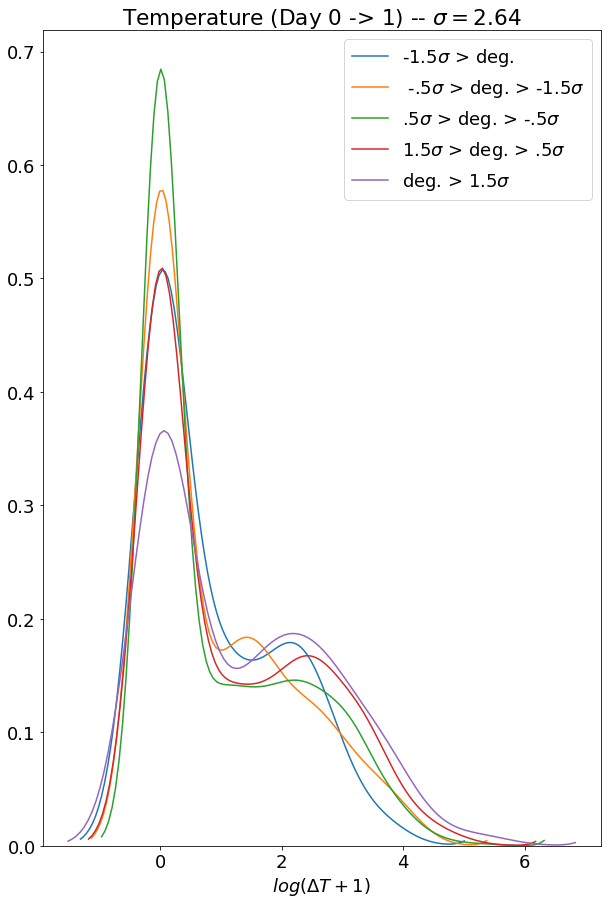

In [205]:
import seaborn as sb

plt.rcParams['figure.figsize'] = [10,15]

temp0 = df['temperature_0']
temp1 = df['temperature_1']
diff = temp1-temp0

sigma = np.std(diff)

OPT = {}


sel = diff < -1.5*sigma
print(np.sum(sel)/len(diff))
sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='-1.5$\sigma$ > deg.')

sel = (-.5*sigma > diff) & (diff > -1.5*sigma)
print(np.sum(sel)/len(diff))
sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label=' -.5$\sigma$ > deg. > -1.5$\sigma$')


sel = (.5*sigma > diff) & (diff > -.5*sigma)
print(np.sum(sel)/len(diff))
sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='.5$\sigma$ > deg. > -.5$\sigma$')

sel = (1.5*sigma > diff) & (diff > .5*sigma)
print(np.sum(sel)/len(diff))
sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='1.5$\sigma$ > deg. > .5$\sigma$')

sel = (diff > 1.5*sigma)
print(np.sum(sel)/len(diff))
sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='deg. > 1.5$\sigma$')

plt.legend()
plt.xlabel('$log(\Delta T + 1)$')
plt.title('Temperature (Day 0 -> 1) -- $\sigma = %.2f$' %sigma)

0.102368866328
0.218274111675
0.476311336717
0.167512690355
0.0355329949239


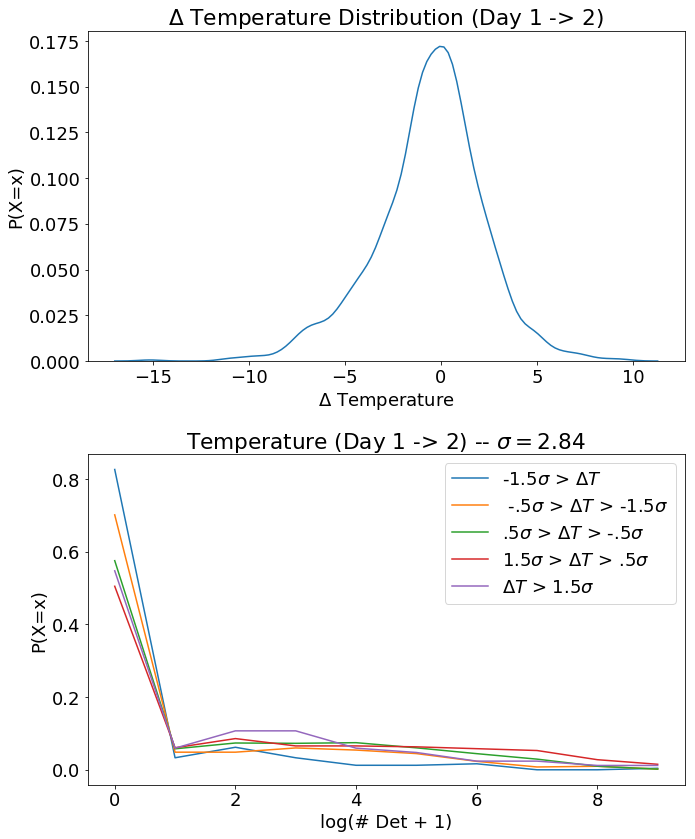

In [345]:
import seaborn as sb

plt.rcParams['figure.figsize'] = [10,12]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

temp0 = df['temperature_1']
temp1 = df['temperature_2']
diff = temp1-temp0

sigma = np.std(diff)

OPT = {'kernel': 'biw'}

fig = plt.figure()

ax = fig.add_subplot(2,1,2)

sel = diff < -1.5*sigma
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='-1.5$\sigma$ > $\Delta T$')
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='-1.5$\sigma$ > deg.')

sel = (-.5*sigma > diff) & (diff > -1.5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label=' -.5$\sigma$ > $\Delta T$ > -1.5$\sigma$')
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label=' -.5$\sigma$ > deg. > -1.5$\sigma$')


sel = (.5*sigma > diff) & (diff > -.5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='.5$\sigma$ > $\Delta T$ > -.5$\sigma$')
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='.5$\sigma$ > deg. > -.5$\sigma$')

sel = (1.5*sigma > diff) & (diff > .5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='1.5$\sigma$ > $\Delta T$ > .5$\sigma$')
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='1.5$\sigma$ > deg. > .5$\sigma$')

sel = (diff > 1.5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='$\Delta T$ > 1.5$\sigma$')
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='deg. > 1.5$\sigma$')

plt.legend()
plt.xlabel('log(# Det + 1)')
plt.ylabel('P(X=x)')
plt.title('Temperature (Day 1 -> 2) -- $\sigma = %.2f$' %sigma)

ax = fig.add_subplot(2,1,1)
sb.kdeplot(diff)

plt.xlabel('$\Delta$ Temperature')
plt.ylabel('P(X=x)')
plt.title('$\Delta$ Temperature Distribution (Day 1 -> 2)')
fig.tight_layout()

0.102368866328
0.218274111675
0.476311336717
0.167512690355
0.0355329949239


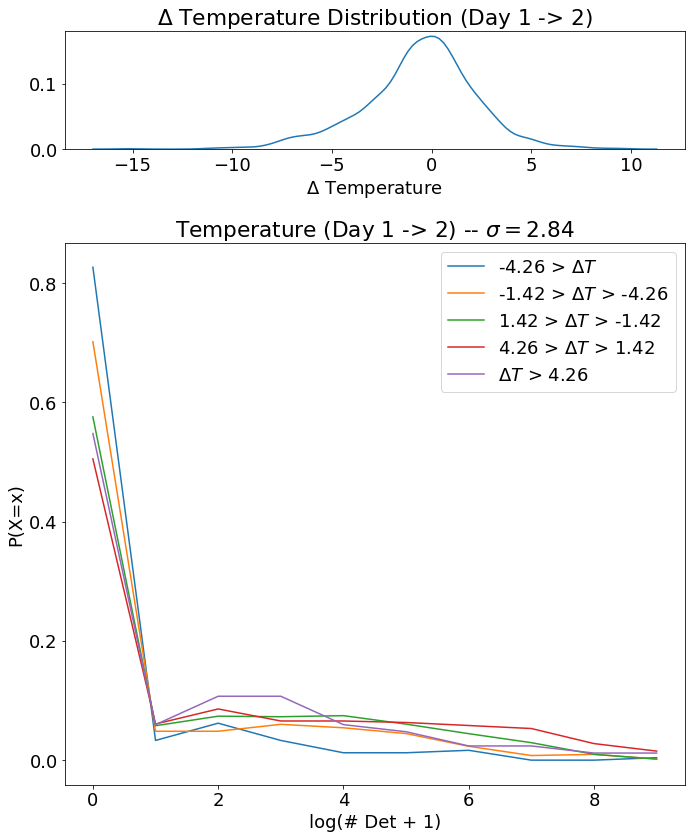

In [349]:
import seaborn as sb

plt.rcParams['figure.figsize'] = [10,12]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

temp0 = df['temperature_1']
temp1 = df['temperature_2']
diff = temp1-temp0

sigma = np.std(diff)

OPT = {'kernel': 'biw'}

fig = plt.figure()
gs = gridspec.GridSpec(4,1)

ax = fig.add_subplot(gs[0, 0])
sb.kdeplot(diff)

plt.xlabel('$\Delta$ Temperature')
plt.title('$\Delta$ Temperature Distribution (Day 1 -> 2)')

ax = fig.add_subplot(gs[1:, 0])

sel = diff < -1.5*sigma
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta T$' % (-1.5*sigma))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='-1.5$\sigma$ > deg.')

sel = (-.5*sigma > diff) & (diff > -1.5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta T$ > %.2f' % (-.5*sigma, -1.5*sigma))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label=' -.5$\sigma$ > deg. > -1.5$\sigma$')


sel = (.5*sigma > diff) & (diff > -.5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta T$ > %.2f' % (.5*sigma, -.5*sigma))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='.5$\sigma$ > deg. > -.5$\sigma$')

sel = (1.5*sigma > diff) & (diff > .5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta T$ > %.2f' %(1.5*sigma, .5*sigma))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='1.5$\sigma$ > deg. > .5$\sigma$')

sel = (diff > 1.5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='$\Delta T$ > %.2f' % (1.5*sigma))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='deg. > 1.5$\sigma$')

plt.legend()
plt.xlabel('log(# Det + 1)')
plt.ylabel('P(X=x)')
plt.title('Temperature (Day 1 -> 2) -- $\sigma = %.2f$' %sigma)

fig.tight_layout()

0.102368866328
0.218274111675
0.476311336717
0.167512690355
0.0355329949239


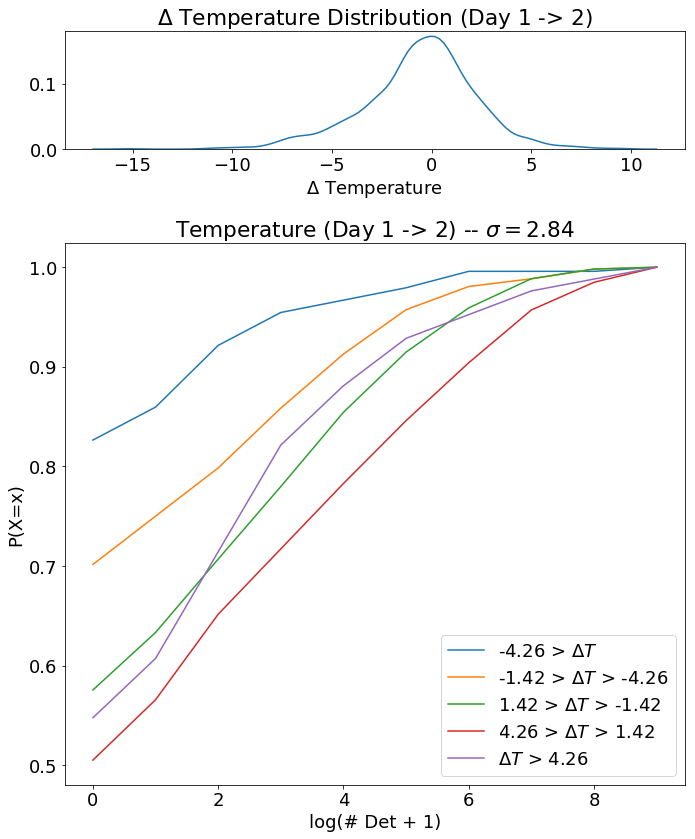

In [359]:
import seaborn as sb

plt.rcParams['figure.figsize'] = [10,12]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

temp0 = df['temperature_1']
temp1 = df['temperature_2']
diff = temp1-temp0

sigma = np.std(diff)

OPT = {'kernel': 'biw'}

fig = plt.figure()
gs = gridspec.GridSpec(4,1)

ax = fig.add_subplot(gs[0, 0])
sb.kdeplot(diff)

plt.xlabel('$\Delta$ Temperature')
plt.title('$\Delta$ Temperature Distribution (Day 1 -> 2)')

ax = fig.add_subplot(gs[1:, 0])

sel = diff < -1.5*sigma
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
hist = np.cumsum(hist)/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta T$' % (-1.5*sigma))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='-1.5$\sigma$ > deg.')

sel = (-.5*sigma > diff) & (diff > -1.5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
hist = np.cumsum(hist)/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta T$ > %.2f' % (-.5*sigma, -1.5*sigma))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label=' -.5$\sigma$ > deg. > -1.5$\sigma$')


sel = (.5*sigma > diff) & (diff > -.5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
hist = np.cumsum(hist)/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta T$ > %.2f' % (.5*sigma, -.5*sigma))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='.5$\sigma$ > deg. > -.5$\sigma$')

sel = (1.5*sigma > diff) & (diff > .5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
hist = np.cumsum(hist)/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta T$ > %.2f' %(1.5*sigma, .5*sigma))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='1.5$\sigma$ > deg. > .5$\sigma$')

sel = (diff > 1.5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
hist = np.cumsum(hist)/np.sum(hist)
plt.plot(hist, label='$\Delta T$ > %.2f' % (1.5*sigma))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='deg. > 1.5$\sigma$')

plt.legend()
plt.xlabel('log(# Det + 1)')
plt.ylabel('P(X=x)')
plt.title('Temperature (Day 1 -> 2) -- $\sigma = %.2f$' %sigma)

fig.tight_layout()

0.198815566836
0.18062605753
0.195008460237
0.189509306261
0.194162436548


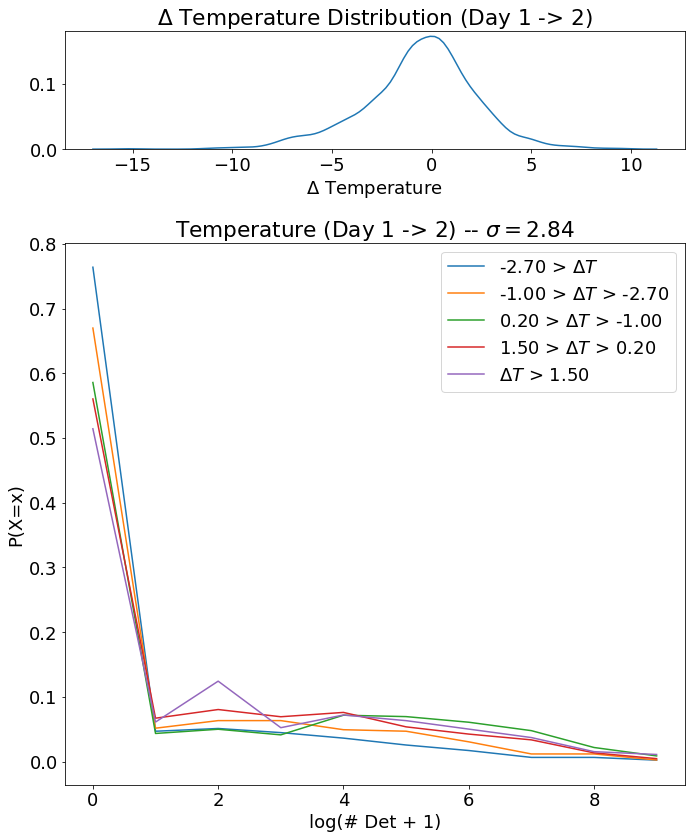

In [358]:
import seaborn as sb

plt.rcParams['figure.figsize'] = [10,12]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

temp0 = df['temperature_1']
temp1 = df['temperature_2']
diff = temp1-temp0

sigma = np.std(diff)

OPT = {'kernel': 'biw'}

fig = plt.figure()
gs = gridspec.GridSpec(4,1)

ax = fig.add_subplot(gs[0, 0])
sb.kdeplot(diff)

plt.xlabel('$\Delta$ Temperature')
plt.title('$\Delta$ Temperature Distribution (Day 1 -> 2)')

ax = fig.add_subplot(gs[1:, 0])

quantiles = scipy.stats.mstats.mquantiles(diff, [.2, .4, .6, .8])

sel = diff < quantiles[0]
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta T$' % (quantiles[0]))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='-1.5$\sigma$ > deg.')

sel = (quantiles[1] > diff) & (diff > quantiles[0])
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta T$ > %.2f' % (quantiles[1], quantiles[0]))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label=' -.5$\sigma$ > deg. > -1.5$\sigma$')


sel = (quantiles[2] > diff) & (diff > quantiles[1])
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta T$ > %.2f' % (quantiles[2], quantiles[1]))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='.5$\sigma$ > deg. > -.5$\sigma$')

sel = (quantiles[3] > diff) & (diff > quantiles[2])
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta T$ > %.2f' %(quantiles[3], quantiles[2]))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='1.5$\sigma$ > deg. > .5$\sigma$')

sel = (diff > quantiles[3])
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='$\Delta T$ > %.2f' % (quantiles[3]))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='deg. > 1.5$\sigma$')

plt.legend()
plt.xlabel('log(# Det + 1)')
plt.ylabel('P(X=x)')
plt.title('Temperature (Day 1 -> 2) -- $\sigma = %.2f$' %sigma)

fig.tight_layout()

0.0368020304569
0.141285956007
0.491962774958
0.227157360406
0.102791878173


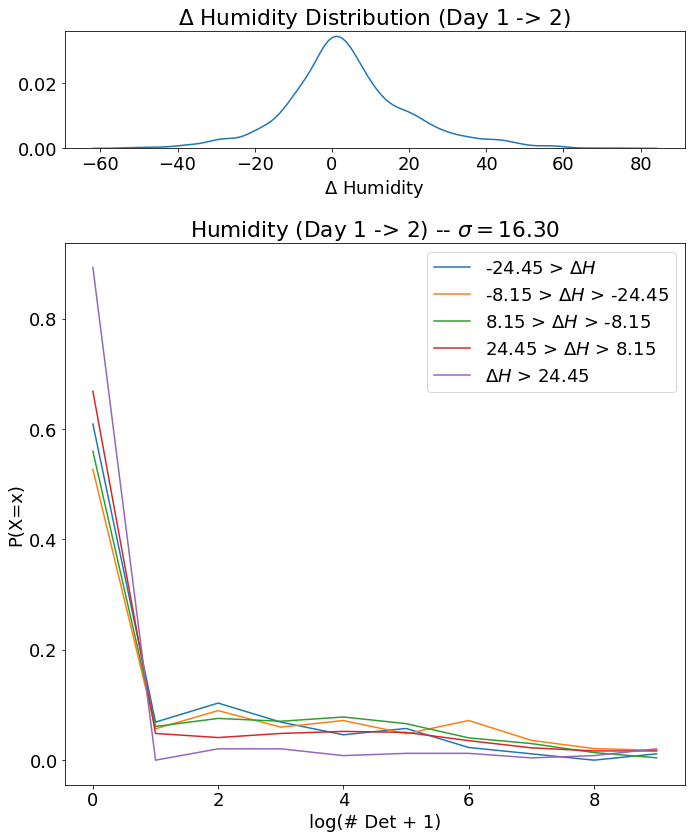

In [353]:
import seaborn as sb

plt.rcParams['figure.figsize'] = [10,12]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

temp0 = df['humidity_1']
temp1 = df['humidity_2']
diff = temp1-temp0

sigma = np.std(diff)

OPT = {'kernel': 'biw'}

fig = plt.figure()
gs = gridspec.GridSpec(4,1)

ax = fig.add_subplot(gs[0, 0])
sb.kdeplot(diff)

plt.xlabel('$\Delta$ Humidity')
plt.title('$\Delta$ Humidity Distribution (Day 1 -> 2)')

ax = fig.add_subplot(gs[1:, 0])

sel = diff < -1.5*sigma
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta H$' % (-1.5*sigma))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='-1.5$\sigma$ > deg.')

sel = (-.5*sigma > diff) & (diff > -1.5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta H$ > %.2f' % (-.5*sigma, -1.5*sigma))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label=' -.5$\sigma$ > deg. > -1.5$\sigma$')


sel = (.5*sigma > diff) & (diff > -.5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta H$ > %.2f' % (.5*sigma, -.5*sigma))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='.5$\sigma$ > deg. > -.5$\sigma$')

sel = (1.5*sigma > diff) & (diff > .5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta H$ > %.2f' %(1.5*sigma, .5*sigma))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='1.5$\sigma$ > deg. > .5$\sigma$')

sel = (diff > 1.5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='$\Delta H$ > %.2f' % (1.5*sigma))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='deg. > 1.5$\sigma$')

plt.legend()
plt.xlabel('log(# Det + 1)')
plt.ylabel('P(X=x)')
plt.title('Humidity (Day 1 -> 2) -- $\sigma = %.2f$' %sigma)

fig.tight_layout()

0.0368020304569
0.141285956007
0.491962774958
0.227157360406
0.102791878173


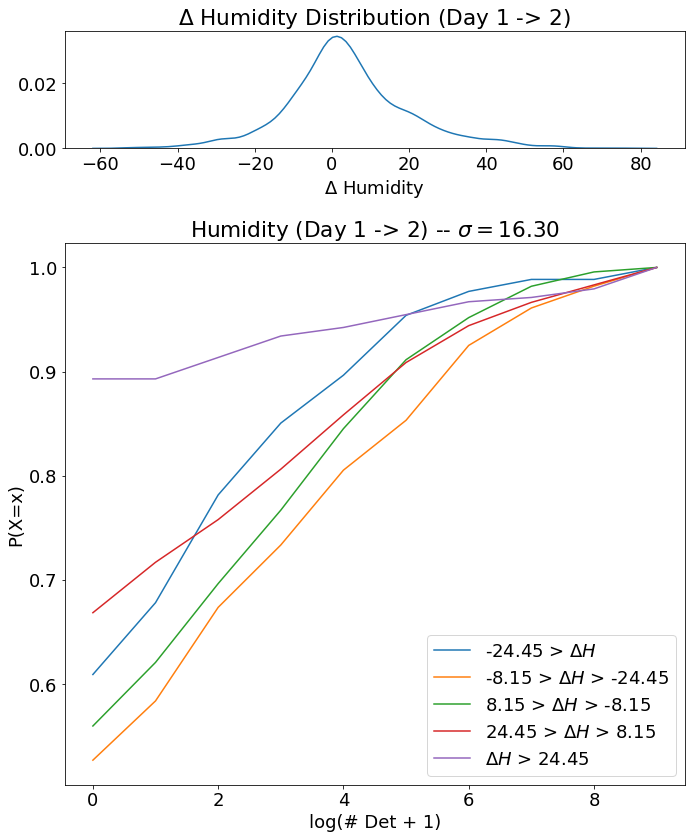

In [360]:
import seaborn as sb

plt.rcParams['figure.figsize'] = [10,12]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

temp0 = df['humidity_1']
temp1 = df['humidity_2']
diff = temp1-temp0

sigma = np.std(diff)

OPT = {'kernel': 'biw'}

fig = plt.figure()
gs = gridspec.GridSpec(4,1)

ax = fig.add_subplot(gs[0, 0])
sb.kdeplot(diff)

plt.xlabel('$\Delta$ Humidity')
plt.title('$\Delta$ Humidity Distribution (Day 1 -> 2)')

ax = fig.add_subplot(gs[1:, 0])

sel = diff < -1.5*sigma
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
hist = np.cumsum(hist)/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta H$' % (-1.5*sigma))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='-1.5$\sigma$ > deg.')

sel = (-.5*sigma > diff) & (diff > -1.5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
hist = np.cumsum(hist)/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta H$ > %.2f' % (-.5*sigma, -1.5*sigma))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label=' -.5$\sigma$ > deg. > -1.5$\sigma$')


sel = (.5*sigma > diff) & (diff > -.5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
hist = np.cumsum(hist)/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta H$ > %.2f' % (.5*sigma, -.5*sigma))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='.5$\sigma$ > deg. > -.5$\sigma$')

sel = (1.5*sigma > diff) & (diff > .5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
hist = np.cumsum(hist)/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta H$ > %.2f' %(1.5*sigma, .5*sigma))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='1.5$\sigma$ > deg. > .5$\sigma$')

sel = (diff > 1.5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
hist = np.cumsum(hist)/np.sum(hist)
plt.plot(hist, label='$\Delta H$ > %.2f' % (1.5*sigma))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='deg. > 1.5$\sigma$')

plt.legend()
plt.xlabel('log(# Det + 1)')
plt.ylabel('P(X=x)')
plt.title('Humidity (Day 1 -> 2) -- $\sigma = %.2f$' %sigma)

fig.tight_layout()

0.197969543147
0.198815566836
0.191624365482
0.200084602369
0.200084602369


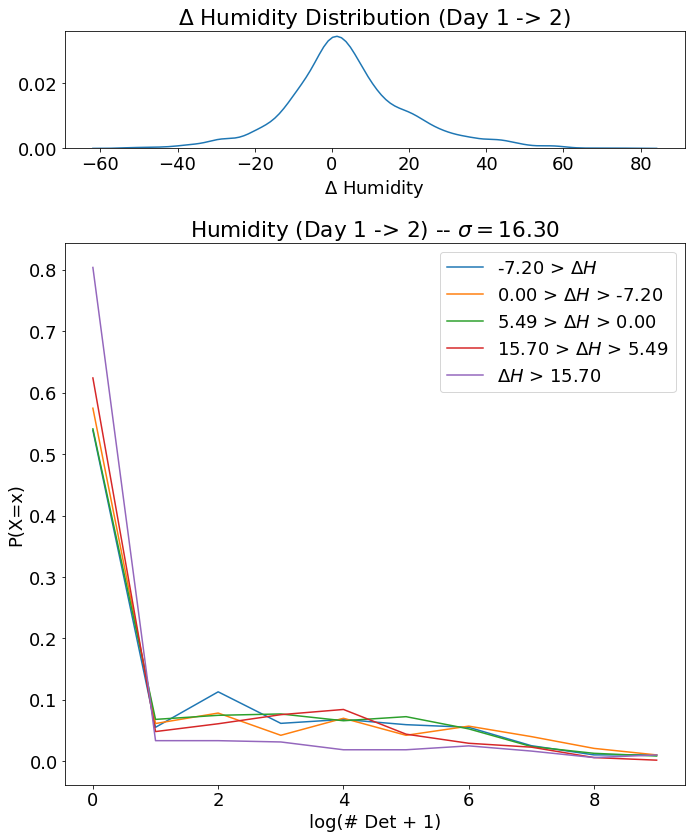

In [357]:
import seaborn as sb

plt.rcParams['figure.figsize'] = [10,12]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

temp0 = df['humidity_1']
temp1 = df['humidity_2']
diff = temp1-temp0

sigma = np.std(diff)

OPT = {'kernel': 'biw'}

fig = plt.figure()
gs = gridspec.GridSpec(4,1)

ax = fig.add_subplot(gs[0, 0])
sb.kdeplot(diff)

plt.xlabel('$\Delta$ Humidity')
plt.title('$\Delta$ Humidity Distribution (Day 1 -> 2)')

ax = fig.add_subplot(gs[1:, 0])

quantiles = scipy.stats.mstats.mquantiles(diff, [.2, .4, .6, .8])

sel = diff < quantiles[0]
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta H$' % (quantiles[0]))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='-1.5$\sigma$ > deg.')

sel = (quantiles[1] > diff) & (diff > quantiles[0])
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta H$ > %.2f' % (quantiles[1], quantiles[0]))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label=' -.5$\sigma$ > deg. > -1.5$\sigma$')


sel = (quantiles[2] > diff) & (diff > quantiles[1])
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta H$ > %.2f' % (quantiles[2], quantiles[1]))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='.5$\sigma$ > deg. > -.5$\sigma$')

sel = (quantiles[3] > diff) & (diff > quantiles[2])
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='%.2f > $\Delta H$ > %.2f' %(quantiles[3], quantiles[2]))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='1.5$\sigma$ > deg. > .5$\sigma$')

sel = (diff > quantiles[3])
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
#hist = np.cumsum(hist)/np.sum(hist)
hist = hist/np.sum(hist)
plt.plot(hist, label='$\Delta H$ > %.2f' % (quantiles[3]))
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='deg. > 1.5$\sigma$')

plt.legend()
plt.xlabel('log(# Det + 1)')
plt.ylabel('P(X=x)')
plt.title('Humidity (Day 1 -> 2) -- $\sigma = %.2f$' %sigma)

fig.tight_layout()

0.0368020304569
0.141285956007
0.491962774958
0.227157360406
0.102791878173


Text(0.5,1,'Humidity (Day 1 -> 2) -- $\\sigma = 16.30$')

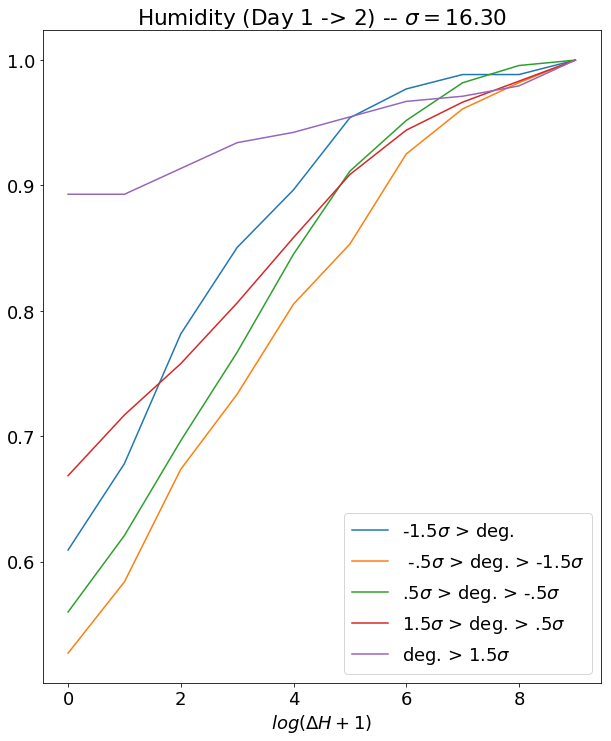

In [229]:
import seaborn as sb

plt.rcParams['figure.figsize'] = [10,12]

temp0 = df['humidity_1']
temp1 = df['humidity_2']
diff = temp1-temp0

sigma = np.std(diff)

OPT = {'kernel': 'biw'}


sel = diff < -1.5*sigma
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
hist = np.cumsum(hist)/np.sum(hist)
plt.plot(hist, label='-1.5$\sigma$ > deg.')
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='-1.5$\sigma$ > deg.')

sel = (-.5*sigma > diff) & (diff > -1.5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
hist = np.cumsum(hist)/np.sum(hist)
plt.plot(hist, label=' -.5$\sigma$ > deg. > -1.5$\sigma$')
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label=' -.5$\sigma$ > deg. > -1.5$\sigma$')


sel = (.5*sigma > diff) & (diff > -.5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
hist = np.cumsum(hist)/np.sum(hist)
plt.plot(hist, label='.5$\sigma$ > deg. > -.5$\sigma$')
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='.5$\sigma$ > deg. > -.5$\sigma$')

sel = (1.5*sigma > diff) & (diff > .5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
hist = np.cumsum(hist)/np.sum(hist)
plt.plot(hist, label='1.5$\sigma$ > deg. > .5$\sigma$')
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='1.5$\sigma$ > deg. > .5$\sigma$')

sel = (diff > 1.5*sigma)
print(np.sum(sel)/len(diff))
hist,bins = np.histogram(np.log(df['num_det_2'][sel]+1), density=True)
hist = np.cumsum(hist)/np.sum(hist)
plt.plot(hist, label='deg. > 1.5$\sigma$')
#sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='deg. > 1.5$\sigma$')

plt.legend()
plt.xlabel('$log(\Delta H + 1)$')
plt.title('Humidity (Day 1 -> 2) -- $\sigma = %.2f$' %sigma)

0.0368020304569
H 22      0.000000
24      0.000000
96      3.178054
125     3.688879
128     0.693147
180     0.000000
195     1.945910
201     1.386294
208     2.302585
237     0.000000
238     0.000000
240     1.609438
249     0.000000
260     0.000000
264     0.000000
307     0.000000
320     0.000000
325     0.000000
333     1.609438
339     0.693147
340     1.609438
341     0.000000
342     2.772589
392     0.000000
393     0.000000
433     0.000000
455     0.000000
456     0.000000
458     0.000000
549     0.693147
          ...   
1111    0.000000
1140    0.000000
1141    2.484907
1171    0.000000
1210    0.000000
1213    0.000000
1216    0.000000
1299    0.000000
1390    2.302585
1396    0.000000
1435    0.693147
1547    0.000000
1555    3.178054
1556    3.218876
1704    2.079442
1751    2.708050
1755    2.397895
1834    2.708050
1836    2.302585
1838    2.708050
1839    2.484907
1841    2.197225
1904    2.890372
1965    0.000000
1966    0.000000
1967    0.000000
1968    0.000

/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:353: RuntimeWarning: divide by zero encountered in true_divide
  k = (X.T - grid[:, None])/bw  # uses broadcasting to make a gridsize x nobs
/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:353: RuntimeWarning: invalid value encountered in true_divide
  k = (X.T - grid[:, None])/bw  # uses broadcasting to make a gridsize x nobs
/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:361: RuntimeWarning: invalid value encountered in less
  domain_mask = (k < z_lo) | (k > z_high)
/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:361: RuntimeWarning: invalid value encountered in greater
  domain_mask = (k < z_lo) | (k > z_high)
/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:367: RuntimeWarning: i

Text(0.5,1,'Humidity (Day 0 -> 1) -- $\\sigma = 16.30$')

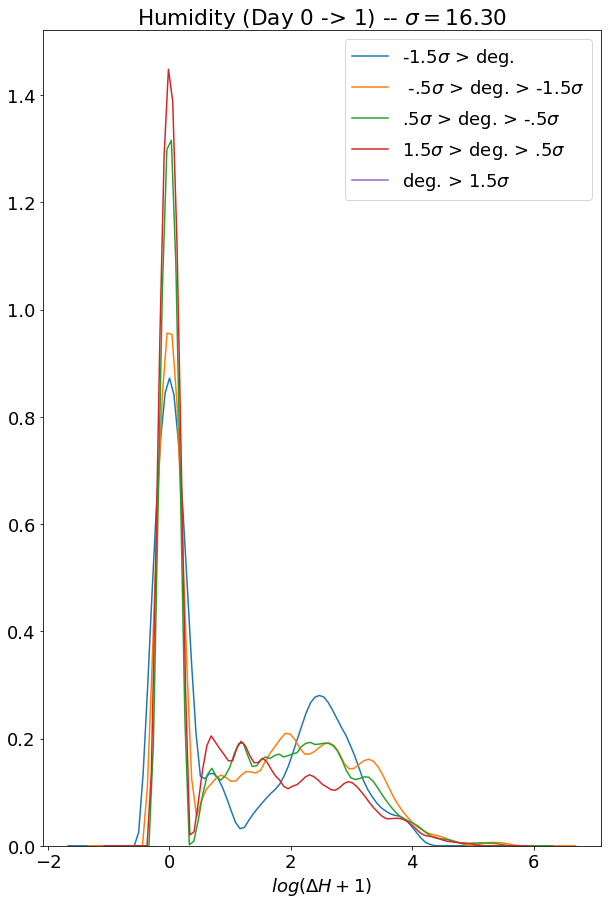

In [226]:
import seaborn as sb

plt.rcParams['figure.figsize'] = [10,15]

temp0 = df['humidity_1']
temp1 = df['humidity_2']
diff = temp1-temp0

sigma = np.std(diff)

OPT = {'kernel': 'biw'}


sel = diff < -1.5*sigma
print(np.sum(sel)/len(diff))
sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='-1.5$\sigma$ > deg.')
print('H',np.log(df['num_det_1'][sel]+1))

sel = (-.5*sigma > diff) & (diff > -1.5*sigma)
print(np.sum(sel)/len(diff))
sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label=' -.5$\sigma$ > deg. > -1.5$\sigma$')


sel = (.5*sigma > diff) & (diff > -.5*sigma)
print(np.sum(sel)/len(diff))
sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='.5$\sigma$ > deg. > -.5$\sigma$')

sel = (1.5*sigma > diff) & (diff > .5*sigma)
print(np.sum(sel)/len(diff))
sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='1.5$\sigma$ > deg. > .5$\sigma$')

sel = (diff > 1.5*sigma)
print(np.sum(sel)/len(diff))
sb.distplot(np.log(df['num_det_1'][sel]+1), hist=False, kde_kws=OPT, label='deg. > 1.5$\sigma$')

plt.legend()
plt.xlabel('$log(\Delta H + 1)$')
plt.title('Humidity (Day 0 -> 1) -- $\sigma = %.2f$' %sigma)

In [56]:
plt.rcParams['figure.figsize'] = [10,15]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)


data_dict,observed = build_forecast_dict(df)
display_simulation(data_dict,observed, data=df, covars=covars, covar_means=covar_means, markers=['*', '^', 's'], label_pad = [100,90,90,110])

NameError: name 'covars' is not defined

Temp. (K) 283.44000244140625
RH (%) 77.24828338623047
Wind (m/s) 3.8145251274108887
Precip. (mm) 2.6019697189331055


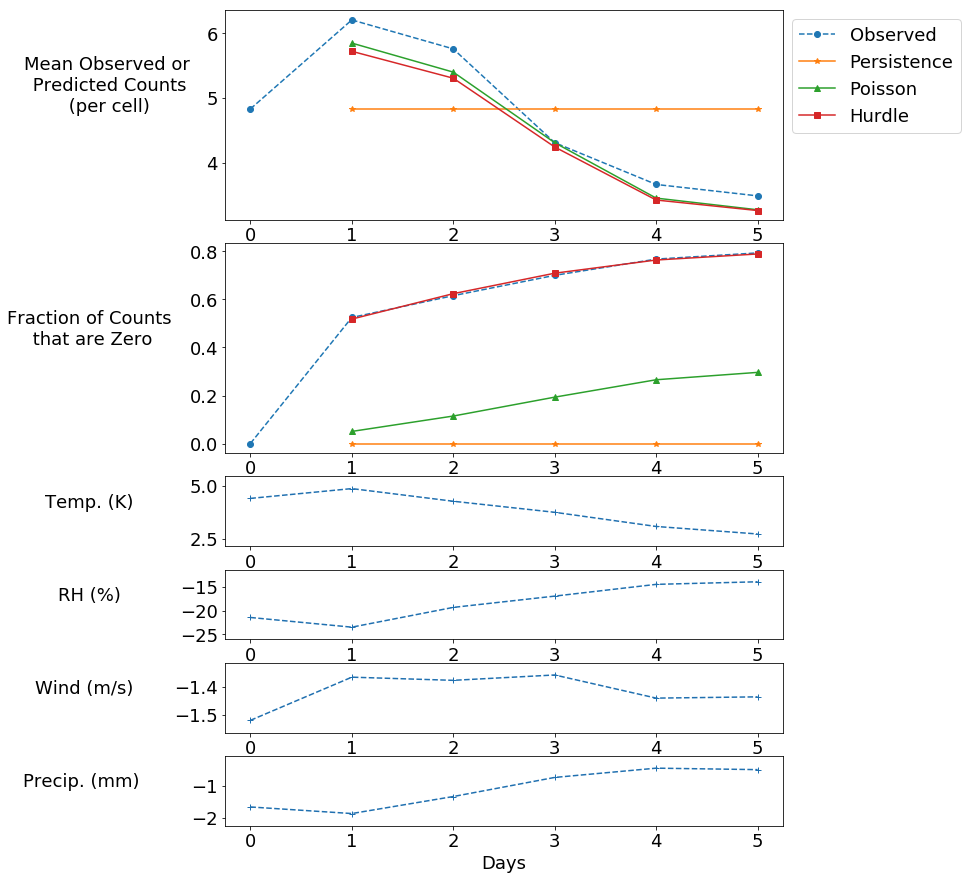

In [246]:
plt.rcParams['figure.figsize'] = [10,15]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)


data_dict,observed = build_forecast_dict(df)
display_simulation(data_dict,observed, data=df, covars=covars, covar_means=covar_means, markers=['*', '^', 's'], label_pad = [100,90,90,110])

Text(0,0.5,'# of Fires')

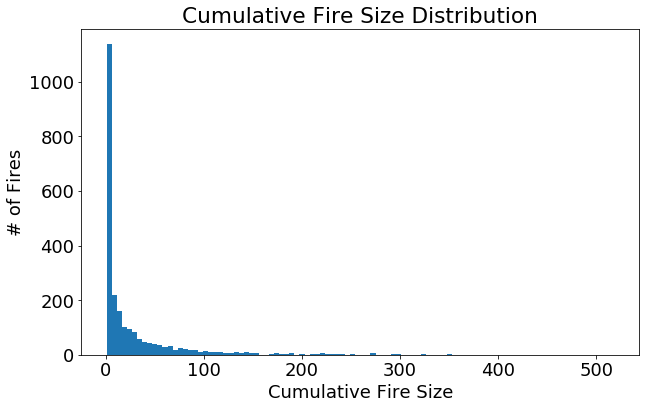

In [314]:
plt.rcParams['figure.figsize'] = [10,6]

_ = plt.hist(df_cum, bins=100)
plt.title('Cumulative Fire Size Distribution')
plt.xlabel('Cumulative Fire Size')
plt.ylabel('# of Fires')

Text(0,0.5,'# of Fires')

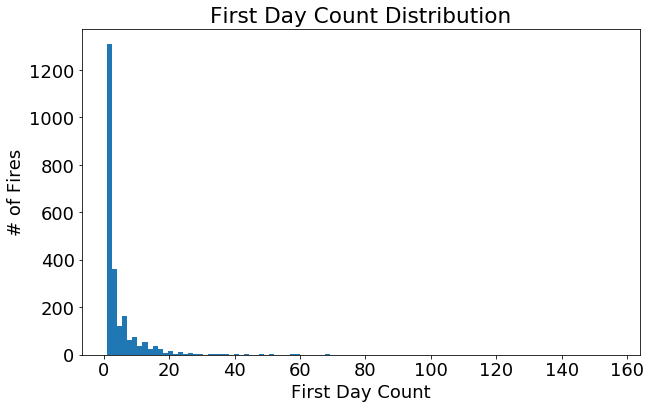

In [315]:

plt.rcParams['figure.figsize'] = [10,6]

_ = plt.hist(df.num_det_0, bins=100)
plt.title('First Day Count Distribution')
plt.xlabel('First Day Count')
plt.ylabel('# of Fires')

In [100]:
PERCENTILE = 80
UPPER = True

df_cum = df.num_det_0 + df.num_det_1 + df.num_det_2 + df.num_det_3 + df.num_det_4 + df.num_det_5

if UPPER:
    ind = df_cum >= np.percentile(df_cum, PERCENTILE)
else:
    ind = df_cum <= np.percentile(df_cum, PERCENTILE)
    
print(np.percentile(df_cum, PERCENTILE))

df_percent = df[ind]

data_dict,observed = build_forecast_dict(df_percent)

41.0


In [69]:
from helper.date_util import filter_fire_season
covars = [('Temp. (K)', 'Temperature', '#e34a33'), ('RH (%)', 'Humidity', '#20874b'), 
 ('Wind (m/s)', 'Wind', '#535353'), ('Precip. (mm)', 'Rain', '#2070b0')]

covar_means = {}
for _,cv,_ in covars:
    #mean = filter_fire_season(X_grid_dict_nw[1].copy().reset_index())[cv.lower()].mean()
    mean = X_grid_dict_nw[1][cv.lower()].mean()
    covar_means[cv] = mean

In [87]:
del data_dict['Hurdle']

Temp. (K) 283.44000244140625
RH (%) 77.24828338623047
Wind (m/s) 3.8145251274108887
Precip. (mm) 2.6019697189331055


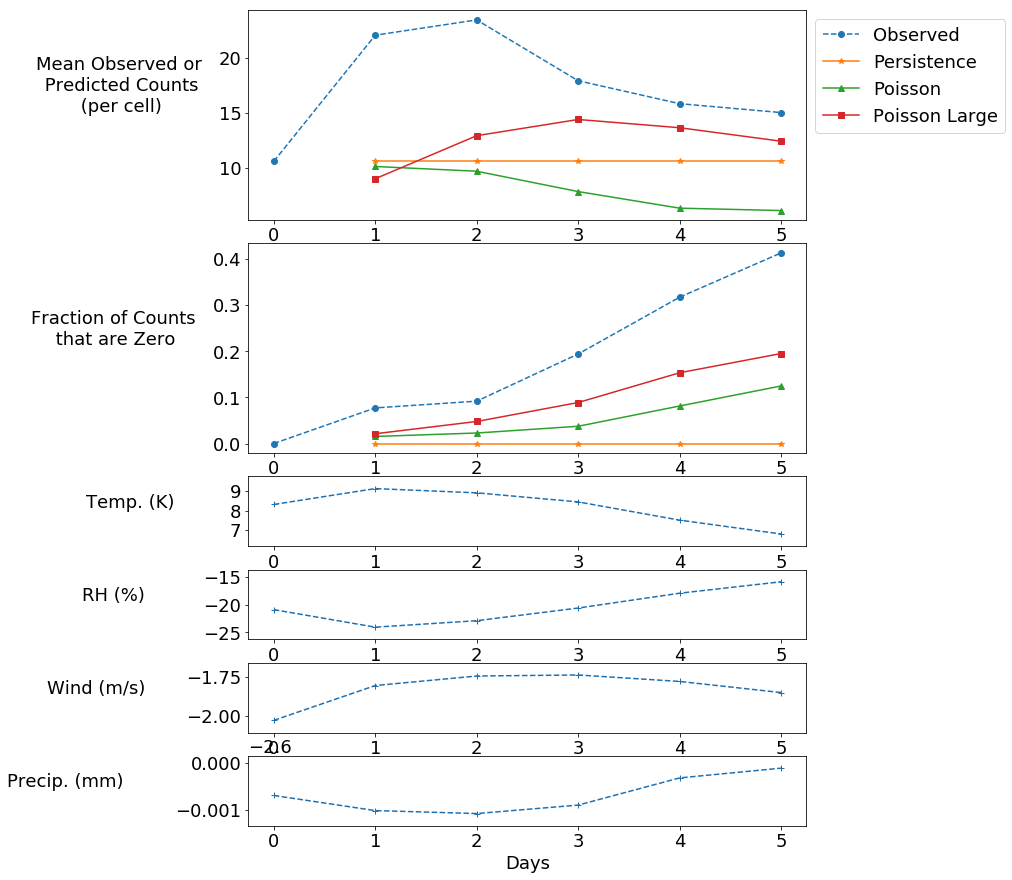

In [101]:
plt.rcParams['figure.figsize'] = [10,15]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)


display_simulation(data_dict,observed, data=df_percent, covars=covars, covar_means=covar_means, markers=['*', '^', 's'], label_pad = [100,90,90,110])

Temp. (K) 283.44000244140625
RH (%) 77.24828338623047
Wind (m/s) 3.8145251274108887
Precip. (mm) 2.6019697189331055


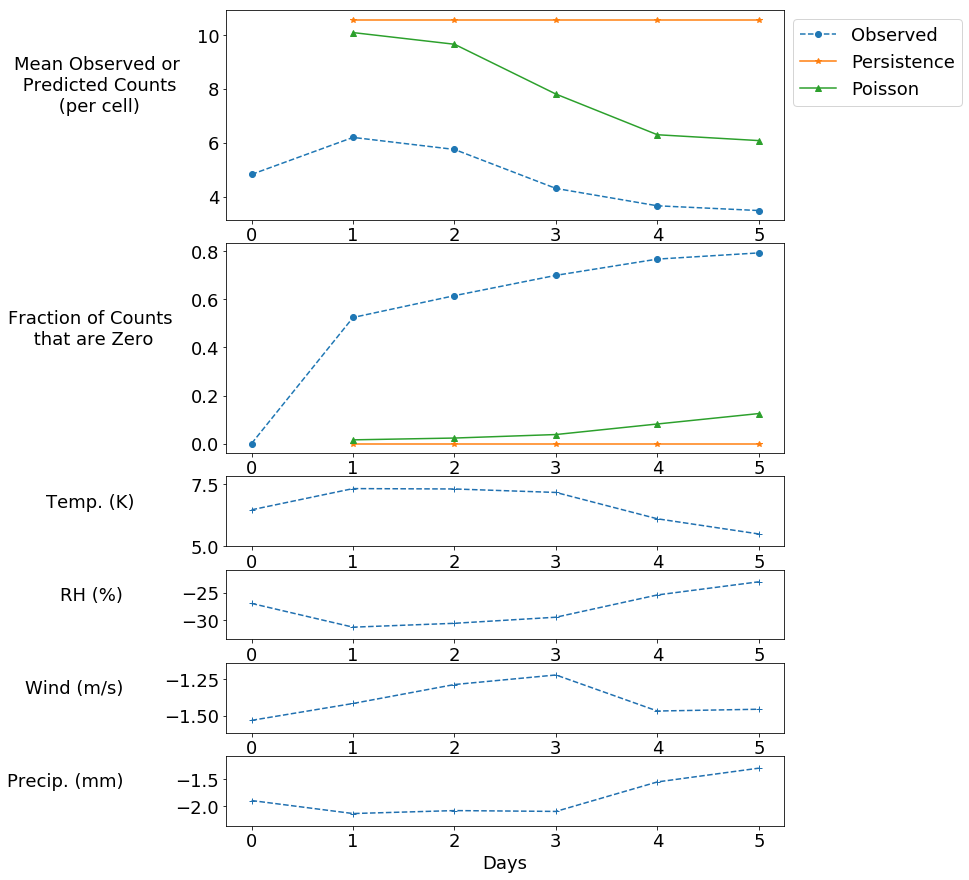

In [96]:
plt.rcParams['figure.figsize'] = [10,15]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)


display_simulation(data_dict,observed, data=df_percent, covars=covars, covar_means=covar_means, markers=['*', '^', 's'], label_pad = [100,90,90,110])

In [75]:
PERCENTILE = 80
UPPER = False

if UPPER:
    ind = df_cum >= np.percentile(df.num_det_0, PERCENTILE)
else:
    ind = df_cum <= np.percentile(df.num_det_0, PERCENTILE)
    
print(np.percentile(df.num_det_0, PERCENTILE))

df_percent = df[ind]

data_dict,observed = build_forecast_dict(df_percent)

6.0


Temp. (K) 283.44000244140625
RH (%) 77.24828338623047
Wind (m/s) 3.8145251274108887
Precip. (mm) 2.6019697189331055


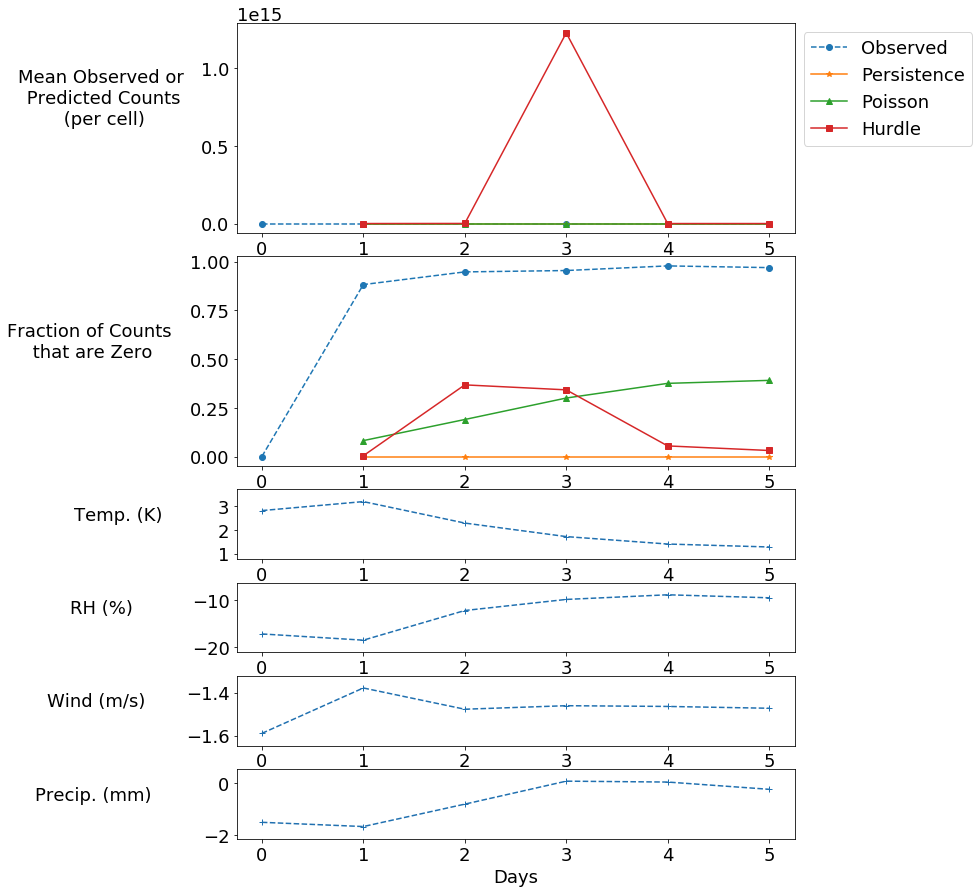

In [76]:
plt.rcParams['figure.figsize'] = [10,15]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)


display_simulation(data_dict,observed, data=df_percent, covars=covars, covar_means=covar_means, markers=['*', '^', 's'], label_pad = [100,90,90,110])

In [719]:
import statsmodels
def plot_normalized(X_ds, covars, with_y=False):
    fig = plt.figure()
    ax=None
    for i,c in enumerate(covars):
        ax = fig.add_subplot(1,len(covars),i+1, sharey=ax)
        arr = X_ds[c].values
        y = X_ds.num_det.values
        if c=='num_det':            
            arr = arr[arr!=0]
            y = arr
        arr = (arr-np.mean(arr))/np.std(arr)
        
        if with_y:
            arr = arr[y!=0]
            y = y[y!=0]    
            #plt.scatter(arr, y)
            regsDF, evalDF = loess(arr, y, alpha=.01, poly_degree=1, robustify=True)
            l_x  = evalDF['v'].values
            l_y  = evalDF['g'].values
            plt.plot(l_x, l_y)
        else:
            sb.distplot(arr, label=c, ax=ax, kde=False, norm_hist=True)
        
        ax.set_title(c)
        if i > 0:
            ax.get_yaxis().set_visible(False)

/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/ipykernel_launcher.py:119: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



KeyboardInterrupt: 

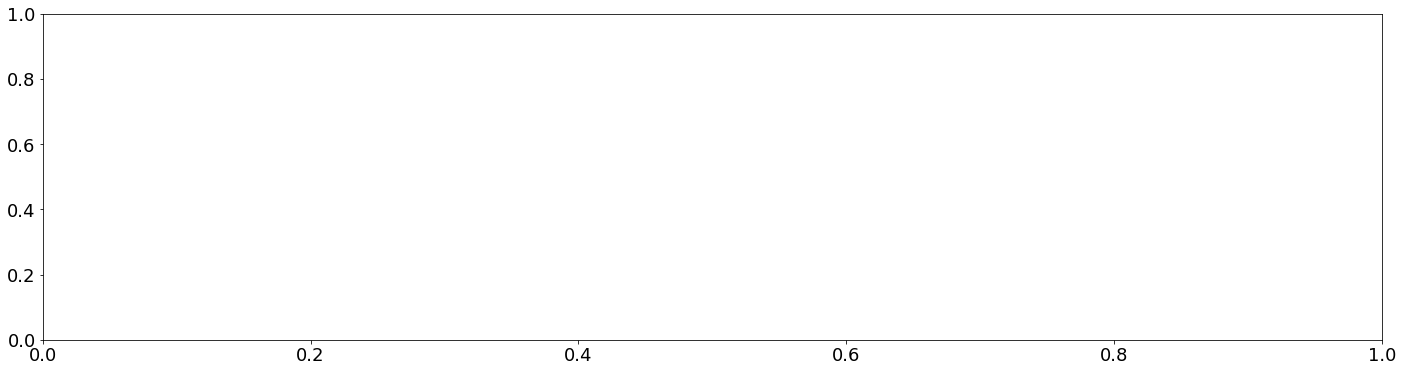

In [1401]:
plt.rcParams['figure.figsize'] = [24,6]
plot_normalized(X_grid_dict_nw[1], ['temperature'], True)

In [717]:
"""
Local Regression (LOESS) estimation routine with optional 
iterative robust estimation procedure. Setting `robustify=True` 
indicates that the robust estimation procedure should be 
performed. 
"""
import numpy as np
import pandas as pd
import scipy


def loc_eval(x, b):
    """
    Evaluate `x` using locally-weighted regression parameters.
    Degree of polynomial used in loess is inferred from b. `x`
    is assumed to be a scalar.
    """
    loc_est = 0
    for i in enumerate(b): loc_est+=i[1]*(x**i[0])
    return(loc_est)



def loess(xvals, yvals, alpha, poly_degree=1, robustify=False):
    """
    Perform locally-weighted regression via xvals & yvals.
    Variables used within `loess` function:

        n         => number of data points in xvals
        m         => nbr of LOESS evaluation points
        q         => number of data points used for each
                     locally-weighted regression
        v         => x-value locations for evaluating LOESS
        locsDF    => contains local regression details for each
                     location v
        evalDF    => contains actual LOESS output for each v
        X         => n-by-(poly_degree+1) design matrix
        W         => n-by-n diagonal weight matrix for each
                     local regression
        y         => yvals
        b         => local regression coefficient estimates.
                     b = `(X^T*W*X)^-1*X^T*W*y`. Note that `@`
                     replaces np.dot in recent numpy versions.
        local_est => response for local regression
    """
    # sort dataset by xvals:
    all_data = sorted(zip(xvals, yvals), key=lambda x: x[0])
    xvals, yvals = zip(*all_data)

    locsDF = pd.DataFrame(
                columns=[
                  'loc','x','weights','v','y','raw_dists',
                  'scale_factor','scaled_dists'
                  ])
    evalDF = pd.DataFrame(
                columns=[
                  'loc','est','b','v','g'
                  ])

    n = len(xvals)
    m = n + 1
    q = int(np.floor(n * alpha) if alpha <= 1.0 else n)
    avg_interval = ((max(xvals)-min(xvals))/len(xvals))
    v_lb = max(0,min(xvals)-(.5*avg_interval))
    v_ub = (max(xvals)+(.5*avg_interval))
    v = enumerate(np.linspace(start=v_lb, stop=v_ub, num=m), start=1)

    # Generate design matrix based on poly_degree.
    xcols = [np.ones_like(xvals)]
    for j in range(1, (poly_degree + 1)):
        xcols.append([i ** j for i in xvals])
    X = np.vstack(xcols).T


    for i in v:

        iterpos = i[0]
        iterval = i[1]

        # Determine q-nearest xvals to iterval.
        iterdists = sorted([(j, np.abs(j-iterval)) \
                           for j in xvals], key=lambda x: x[1])

        _, raw_dists = zip(*iterdists)

        # Scale local observations by qth-nearest raw_dist.
        scale_fact = raw_dists[q-1]
        scaled_dists = [(j[0],(j[1]/scale_fact)) for j in iterdists]
        weights = [(j[0],((1-np.abs(j[1]**3))**3 \
                      if j[1]<=1 else 0)) for j in scaled_dists]

        # Remove xvals from each tuple:
        _, weights      = zip(*sorted(weights,     key=lambda x: x[0]))
        _, raw_dists    = zip(*sorted(iterdists,   key=lambda x: x[0]))
        _, scaled_dists = zip(*sorted(scaled_dists,key=lambda x: x[0]))

        iterDF1 = pd.DataFrame({
                    'loc'         :iterpos,
                    'x'           :xvals,
                    'v'           :iterval,
                    'weights'     :weights,
                    'y'           :yvals,
                    'raw_dists'   :raw_dists,
                    'scale_fact'  :scale_fact,
                    'scaled_dists':scaled_dists
                    })

        locsDF = pd.concat([locsDF, iterDF1])
        W = np.diag(weights)
        y = yvals
        b = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y)
        local_est = loc_eval(iterval, b)

        iterDF2 = pd.DataFrame({
                     'loc':[iterpos],
                     'b'  :[b],
                     'v'  :[iterval],
                     'g'  :[local_est]
                     })

        evalDF = pd.concat([evalDF, iterDF2])

    # Reset indicies for returned DataFrames.
    locsDF.reset_index(inplace=True)
    locsDF.drop('index', axis=1, inplace=True)
    locsDF['est'] = 0; evalDF['est'] = 0
    locsDF = locsDF[['loc','est','v','x','y','raw_dists',
                     'scale_fact','scaled_dists','weights']]


    if robustify==True:

        cycle_nbr = 1
        robust_est = [evalDF]

        while True:
            # Perform iterative robustness procedure for each local regression.
            # Evaluate local regression for each item in xvals.
            #
            # e1_i => raw residuals
            # e2_i => scaled residuals
            # r_i  => robustness weight
            revalDF = pd.DataFrame(
                            columns=['loc','est','v','b','g']
                            )

            for i in robust_est[-1]['loc']:

                prevDF = robust_est[-1]
                locDF = locsDF[locsDF['loc']==i]
                b_i = prevDF.loc[prevDF['loc']==i,'b'].item()
                w_i = locDF['weights']
                v_i = prevDF.loc[prevDF['loc']==i, 'v'].item()
                g_i = prevDF.loc[prevDF['loc']==i, 'g'].item()
                e1_i = [k-loc_eval(j,b_i) for (j,k) in zip(xvals,yvals)]
                e2_i = [j/(6*np.median(np.abs(e1_i))) for j in e1_i]
                r_i = [(1-np.abs(j**2))**2 if np.abs(j)<1 else 0 for j in e2_i]
                w_f = [j*k for (j,k) in zip(w_i, r_i)]    # new weights
                W_r = np.diag(w_f)
                b_r = np.linalg.inv(X.T @ W_r @ X) @ (X.T @ W_r @ y)
                riter_est = loc_eval(v_i, b_r)

                riterDF = pd.DataFrame({
                             'loc':[i],
                             'b'  :[b_r],
                             'v'  :[v_i],
                             'g'  :[riter_est],
                             'est':[cycle_nbr]
                             })

                revalDF = pd.concat([revalDF, riterDF])
            robust_est.append(revalDF)

            # Compare `g` vals from two latest revalDF's in robust_est.
            idiffs = \
                np.abs((robust_est[-2]["g"]-robust_est[-1]["g"])/robust_est[-2]["g"])

            if ((np.all(idiffs<.005)) or cycle_nbr>50): break

            cycle_nbr+=1
            print(cycle_nbr)

        # Vertically bind all DataFrames from robust_est.
        evalDF = pd.concat(robust_est)

    evalDF.reset_index(inplace=True)
    evalDF.drop('index', axis=1, inplace=True)
    evalDF = evalDF[['loc','est', 'v', 'b', 'g']]

    return(locsDF, evalDF)

In [14]:
%%capture
# Load results 96080505164392238362426256451437894773
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/202399934703193354839292243207122060736.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_persistence = saved['summary_results']

In [89]:
# TODO: Figure out why there is a mismatch
results_persistence['test']['root_mean_squared_error_zero_zero_target'] = (['Avg.', 1, 2, 3, 4, 5],
 [0, 0, 0, 0, 0, 0],
 [0.99384723265715003,
  0.99339393939393938,
  0.99307137490608566,
  0.99286651640370649,
  0.99273779113448535])

In [15]:
%%capture
# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/169950219835954168481422721345816913166.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_mean = saved['summary_results']

In [18]:
%%capture
# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/143894926156446742676812844564690969379.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_ar = saved['summary_results']

In [7]:
%%capture
# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/47895086183454881572053469962888027645.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_weather = saved['summary_results']
print(saved['params'])

In [9]:
%%capture
# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/318123708515889470662128226264050804886.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_ar_weather = saved['summary_results']
print(saved['params'])

In [19]:
%%capture
# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/318123708515889470662128226264050804886.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_ar_temp_humid = saved['summary_results']
print(saved['params'])

In [10]:
%%capture
# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/190540304654206759166883913704858344042.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_all = saved['summary_results']
print(saved['params'])

In [13]:
%%capture
# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/5491663722091941840562695307234362269.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_weather_era = saved['summary_results']
print(saved['params'])

In [12]:
%%capture
# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/116978175691470525436291373095405015976.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_ar_weather_era = saved['summary_results']
print(saved['params'])

In [16]:
%%capture
# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/98372647846482025435147482980125832450.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_all_era = saved['summary_results']
print(saved['params'])

In [18]:
%%capture
# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/75201577841497752418773189405522046124.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_ar_temp_hudim_era = saved['summary_results']
print(saved['params'])

In [19]:
def plot_active_ignition(results_dict, measurements, scale=False, markers=None, sample='test', label=None, baseline=None, min_y=None, y_labels=None, col_len=2):
    num_plots = len(measurements)
    gs = gridspec.GridSpec(int(np.ceil(num_plots/col_len)), 4)
    fig = plt.figure()
    
    ax = None
    for i, (name,meas,share,use_baseline) in enumerate(measurements):            
        row = i//col_len
        col = int(np.remainder(i,col_len))
        col_ind1 = col*col_len
        col_ind2 = (col+1)*col_len
    
        if (i == len(measurements)-1) and (np.remainder(i,2)==0):
            col_ind1 = col*col_len + 1
            col_ind2 = (col+1)*col_len + 1
        if scale and share:
            ax = fig.add_subplot(gs[row, col_ind1:col_ind2], sharey=ax)
        else:
            ax = fig.add_subplot(gs[row, col_ind1:col_ind2])
        plt.xlabel('Days')
        plt.title(name)
        if y_labels:
            plt.ylabel(y_labels[i])
        elif np.remainder(i,col_len)==0:
            if label:
                plt.ylabel(label)
            elif scale:
                plt.ylabel('MSE')
            else:
                plt.ylabel('RMSE')
        for j,(k,v) in enumerate(results_dict.items()):
            marker = '-'
            if markers is not None:
                marker += markers[j]
                
            results = v[sample][meas][1][1:]  
            if scale:                
                try:
                    scale_factor = v[sample][meas][2] 
                except:
                    scale_factor = [1] * len(results)
                #results = np.sqrt(np.array(results)**2 * scale[name])
                results = np.array(results)**2 * np.array(scale_factor)
                
            if baseline is not None and use_baseline:
                if k == baseline:
                    continue
                baseline_results = results_dict[baseline][sample][meas][1][1:]  
                if scale:                
                    try:
                        scale_factor = results_dict[baseline][sample][meas][2] 
                    except:
                        scale_factor = [1] * len(baseline_results)
                    baseline_results = np.array(baseline_results)**2 * np.array(scale_factor)
                
                results = (baseline_results - results) / baseline_results * 100
                #results = 100 - results
                #plt.ylabel('100 - MSE SS %')
                
            x = range(1,len(results)+1)
            plt.plot(x, results, marker, label=k)
            plt.xticks(x)
            
        if min_y is not None:
            y_min,y_max = plt.ylim()
            plt.ylim(min_y, y_max)
            
            
        if (i==(col_len-1)) or (len(measurements)==1):
            _ = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    gs.tight_layout(fig)
    
    

IndexError: tuple index out of range

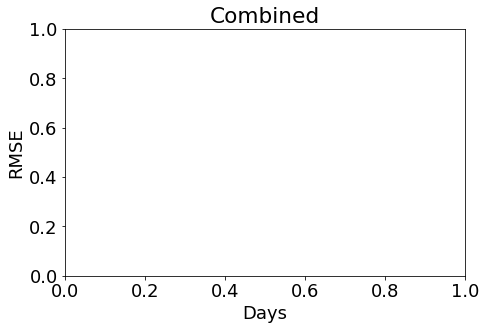

In [1719]:
plt.rcParams['figure.figsize'] = [15,10]

results_dict = {'Persistence': results_persistence, 'AR': results_ar, 'Weather': results_weather, 'AR + Weather': results_poisson_true, 'All': results_poisson}
measurements = [('Combined','root_mean_squared_error', False), ('Active','root_mean_squared_error_active', False),
                              ('Ignition', 'root_mean_squared_error_ignition', False)]

plot_active_ignition(results_dict, measurements)

In [1802]:
results_persistence['test']['root_mean_squared_error_active']

(['Avg.', 1, 2, 3, 4, 5],
 [23.648372294678552,
  21.216230217867032,
  23.714920656085187,
  24.444328203192633,
  24.526154041571839,
  24.34022835467605],
 [0.0049727022289005763,
  0.0049727022289005763,
  0.0049727022289005763,
  0.0049727022289005763,
  0.0049727022289005763])

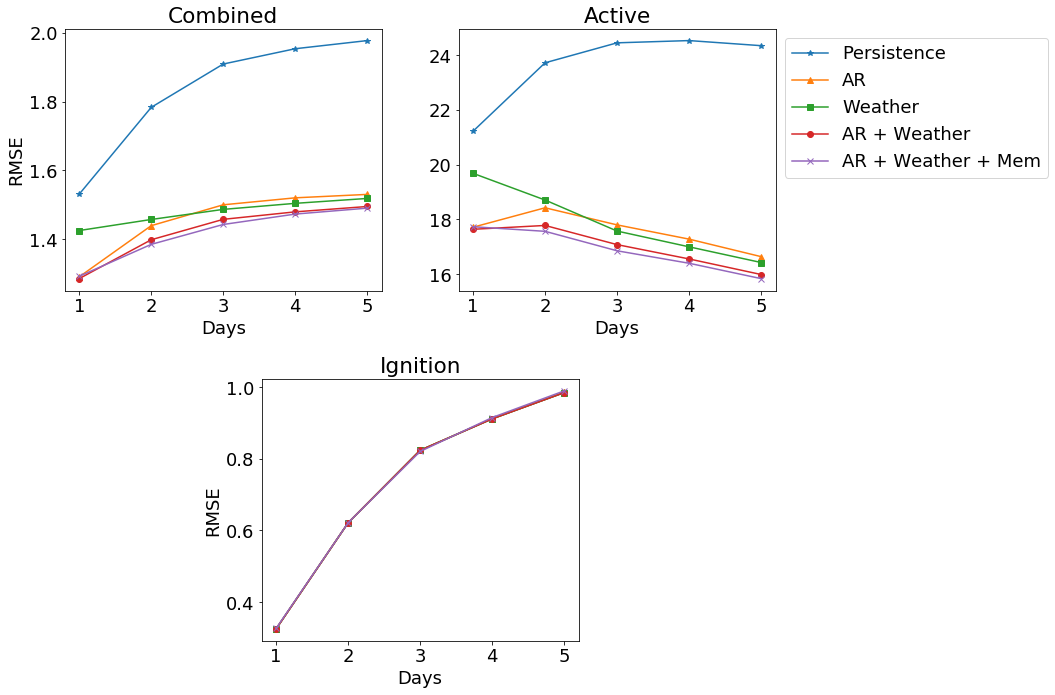

In [2213]:
plt.rcParams['figure.figsize'] = [15,10]

results_dict = {'Persistence': results_persistence, 'AR': results_ar, 'Weather': results_weather, 'AR + Weather': results_poisson_true, 'AR + Weather + Mem': results_poisson}
measurements = [('Combined','root_mean_squared_error', True), ('Active','root_mean_squared_error_active', True),
                              ('Ignition', 'root_mean_squared_error_ignition', False)]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, scale=False, markers=['*', '^', 's', 'o', 'x', 'd'])

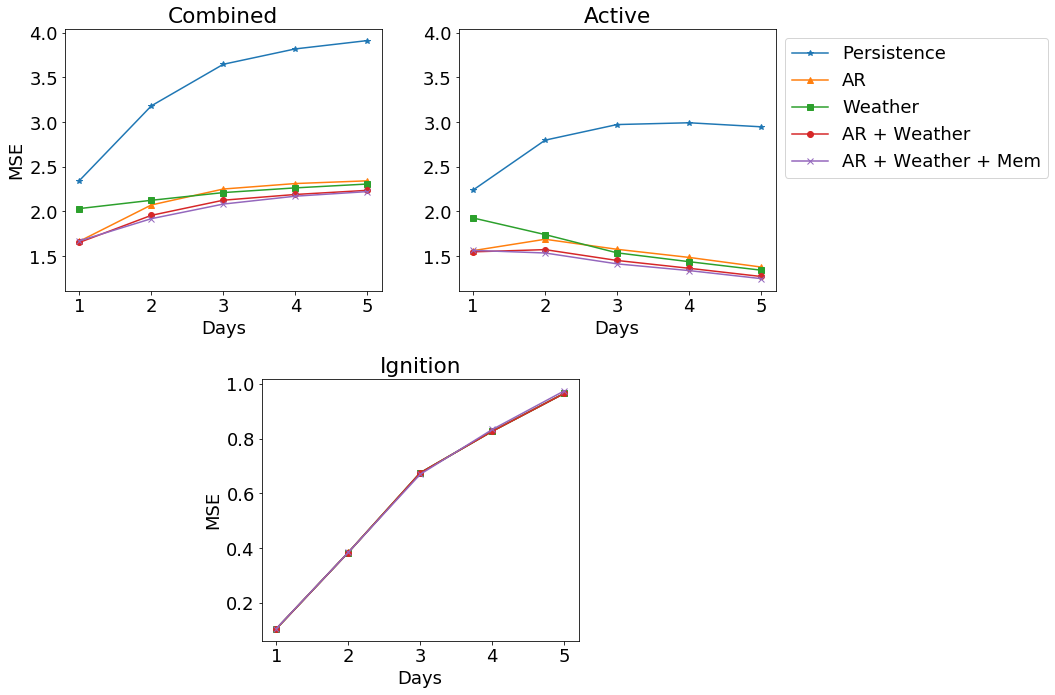

In [2214]:
plt.rcParams['figure.figsize'] = [15,10]

results_dict = {'Persistence': results_persistence, 'AR': results_ar, 'Weather': results_weather, 'AR + Weather': results_poisson_true, 'AR + Weather + Mem': results_poisson}
measurements = [('Combined','root_mean_squared_error', True), ('Active','root_mean_squared_error_active', True),
                              ('Ignition', 'root_mean_squared_error_ignition', False)]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, scale=True, markers=['*', '^', 's', 'o', 'x'])

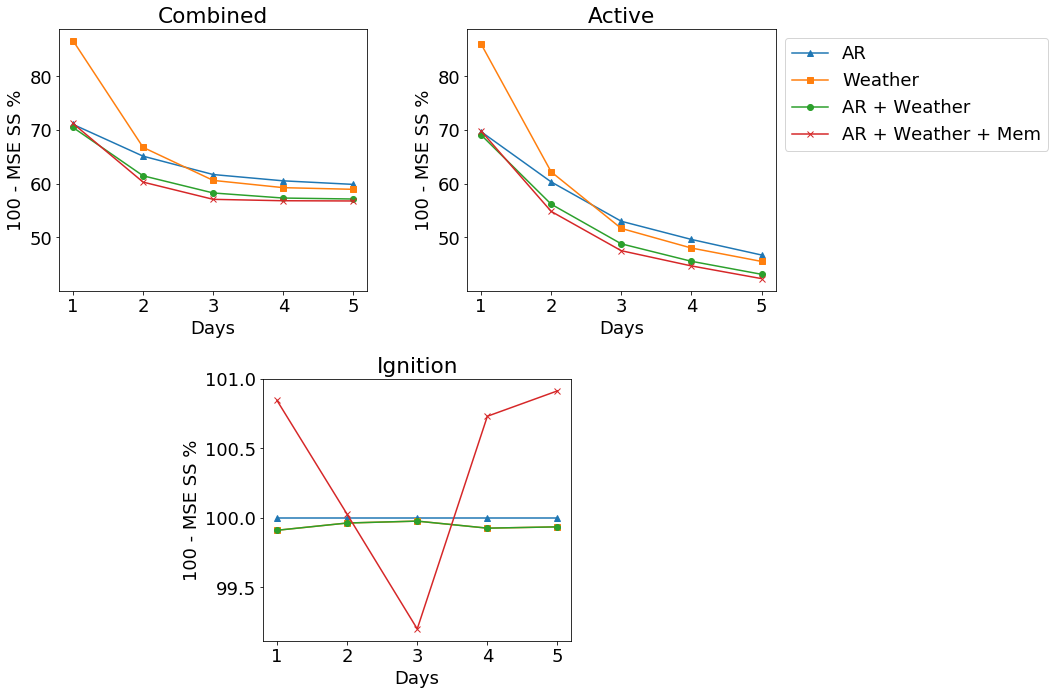

In [2316]:
plt.rcParams['figure.figsize'] = [15,10]

results_dict = {'Persistence': results_persistence, 'AR': results_ar, 'Weather': results_weather, 'AR + Weather': results_poisson_true, 'AR + Weather + Mem': results_poisson}
measurements = [('Combined','root_mean_squared_error', True), ('Active','root_mean_squared_error_active', True),
                              ('Ignition', 'root_mean_squared_error_ignition', False)]

alpha = 0.0049727
baseline = np.array([2.344, 3.179, 3.648, 3.818, 3.912])
plot_active_ignition(results_dict, measurements, scale=True, markers=['*', '^', 's', 'o', 'x'], baseline='Persistence')

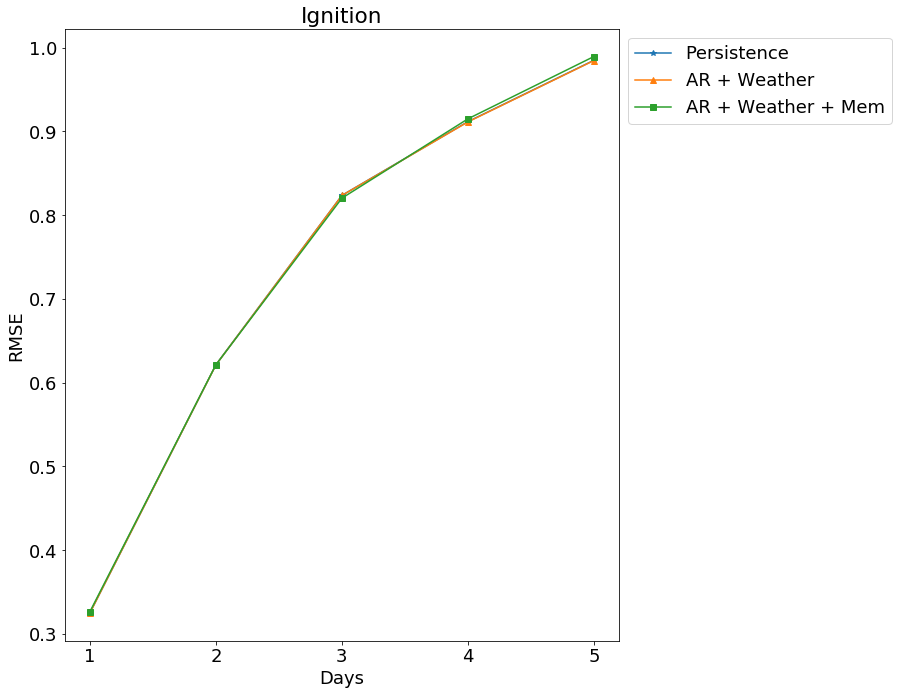

In [2208]:
plt.rcParams['figure.figsize'] = [20,10]

results_dict = {'Persistence': results_persistence, 'AR + Weather': results_poisson_true,'AR + Weather + Mem': results_poisson}
measurements = [                              ('Ignition', 'root_mean_squared_error_ignition', False)]

alpha = 0.0049727
baseline = np.array([2.344, 3.179, 3.648, 3.818, 3.912])
plot_active_ignition(results_dict, measurements, scale=False, markers=['*', '^', 's', 'o', 'x'])

In [1]:
plt.rcParams['figure.figsize'] = [15,10]

results_dict = {'Persistence': results_persistence, 'AR': results_ar, 'Weather': results_weather, 'AR + Weather': results_poisson_true, 'AR + Weather + Mem': results_poisson}
measurements = [('Combined','root_mean_squared_error', True), ('Active','root_mean_squared_error_active_target', True),
                ('Ignition', 'root_mean_squared_error_ignition_target', False), ('Zero','root_mean_squared_error_zero_target', False)]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, scale=True, markers=['*', '^', 's', 'o', 'x'])

NameError: name 'plt' is not defined

In [ ]:
plt.rcParams['figure.figsize'] = [24,5]

results_dict = {'Persistence': results_persistence, 'AR': results_ar, 'Weather': results_weather, 'AR + Weather': results_poisson_true, 'AR + Weather + Mem': results_poisson}
measurements = [('Combined','root_mean_squared_error'), ('Active','root_mean_squared_error_active'),
                              ('Ignition', 'root_mean_squared_error_ignition')]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, scale={'Combined': 1, 'Active': alpha, 'Ignition': 1-alpha}, ignition=False)

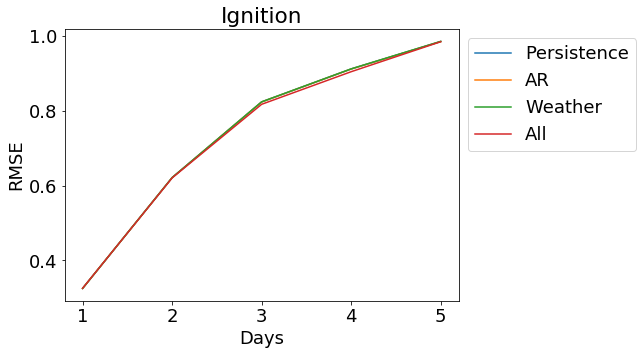

In [1600]:
plt.rcParams['figure.figsize'] = [24,5]
results_dict = {'Persistence': results_persistence, 'AR': results_ar, 'Weather': results_weather, 'All': results_poisson}
measurements = [('Ignition', 'root_mean_squared_error_ignition')]

plot_active_ignition(results_dict, measurements)

In [1273]:
def make_table(results, measurements, baseline=None):
    header = ['Avg.'] + ['K=%d' % i for i in range(1,6)]
    for i, (name,meas) in enumerate(measurements):
        rows = []
        for k,v in results_dict.items():        
            results = v['test'][meas][1]
            if baseline is not None:
                results = 1 - (np.array(results)/np.array(baseline['test'][meas][1]))
            rows.append([k]+list(results))
        print('========\n' + name, '\n========')
        print(tabulate(rows, headers=header, floatfmt=".3f"))
        print('\n')

In [1491]:
results_dict = {'Persistence': results_persistence, 'Mean': results_mean, 'AR': results_ar, 'Weather': results_weather, 'All': results_poisson}
measurements = [('Combined','root_mean_squared_error'), ('Active','root_mean_squared_error_active'),
                              ('Ignition', 'root_mean_squared_error_ignition')]
make_table(results_dict, measurements)

Combined 
               Avg.    K=1    K=2    K=3    K=4    K=5
-----------  ------  -----  -----  -----  -----  -----
Persistence   1.831  1.531  1.783  1.910  1.954  1.978
Mean          1.516  1.469  1.503  1.526  1.538  1.546
AR            1.466  1.315  1.452  1.507  1.524  1.533
Weather       1.476  1.423  1.454  1.485  1.501  1.516
All           1.400  1.275  1.370  1.427  1.454  1.474


Active 
               Avg.     K=1     K=2     K=3     K=4     K=5
-----------  ------  ------  ------  ------  ------  ------
Persistence  23.648  21.216  23.715  24.444  24.526  24.340
Mean         18.498  20.315  19.419  18.235  17.592  16.930
AR           17.730  18.078  18.623  17.913  17.345  16.689
Weather      17.830  19.655  18.660  17.541  16.935  16.358
All          16.634  17.480  17.331  16.612  16.166  15.581


Ignition 
               Avg.    K=1    K=2    K=3    K=4    K=5
-----------  ------  -----  -----  -----  -----  -----
Persistence   0.733  0.325  0.621  0.824  0.912  0.98

In [1492]:
results_dict = {'Mean': results_mean, 'AR': results_ar, 'Weather': results_weather, 'All': results_poisson}
measurements = [('Combined','root_mean_squared_error'), ('Active','root_mean_squared_error_active'),
                              ('Ignition', 'root_mean_squared_error_ignition')]
make_table(results_dict, measurements, baseline=results_persistence)

Combined 
           Avg.    K=1    K=2    K=3    K=4    K=5
-------  ------  -----  -----  -----  -----  -----
Mean      0.172  0.041  0.157  0.201  0.213  0.218
AR        0.199  0.141  0.186  0.211  0.220  0.225
Weather   0.194  0.070  0.184  0.222  0.232  0.234
All       0.236  0.167  0.232  0.253  0.256  0.255


Active 
           Avg.    K=1    K=2    K=3    K=4    K=5
-------  ------  -----  -----  -----  -----  -----
Mean      0.218  0.042  0.181  0.254  0.283  0.304
AR        0.250  0.148  0.215  0.267  0.293  0.314
Weather   0.246  0.074  0.213  0.282  0.309  0.328
All       0.297  0.176  0.269  0.320  0.341  0.360


Ignition 
           Avg.     K=1    K=2     K=3     K=4     K=5
-------  ------  ------  -----  ------  ------  ------
Mean      0.000   0.000  0.000   0.000   0.000   0.000
AR        0.000   0.000  0.000   0.000   0.000   0.000
Weather  -0.000   0.000  0.000  -0.000  -0.000  -0.000
All       0.004  -0.001  0.002   0.008   0.008   0.001




In [1345]:
c = results_ar['test']['root_mean_squared_error'][1][5]
a = results_ar['test']['root_mean_squared_error_active'][1][5]
i = results_ar['test']['root_mean_squared_error_ignition'][1][5]
print(a,i,c)

16.6885969075 0.984694848619 1.53288810591


In [1839]:
# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/316554660742337103524899654828409635742.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_joint_poisson = saved['summary_results']
results_joint_poisson_model = saved['models']
print(saved['params'])

not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
{'model_structure': 'grid', 'separated_ignitions': 'unified', 'active_model_type': 'poisson', 'ignition_model_type': 'poisson', 'covariates': ('temperature', 'humidity', 'rain', 'wind'), 'ignition_covariates_exclude': (), 'memory_type': 'none', 'memory_covariates': ('temperature', 'humidity', 'rain'), 'memory_log_covariates': ('num_det',), 'memory_length': 10, 'decay_method': 'fixed', 'decay_values': <FrozenOrderedDict OrderedDict([('default', 0.05), ('num_det', 0.05), ('temperature', 0.25), ('humidity', 0.5), ('rain', 0.25)])>, 'forecast_method': 'separate', 'active_check_days': 2, 'regularization_weight': None, 'log_correction_type': 'max', 'log_correction_constant': 0.5, 'log_covariates': ('num_det',), 'fill_method': 'integrate_interp', 'resolution': '4', 'region': 'alaska', 'forecast_horizon': 5, 'normalize_params': False}


In [1883]:
# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/193098765854377033813937233079546037305.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_joint_poisson_ar_weather = saved['summary_results']
results_joint_poisson_ar_weather_model = saved['models']
print(saved['params'])

not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
{'model_structure': 'grid', 'separated_ignitions': 'unified', 'active_model_type': 'poisson', 'ignition_model_type': 'poisson', 'covariates': ('temperature', 'humidity', 'rain', 'wind'), 'ignition_covariates_exclude': (), 'memory_type': 'none', 'memory_covariates': ('temperature', 'humidity', 'rain'), 'memory_log_covariates': ('num_det',), 'memory_length': 10, 'decay_method': 'fixed', 'decay_values': <FrozenOrderedDict OrderedDict([('default', 0.05), ('num_det', 0.05), ('temperature', 0.25), ('humidity', 0.5), ('rain', 0.25)])>, 'forecast_method': 'separate', 'active_check_days': 2, 'regularization_weight': None, 'log_correction_type': 'max', 'log_correction_constant': 0.5, 'log_covariates': ('num_det',), 'fill_method': 'integrate_interp', 'resolution': '4', 'region': 'alaska', 'forecast_horizon': 5, 'normalize_params': False}


In [1884]:
# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/144536500544153977586735672560564038352.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_joint_poisson_weather = saved['summary_results']
results_joint_poisson_weather_model = saved['models']
print(saved['params'])

{'model_structure': 'grid', 'separated_ignitions': 'unified', 'active_model_type': 'poisson', 'ignition_model_type': 'poisson', 'covariates': ('temperature', 'humidity', 'rain', 'wind'), 'ignition_covariates_exclude': (), 'memory_type': 'none', 'memory_covariates': ('temperature', 'humidity', 'rain'), 'memory_log_covariates': ('num_det',), 'memory_length': 10, 'decay_method': 'fixed', 'decay_values': <FrozenOrderedDict OrderedDict([('default', 0.05), ('num_det', 0.05), ('temperature', 0.25), ('humidity', 0.5), ('rain', 0.25)])>, 'forecast_method': 'separate', 'active_check_days': 2, 'regularization_weight': None, 'log_correction_type': 'max', 'log_correction_constant': 0.5, 'log_covariates': (), 'fill_method': 'integrate_interp', 'resolution': '4', 'region': 'alaska', 'forecast_horizon': 5, 'normalize_params': False}


In [1903]:
# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/81058089617577913680592243883243066652.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_joint_poisson_ar_weather_norm = saved['summary_results']
results_joint_poisson_ar_weather_norm_model = saved['models']
print(saved['params'])

{'model_structure': 'grid', 'separated_ignitions': 'active_only', 'active_model_type': 'poisson', 'ignition_model_type': 'poisson', 'covariates': ('temperature', 'humidity', 'rain', 'wind'), 'ignition_covariates_exclude': (), 'memory_type': 'none', 'memory_covariates': ('temperature', 'humidity', 'rain'), 'memory_log_covariates': ('num_det',), 'memory_length': 10, 'decay_method': 'fixed', 'decay_values': <FrozenOrderedDict OrderedDict([('default', 0.05), ('num_det', 0.05), ('temperature', 0.25), ('humidity', 0.5), ('rain', 0.25)])>, 'forecast_method': 'separate', 'active_check_days': 2, 'regularization_weight': None, 'log_correction_type': 'max', 'log_correction_constant': 0.5, 'log_covariates': ('num_det',), 'fill_method': 'integrate_interp', 'resolution': '4', 'region': 'alaska', 'forecast_horizon': 5, 'normalize_params': True}


{'model_structure': 'grid', 'separated_ignitions': 'active_only', 'active_model_type': 'poisson', 'ignition_model_type': 'poisson', 'covariates': ('temperature', 'humidity', 'rain', 'wind'), 'ignition_covariates_exclude': (), 'memory_type': 'none', 'memory_covariates': ('temperature', 'humidity', 'rain'), 'memory_log_covariates': ('num_det',), 'memory_length': 10, 'decay_method': 'fixed', 'decay_values': <FrozenOrderedDict OrderedDict([('default', 0.05), ('num_det', 0.05), ('temperature', 0.25), ('humidity', 0.5), ('rain', 0.25)])>, 'forecast_method': 'separate', 'active_check_days': 2, 'regularization_weight': None, 'log_correction_type': 'max', 'log_correction_constant': 0.5, 'log_covariates': ('num_det',), 'fill_method': 'integrate_interp', 'resolution': '4', 'region': 'alaska', 'forecast_horizon': 5, 'normalize_params': False}


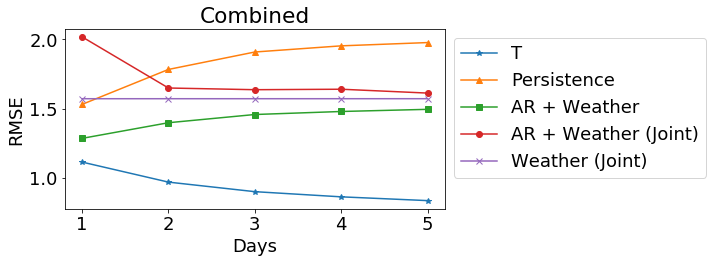

In [1918]:
plt.rcParams['figure.figsize'] = [15,4]

results_dict = {'T': results_joint_poisson_ar_weather_norm, 'Persistence': results_persistence, 'AR + Weather': results_poisson_true, 'AR + Weather (Joint)': results_joint_poisson_ar_weather, 'Weather (Joint)': results_joint_poisson_weather}
measurements = [('Combined','root_mean_squared_error', True)]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, scale=False, markers=['*', '^', 's', 'o', 'x'])

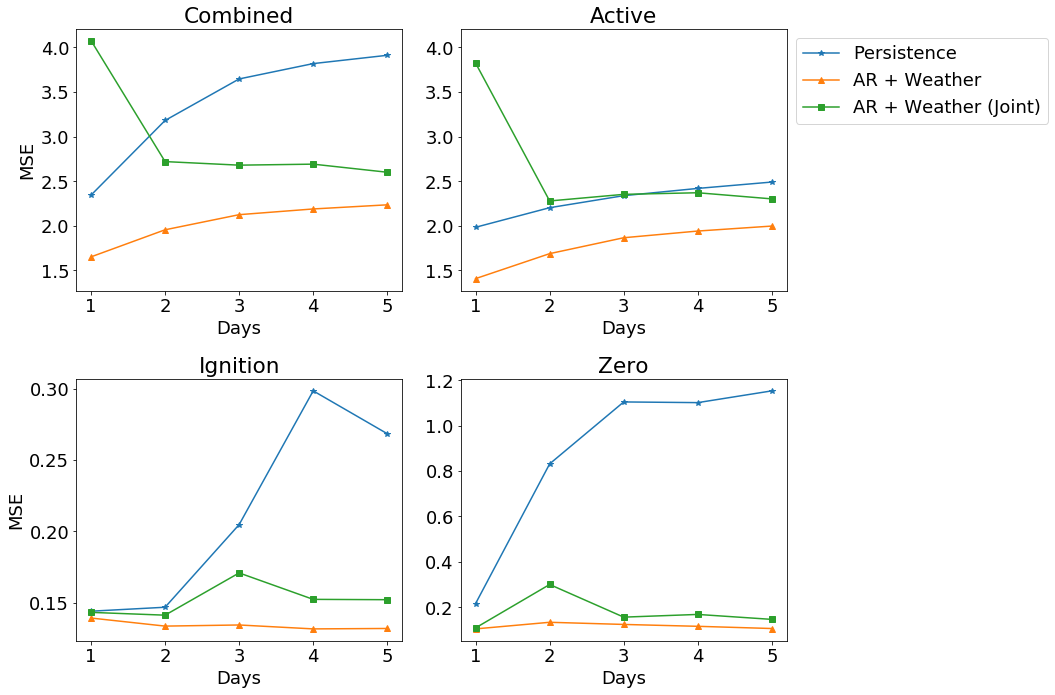

In [2094]:
plt.rcParams['figure.figsize'] = [15,10]

results_dict = {'Persistence': results_persistence, 'AR + Weather': results_poisson_true, 'AR + Weather (Joint)': results_joint_poisson_ar_weather}
measurements = [('Combined','root_mean_squared_error', True), ('Active','root_mean_squared_error_active_target', True),
                ('Ignition', 'root_mean_squared_error_ignition_target', False), ('Zero','root_mean_squared_error_zero_target', False)]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, scale=True, markers=['*', '^', 's', 'o', 'x'])

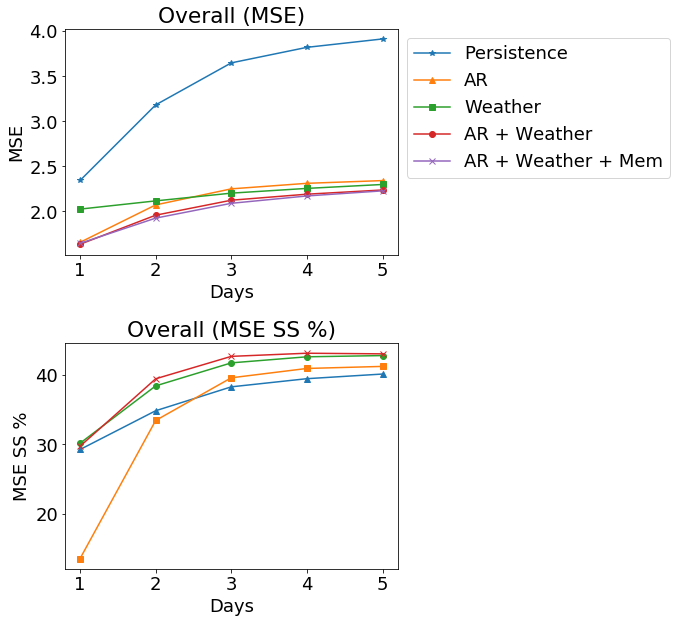

In [198]:
plt.rcParams['figure.figsize'] = [32,9]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

results_dict = {'Persistence': results_persistence,
                'AR': results_ar, 
                'Weather': results_weather,
                'AR + Weather': results_ar_weather,
                'AR + Weather + Mem': results_all}
measurements = [(r'Overall (MSE)','root_mean_squared_error', False, False),
                (r'Overall (MSE SS %)', 'root_mean_squared_error', False, True)]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, baseline='Persistence', scale=True, markers=['*', '^', 's', 'o', 'x'], y_labels = ['MSE', 'MSE SS %'], col_len=1)

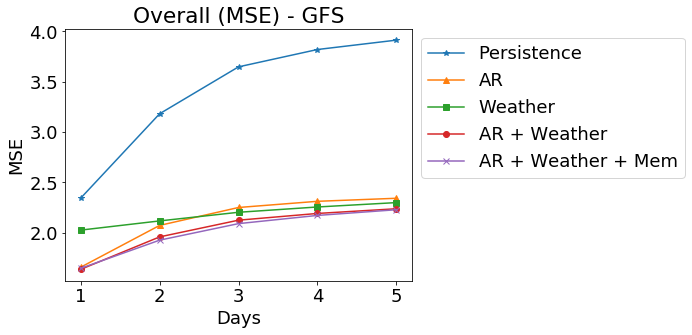

In [27]:
plt.rcParams['figure.figsize'] = [32,5]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

results_dict = {'Persistence': results_persistence,
                'AR': results_ar, 
                'Weather': results_weather,
                'AR + Weather': results_ar_weather,
                'AR + Weather + Mem': results_all}
measurements = [(r'Overall (MSE) - GFS','root_mean_squared_error', False, False),]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, baseline='Persistence', scale=True, markers=['*', '^', 's', 'o', 'x'], y_labels = ['MSE', 'MSE SS %'], col_len=1)

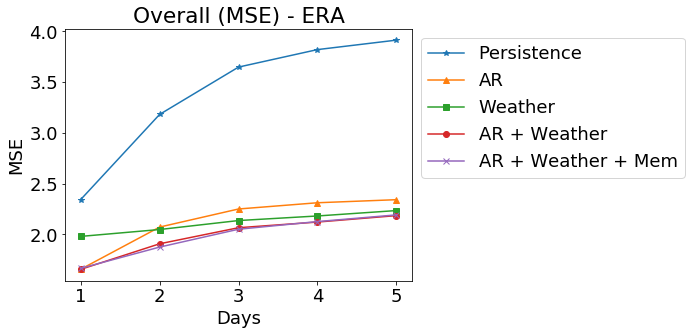

In [22]:
plt.rcParams['figure.figsize'] = [32,5]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

results_dict = {'Persistence': results_persistence,
                'AR': results_ar, 
                'Weather': results_weather_era,
                'AR + Weather': results_ar_weather_era,
                'AR + Weather + Mem': results_all_era}
measurements = [(r'Overall (MSE) - ERA','root_mean_squared_error', False, False),]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, baseline='Persistence', scale=True, markers=['*', '^', 's', 'o', 'x'], y_labels = ['MSE', 'MSE SS %'], col_len=1)

In [84]:
p_t = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.8200849904335095, 1.5306148545553937, 1.7726409409223436, 1.8953196222597466, 1.9379260807626821, 1.9639234536673811]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.067195182436895901, 0.051146691143634924, 0.063863430241114419, 0.070979842257247031, 0.07407836974817826, 0.07590757879430482])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.8200849904335095, 1.5306148545553948, 1.7726409409223429, 1.895319622259747, 1.9379260807626821, 1.9639234536673804]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.067195182436895887, 0.051146691143634904, 0.063863430241114363, 0.070979842257247044, 0.074078369748178288, 0.07590757879430482]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [23.473640812971716, 21.212683330521013, 23.551369256920367, 24.22125990209522, 24.267972351387542, 24.114919223934443], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [10.233841834736364, 9.1353111269406817, 10.349852787709995, 10.666725933379707, 10.594930016341445, 10.422389309309995], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [33.686585339979615, 29.162118833843422, 31.78630751666908, 33.895483292775992, 36.39958277383851, 37.18943428277106], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [18.501771334016901, 15.549132993405101, 17.650122264128548, 18.948454836608306, 20.09302527738242, 20.268121298560118], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [15.597940876399878, 9.098087894256734, 16.31733354253349, 17.829707631016344, 17.307088863362658, 17.437486450830157], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [5.9131172886996337, 3.2540135706866669, 5.7295506585556195, 6.7077216891833364, 6.8602032521768619, 7.0140972728956816], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}
p_h = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.6860056716586747, 1.5680906283496001, 1.6280986666194204, 1.7180400302603056, 1.7327628648914499, 1.7830361681725986]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.060539614623216588, 0.05049730984979317, 0.058070822763219572, 0.062642300214847749, 0.064457678845202065, 0.067029961443020411])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.6860056716586747, 1.5680906283495997, 1.6280986666194197, 1.7180400302603054, 1.7327628648914495, 1.7830361681725995]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.06053961462321663, 0.050497309849793143, 0.058070822763219503, 0.062642300214847846, 0.064457678845202024, 0.067029961443020647]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [21.304043284663912, 21.756164803501306, 21.349875657199046, 21.397456762355478, 20.916251833003528, 21.100467367260194], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [8.8954210913831613, 9.0047219092578601, 9.1849715599081136, 8.9900636965092389, 8.6602292319143697, 8.6371190593262241], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [32.780688011254647, 30.23333895191039, 30.573717443096275, 33.31892302917116, 34.483022084156815, 35.29443854793859], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [17.69123804207435, 15.60127249346333, 16.874528335827794, 18.136953058302222, 18.725549700051271, 19.11788662272712], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [11.528232731665611, 8.3185874521517835, 12.357254748010625, 12.084096895935415, 11.91464301374222, 12.966581548488012], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [4.3206196499378349, 2.9558671642507579, 4.3182915477800021, 4.6174774614761471, 4.7024649950746866, 5.008997081107581], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}
p_vpd = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.6791562936206237, 1.669404890631818, 1.6496482533356422, 1.6868939110938381, 1.6707649343079949, 1.7190694787338257]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.05929449478643041, 0.05263587336271551, 0.057729812529017578, 0.060502886044449644, 0.061486514379056972, 0.064117387616912352])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.6791562936206244, 1.6694048906318188, 1.6496482533356431, 1.6868939110938372, 1.6707649343079947, 1.7190694787338272]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.059294494786430382, 0.052635873362715489, 0.057729812529017654, 0.060502886044449644, 0.061486514379056931, 0.064117387616912241]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [21.13526323451579, 23.222655289752552, 21.679980590193733, 20.89317177685577, 19.876005230779263, 20.004503284997622], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [8.645030100836852, 9.4347825512350383, 9.1163951162554131, 8.5598319890958656, 8.0627342826135315, 8.0514065649844149], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [32.834497802155923, 32.255860033129579, 31.180347024677712, 33.31559425724155, 33.165997108762888, 34.254690586967882], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [17.700560325113777, 16.358095481060523, 17.162183636204524, 18.086238809205454, 18.20629887973001, 18.68998481936837], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [10.868212946179264, 8.93040412272547, 12.33639248454034, 10.705603800611758, 10.856903880937328, 11.511760442081428], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [3.9118467528669782, 3.086295757695511, 4.0242579082349916, 4.005820927703593, 4.0742038305899051, 4.368655340110891], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}

large_split_80 ={'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.2912707537155079, 1.1840443888699215, 1.250163771215316, 1.3100903624508913, 1.3419794841999253, 1.3700757618414863]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.04590472151629741, 0.043714343804419104, 0.045495953141148654, 0.046188231420688175, 0.046827910597473557, 0.047297168617757568])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.3073914586858575, 1.1993718668070803, 1.2694125167400758, 1.3303234448185104, 1.3542818390999594, 1.383567625963662]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.046073522099910905, 0.043934829323501005, 0.045785201279204622, 0.046379651275049595, 0.046911584260593088, 0.047356344361206219]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [14.993865764012929, 16.374593710057948, 15.710401491728989, 14.838238620048667, 14.231276918674315, 13.814818079554733], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [5.9863201926341763, 7.6850208243724527, 6.7143588188891963, 5.719679066341314, 5.1317463715022216, 4.6807958820656967], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [25.58365032656015, 23.338605208263171, 25.002020816472609, 25.906192979065434, 26.606164827962314, 27.065267801037216], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [14.222930771688173, 13.033718547327608, 14.026119343088318, 14.430141560115011, 14.830136287022414, 14.794538120887511], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [2.4913608373767486, 3.8113678688327828, 2.7207634264947265, 2.1441176323193707, 1.9540083331576508, 1.8265469260792111], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [1.7841816935160981, 2.7804126980326127, 2.0867840660736996, 1.5557226769550776, 1.3182621526855522, 1.1797268738335482], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}
large_split_true_80 = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.3933021417402951, 1.2657738249811032, 1.3731510294987548, 1.422551319597029, 1.4415589606043604, 1.4634755740202283]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.051973890696613789, 0.047285805163885412, 0.05238265737463238, 0.053362632616882621, 0.053310458287768904, 0.053527900039899615])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.4102820650291261, 1.2809125520831415, 1.3912141784658116, 1.4410179888725989, 1.4574029832884181, 1.4808626224356605]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.052293701792112159, 0.04753073113673794, 0.052627755528163414, 0.053597881120319775, 0.053765103967963482, 0.053947037207376224]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [16.777581314869007, 17.57265438658802, 17.663132854888143, 16.788823887622687, 16.150430491056145, 15.71286495419006], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [7.237185296933113, 8.4081491452958623, 8.0903821426247209, 7.1712499654228878, 6.5099748259507546, 6.0061704053713374], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [27.678708130276078, 24.402285759878254, 27.099926626297783, 28.188159151641131, 29.059080453547509, 29.644088660015715], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [14.554435020916591, 13.273239909552487, 14.580759614653804, 14.839169555254635, 15.051536487031065, 15.027469538090958], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [6.0857048679763404, 6.7769181131129264, 6.6812438091196071, 6.0637783869697106, 5.6002401858413418, 5.3063438448381151], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [3.4939919656629295, 3.9469952469651566, 3.9826564004589478, 3.5056716115521489, 3.1513646976393561, 2.8832718716990384], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}
large_split_true_toggle_80 = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.4300839407605783, 1.2942874081419844, 1.4252974423728488, 1.4573898622563468, 1.4740322202928946, 1.4994127707388172]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.049801482794362452, 0.046791910695319544, 0.05132651944951723, 0.050972144803454453, 0.050047647369294609, 0.049869191654226437])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.4482805149895055, 1.3147832808089881, 1.4435159480747992, 1.4791240122030933, 1.4884433679176534, 1.5155359659429941]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.050170393413240991, 0.047137224682202841, 0.051685417760009664, 0.051307637013958213, 0.050458159574651024, 0.05026352803538317]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [17.414667269689883, 18.06871134854628, 18.487869524848563, 17.442527819742317, 16.710022096205197, 16.364205559107063], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [6.8101924304528199, 8.3290158217181638, 7.9008799917263497, 6.7106866738887589, 5.8449552367839184, 5.2654244281469085], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [28.983411765808967, 25.14025001789469, 28.514252538846549, 29.513106142418113, 30.441526207502623, 31.307923922382862], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [15.545891281261499, 13.737154295565704, 15.744031776215296, 16.041347699098782, 16.184621625156407, 16.022301010271299], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [5.7476855587915905, 6.8039616585456342, 6.5986769026912793, 5.7703573824805741, 4.9636423447083873, 4.6017895055320803], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [2.3756361382224958, 3.369902168058776, 2.9369905070695301, 2.2502500873249089, 1.7793159973480899, 1.5417219313111714], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}
large_split_true_50 = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.3949366140446076, 1.2716781644564579, 1.3727508169683555, 1.4226597358402093, 1.4426935277401325, 1.4649008252178826]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.051906974472934374, 0.047228383800864637, 0.052204372171387903, 0.053302650194211577, 0.053281209782023352, 0.053518256416184413])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.4106451095315165, 1.2832474261707514, 1.3896872740447548, 1.4402479250390516, 1.4579715013728243, 1.4820714210302002]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.052174938134317485, 0.04732063362210627, 0.052391626972197694, 0.053541029000213701, 0.05370846734094227, 0.053912933736127461]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [16.78357329013263, 17.606878016131091, 17.638944588984032, 16.775530388292569, 16.160746065230121, 15.735767392025345], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [7.2133021741705123, 8.3658989752754955, 8.0428971847293198, 7.1598171231795575, 6.4985853189153202, 5.9993122687528677], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [27.674407005008664, 24.415809494728634, 27.045582159786825, 28.148698693710937, 29.074198921232142, 29.687745755584771], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [14.529848576698095, 13.350608832886387, 14.517027444207825, 14.808973776856933, 14.992873625752059, 14.979759203787275], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [6.1277097026341343, 6.9013919553057121, 6.7161741206765155, 6.096937488718428, 5.6108353166672984, 5.3132096318027182], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [3.4585678154253507, 3.7950576712024842, 3.9454542178751604, 3.5032082181686817, 3.1585634502994711, 2.8905555195809556], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}
large_split_true_90 = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.3912077029061432, 1.2659383336418795, 1.3681402445963102, 1.4206399701810084, 1.4389581628583898, 1.4623618032531296]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.05197687150690089, 0.04732589389838357, 0.052336447103071948, 0.053385567727508534, 0.053305890259607046, 0.053530558545933311])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.4097931444435896, 1.2842548420387634, 1.387743611337702, 1.4384214140941374, 1.4572328139104256, 1.4813130408369188]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.052333047404263353, 0.047622299181255691, 0.052613571765347644, 0.053608487318434345, 0.053830779237311221, 0.053990099518967882]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [16.768503287410887, 17.621642992578863, 17.608144749772666, 16.743985872551779, 16.147342324775504, 15.721400497375607], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [7.2450976171043351, 8.4265632872055871, 8.087529817638659, 7.1733828496428478, 6.5231819850213446, 6.0148301460132343], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [27.67279866929686, 24.48992010928956, 27.014570923533245, 28.121951317045994, 29.069446616155275, 29.668104380460225], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [14.568118274691198, 13.290802593344042, 14.528003819160286, 14.828188736760833, 15.119639554025298, 15.073956670165535], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [6.0563160108174889, 6.7307366024740762, 6.6629833455154683, 6.0273813219697052, 5.5665784013126975, 5.2939003828154982], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [3.5026949048005065, 3.9661901524592014, 4.0113877193072076, 3.5140733806037145, 3.142986348149456, 2.8788369234829543], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}
large_split_90 = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.3071492977655121, 1.2030303094889969, 1.2751311111011128, 1.3264827173542462, 1.3509578868353025, 1.3801444640479021]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.048404830042594757, 0.045495836764479908, 0.048712793374423517, 0.049211306150229506, 0.049162860766727878, 0.049441353157112983])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.3341150496504821, 1.2272587053042443, 1.3052825050867618, 1.3584952582199139, 1.3748954727138705, 1.4046433069276203]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.048909741551089472, 0.045870011144059183, 0.0492620935968393, 0.049800639245885445, 0.049724873393986006, 0.049891090374677448]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [15.455632336339608, 16.784988130009992, 16.290763252088617, 15.342955067008491, 14.623360119756715, 14.236095112834223], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [6.5566779821464678, 8.0741818341170539, 7.41355457958195, 6.4076325800171494, 5.6974929221487844, 5.1905279948674057], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [26.097145372470059, 23.663558204003042, 25.591811923901627, 26.484820671669439, 27.075765248112337, 27.669770814663863], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [14.464585154543119, 13.186939295029678, 14.320771906578255, 14.728462956578669, 15.001390469459231, 15.085361145069768], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [3.7904359639171821, 5.1583219929560418, 4.3409260476251799, 3.552520177886314, 3.1092911120294167, 2.7911204890889563], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [2.5324477237028029, 3.3859244134037807, 3.0420130871013957, 2.4299362365395489, 2.0391262469363411, 1.7652386345329465], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}
large_split_90_true_mem = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.3812595711480369, 1.2568424578893489, 1.3475364993289896, 1.411890707918191, 1.4323620913433692, 1.4576660992602857]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.051343775044905518, 0.047008111921793494, 0.051204847263352456, 0.052721876680160103, 0.0527575501764522, 0.053026489182769324])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.404683196724223, 1.2851604766774785, 1.3700958454067484, 1.4337068415021783, 1.4534145209691713, 1.4810382990655384]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.051800948148517746, 0.047512582726204435, 0.051506904354041413, 0.053112433412163138, 0.053342949621579192, 0.053529870628600568]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [16.683913287012089, 17.634915560676319, 17.327994280320322, 16.662473552738199, 16.077988727710817, 15.716194313614787], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [7.1380935715668512, 8.4044995379600262, 7.8649813197868363, 7.0736274483666151, 6.4250804713419463, 5.9222790803788348], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [27.541170886370914, 24.502572924487527, 26.585410651873161, 27.973986553775731, 28.945584314450205, 29.698299987267937], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [14.512320125331993, 13.308421586930002, 14.319276827755049, 14.749414903945688, 15.122014797209841, 15.062472510819392], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [6.0175155492640089, 6.7551038681919566, 6.5553077247400946, 6.0226579788680175, 5.5406316110762583, 5.2138765634437156], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [3.3711435122278508, 3.9077384237375106, 3.7800916627701122, 3.4042879337225185, 3.0053765727899044, 2.7582229681192096], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}

In [92]:
print(1.404683196724223)
print(results_all_era['test']['root_mean_squared_error'][1][0])

1.404683196724223
1.40639208658


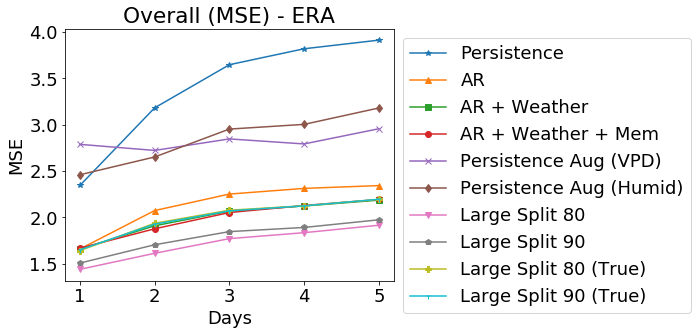

In [82]:
plt.rcParams['figure.figsize'] = [32,5]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

results_dict = {'Persistence': results_persistence,
                'AR': results_ar, 
                #'Weather': results_weather_era,
                'AR + Weather': results_ar_weather_era,
                'AR + Weather + Mem': results_all_era,
                'Persistence Aug (VPD)': p_vpd,
                'Persistence Aug (Humid)': p_h,
                'Large Split 80': large_split_80,
                'Large Split 90': large_split_90,
                'Large Split 80 (True)': large_split_true_80,
                'Large Split 90 (True)': large_split_true_90,}
measurements = [(r'Overall (MSE) - ERA','root_mean_squared_error', False, False),]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, baseline='Persistence', scale=True, markers=['*', '^', 's', 'o', 'x', 'd', 'v', 'p', 'P', '1'], y_labels = ['MSE', 'MSE SS %'], col_len=1)

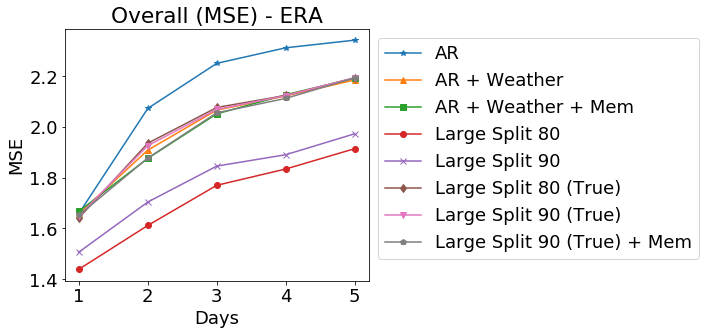

In [86]:
plt.rcParams['figure.figsize'] = [32,5]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

results_dict = {
                'AR': results_ar, 
                #'Weather': results_weather_era,
                'AR + Weather': results_ar_weather_era,
                'AR + Weather + Mem': results_all_era,
                'Large Split 80': large_split_80,
                'Large Split 90': large_split_90,
                'Large Split 80 (True)': large_split_true_80,
                'Large Split 90 (True)': large_split_true_90,
                'Large Split 90 (True) + Mem': large_split_90_true_mem}
measurements = [(r'Overall (MSE) - ERA','root_mean_squared_error', False, False),]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, baseline='Persistence', scale=True, markers=['*', '^', 's', 'o', 'x', 'd', 'v', 'p', 'P', '1'], y_labels = ['MSE', 'MSE SS %'], col_len=1)

In [246]:
fire = np.reshape(np.array(X_grid_dict_nw[1]['num_det']), (33,55,-1))

In [38]:
print(results_all['test']['root_mean_squared_error'][1][0]**2)
print(results_all_era['test']['root_mean_squared_error'][1][0]**2)

2.00704254027
1.9779387012


In [278]:
pred = results_joint_poisson_ar_w_models[1][1].model.predict(X_grid_dict_nw[1])


In [279]:
np.shape(pred)

(1996500,)

Persistence MSE: 12370.600000
Poisson MSE: 7921.750577


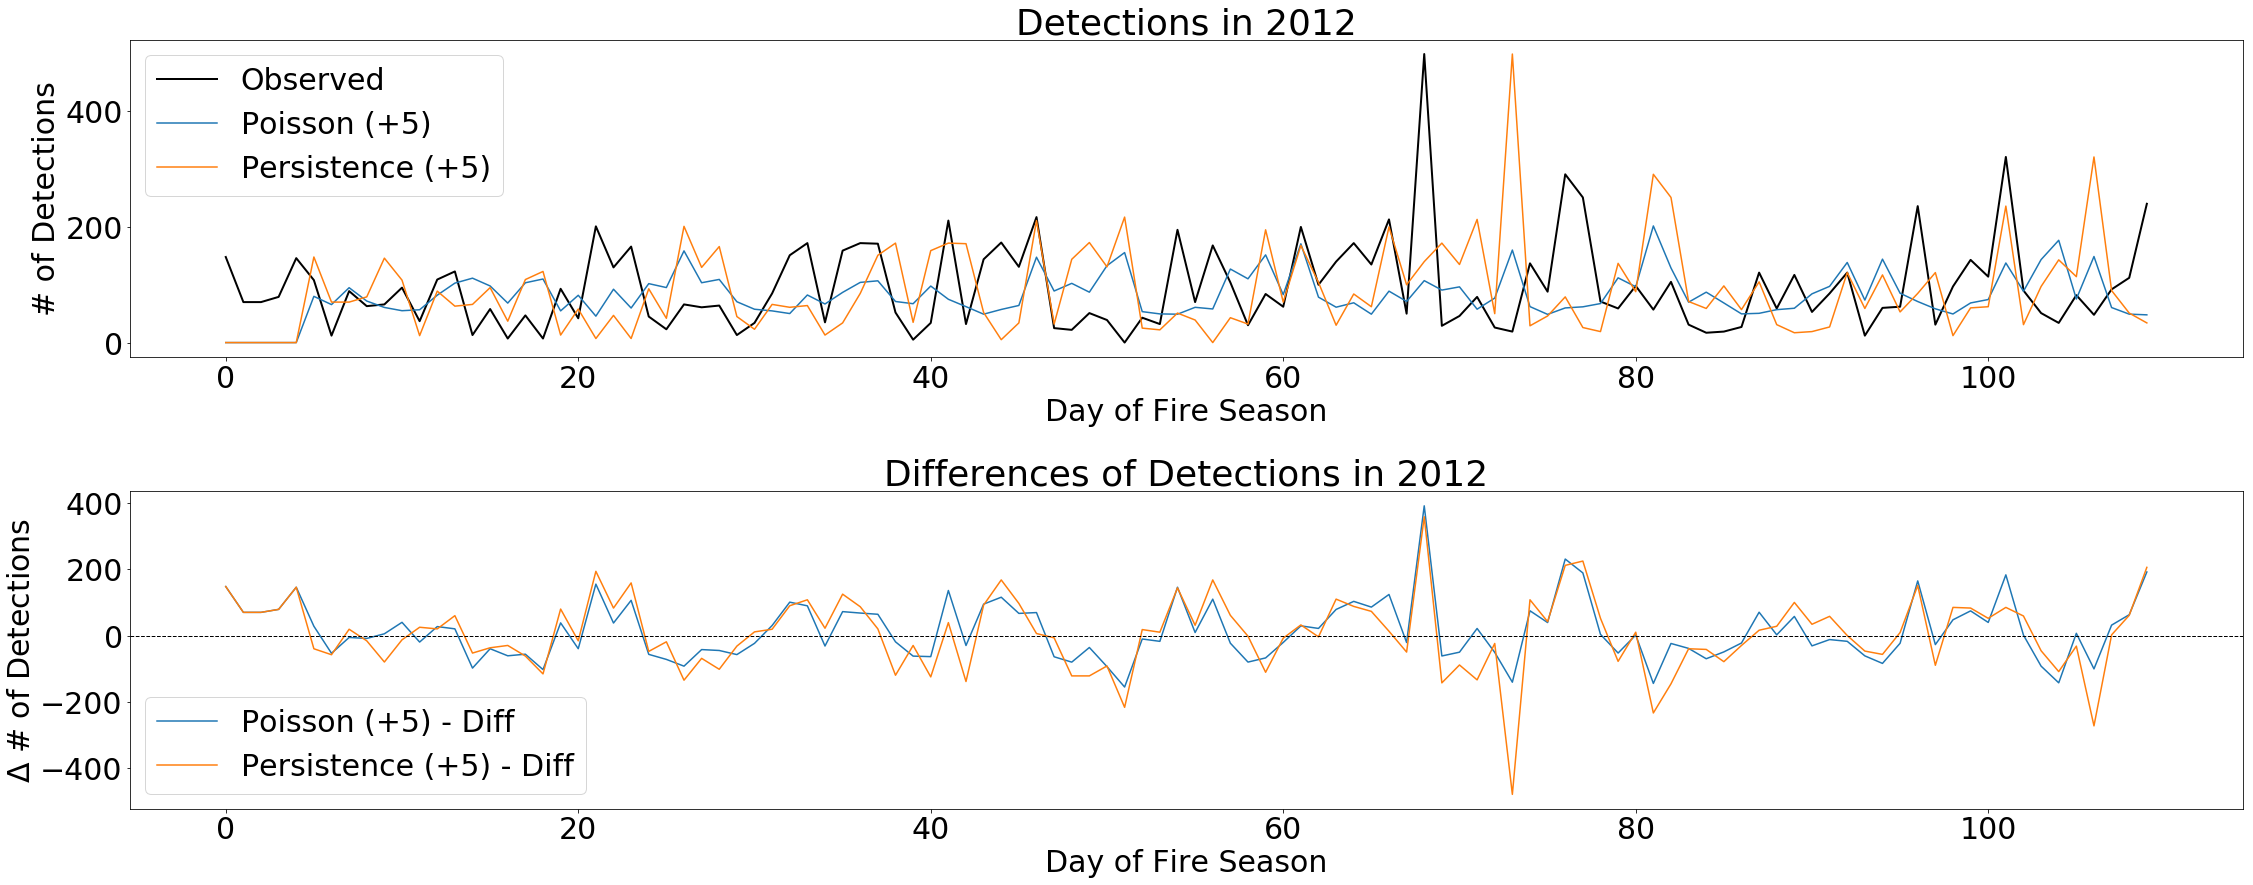

In [363]:
plt.rcParams['figure.figsize'] = [32,13]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 30}

plt.rc('font', **font)

fig = plt.figure()
ax = fig.add_subplot(2,1,1)

fire_days = np.sum(fire, axis=(0,1))
YEAR = 2012
T_K = 5
pred = results_joint_poisson_ar_w_models[T_K-1][1].model.predict(X_grid_dict_nw[T_K])
pred = np.reshape(np.array(pred), (33,55,-1))
pred = np.sum(pred, axis=(0,1))
start_ind = 0+110*(YEAR-2007)
end_ind = 110*(1+(YEAR-2007))
plt.plot(fire_days[start_ind:end_ind], color='black', linewidth=2.0, label='Observed')
plt.plot(np.array(np.concatenate([[0]*T_K,pred[start_ind:end_ind-T_K]])), label='Poisson (+%d)' % T_K)

diff1 = fire_days[start_ind:end_ind] - np.array(np.concatenate([[0]*T_K,pred[start_ind:end_ind-T_K]]))



plt.plot(np.array(np.concatenate([[0]*T_K,fire_days[start_ind:end_ind-T_K]])), label='Persistence (+%d)' % T_K)
diff_persit = fire_days[start_ind:end_ind] - np.array(np.concatenate([[0]*T_K,fire_days[start_ind:end_ind-T_K]]))

plt.xlabel('Day of Fire Season')
plt.ylabel('# of Detections')
plt.legend()
plt.title('Detections in %d'% YEAR)


ax = fig.add_subplot(2,1,2)

plt.plot(diff1, label='Poisson (+%d) - Diff' % (T_K))
plt.plot(diff_persit, label='Persistence (+%d) - Diff' % (T_K))
#plt.plot(diff2, label='Poisson (+%d) - Diff' % (T_K+1))
#plt.plot(diff3, label='Poisson (+%d) - Diff' % (T_K+2))

plt.axhline(linewidth=1, linestyle='--', color='black')


plt.xlabel('Day of Fire Season')
plt.ylabel('$\Delta$ # of Detections')
plt.legend()
plt.title('Differences of Detections in %d'% YEAR)

print('Persistence MSE: %f' % (np.mean(diff_persit**2)))
print('Poisson MSE: %f' % (np.mean(diff1**2)))


fig.tight_layout()

Poisson (+1) MSE: 9811.276835
Poisson (+2) MSE: 9224.883968


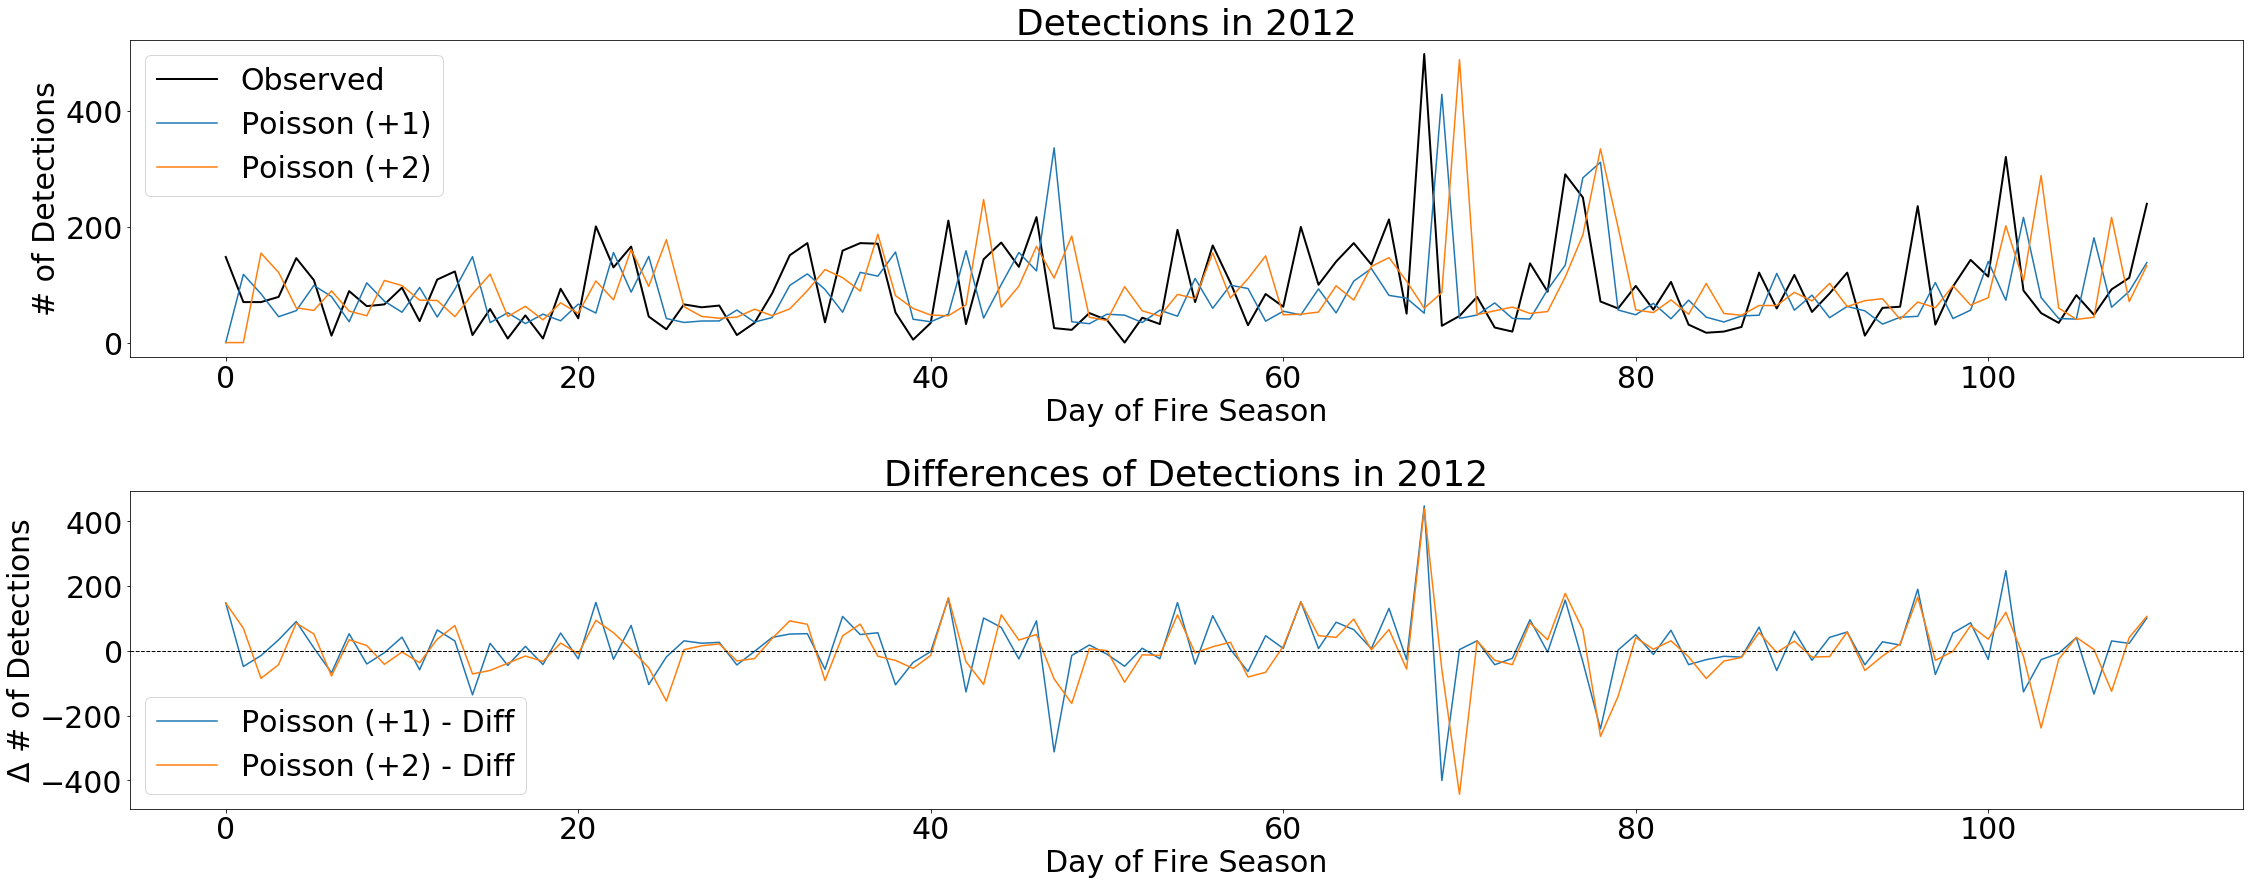

In [328]:
plt.rcParams['figure.figsize'] = [32,13]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 30}

plt.rc('font', **font)

fig = plt.figure()
ax = fig.add_subplot(2,1,1)

fire_days = np.sum(fire, axis=(0,1))
YEAR = 2012
T_K = 1
pred = results_joint_poisson_ar_w_models[T_K-1][1].model.predict(X_grid_dict_nw[T_K])
pred = np.reshape(np.array(pred), (33,55,-1))
pred = np.sum(pred, axis=(0,1))
start_ind = 0+110*(YEAR-2007)
end_ind = 110*(1+(YEAR-2007))
plt.plot(fire_days[start_ind:end_ind], color='black', linewidth=2.0, label='Observed')
plt.plot(np.array(np.concatenate([[0]*T_K,pred[start_ind:end_ind-T_K]])), label='Poisson (+%d)' % T_K)

diff1 = fire_days[start_ind:end_ind] - np.array(np.concatenate([[0]*T_K,pred[start_ind:end_ind-T_K]]))

pred = results_joint_poisson_ar_w_models[T_K][1].model.predict(X_grid_dict_nw[T_K+1])
pred = np.reshape(np.array(pred), (33,55,-1))
pred = np.sum(pred, axis=(0,1))
start_ind = 0+110*(YEAR-2007)
end_ind = 110*(1+(YEAR-2007))
plt.plot(np.array(np.concatenate([[0]*(T_K+1),pred[start_ind:end_ind-(T_K+1)]])), label='Poisson (+%d)' % (T_K+1))

diff2 = fire_days[start_ind:end_ind] - np.array(np.concatenate([[0]*(T_K+1),pred[start_ind:end_ind-(T_K+1)]]))


pred = results_joint_poisson_ar_w_models[T_K+1][1].model.predict(X_grid_dict_nw[T_K+2])
pred = np.reshape(np.array(pred), (33,55,-1))
pred = np.sum(pred, axis=(0,1))
start_ind = 0+110*(YEAR-2007)
end_ind = 110*(1+(YEAR-2007))
#plt.plot(np.array(np.concatenate([[0]*(T_K+2),pred[start_ind:end_ind-(T_K+2)]])), label='Poisson (+%d)' % (T_K+2))

diff3 = fire_days[start_ind:end_ind] - np.array(np.concatenate([[0]*(T_K+2),pred[start_ind:end_ind-(T_K+2)]]))

plt.xlabel('Day of Fire Season')
plt.ylabel('# of Detections')
plt.legend()
plt.title('Detections in %d'% YEAR)

#plt.plot(np.array(np.concatenate([[0]*T_K,fire_days[start_ind:end_ind-T_K]])), label='Persistence (+%d)' % T_K)

ax = fig.add_subplot(2,1,2)

plt.plot(diff1, label='Poisson (+%d) - Diff' % (T_K))
plt.plot(diff2, label='Poisson (+%d) - Diff' % (T_K+1))
#plt.plot(diff3, label='Poisson (+%d) - Diff' % (T_K+2))

plt.axhline(linewidth=1, linestyle='--', color='black')


plt.xlabel('Day of Fire Season')
plt.ylabel('$\Delta$ # of Detections')
plt.legend()
plt.title('Differences of Detections in %d'% YEAR)


print('Poisson (+%d) MSE: %f' % (T_K, np.mean(diff1**2)))
print('Poisson (+%d) MSE: %f' % ((T_K+1), np.mean(diff2**2)))
fig.tight_layout()

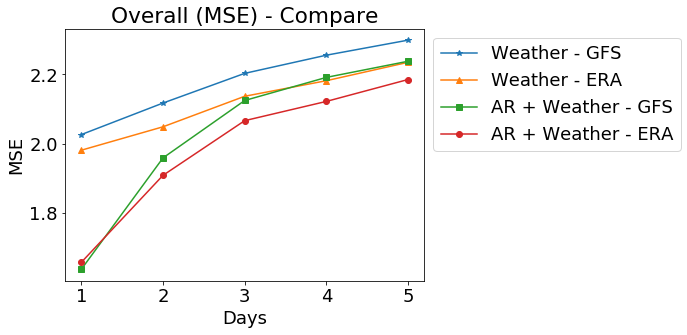

In [29]:
plt.rcParams['figure.figsize'] = [32,5]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

results_dict = {
                'Weather - GFS': results_weather,
                'Weather - ERA': results_weather_era,
                'AR + Weather - GFS': results_ar_weather,
                'AR + Weather - ERA': results_ar_weather_era}
measurements = [(r'Overall (MSE) - Compare','root_mean_squared_error', False, False),]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, baseline='Persistence', scale=True, markers=['*', '^', 's', 'o', 'x', 'd'], y_labels = ['MSE', 'MSE SS %'], col_len=1)

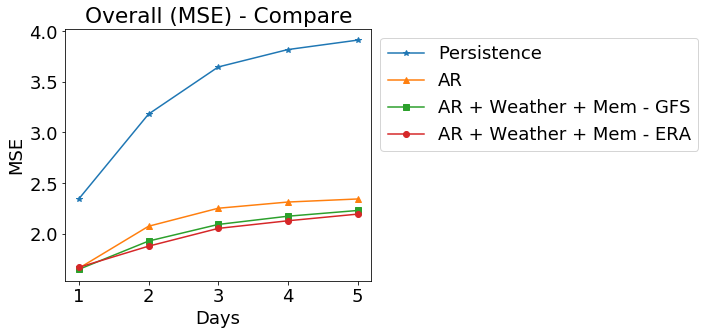

In [28]:
plt.rcParams['figure.figsize'] = [32,5]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

results_dict = {'Persistence': results_persistence,
                'AR': results_ar, 
                'AR + Weather + Mem - GFS': results_all,
                'AR + Weather + Mem - ERA': results_all_era}
measurements = [(r'Overall (MSE) - Compare','root_mean_squared_error', False, False),]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, baseline='Persistence', scale=True, markers=['*', '^', 's', 'o', 'x', 'd'], y_labels = ['MSE', 'MSE SS %'], col_len=1)

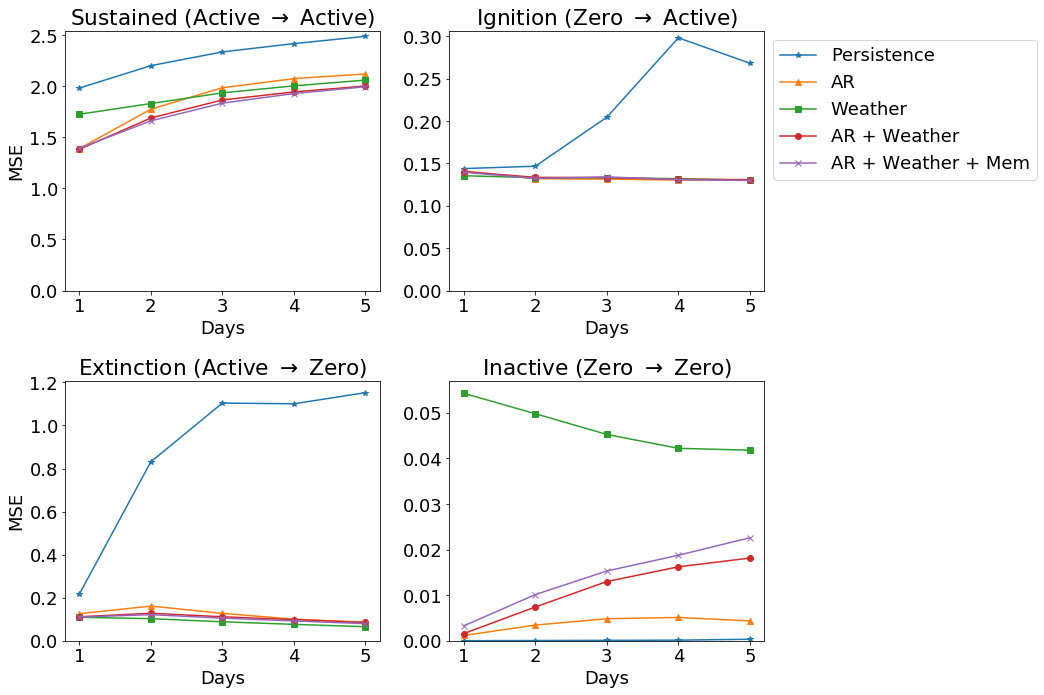

In [39]:
plt.rcParams['figure.figsize'] = [15,10]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

results_dict = {'Persistence': results_persistence,
                'AR': results_ar, 
                'Weather': results_weather,
                'AR + Weather': results_ar_weather,
                'AR + Weather + Mem': results_all}
measurements = [(r'Sustained (Active $\rightarrow$ Active)','root_mean_squared_error_active_target', False, False),
                (r'Ignition (Zero $\rightarrow$ Active)', 'root_mean_squared_error_ignition_target', False, False),
                (r'Extinction (Active $\rightarrow$ Zero)','root_mean_squared_error_extinction_target', False, False),
                (r'Inactive (Zero $\rightarrow$ Zero)','root_mean_squared_error_zero_zero_target', False, False)]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, scale=True, markers=['*', '^', 's', 'o', 'x'], min_y=0)

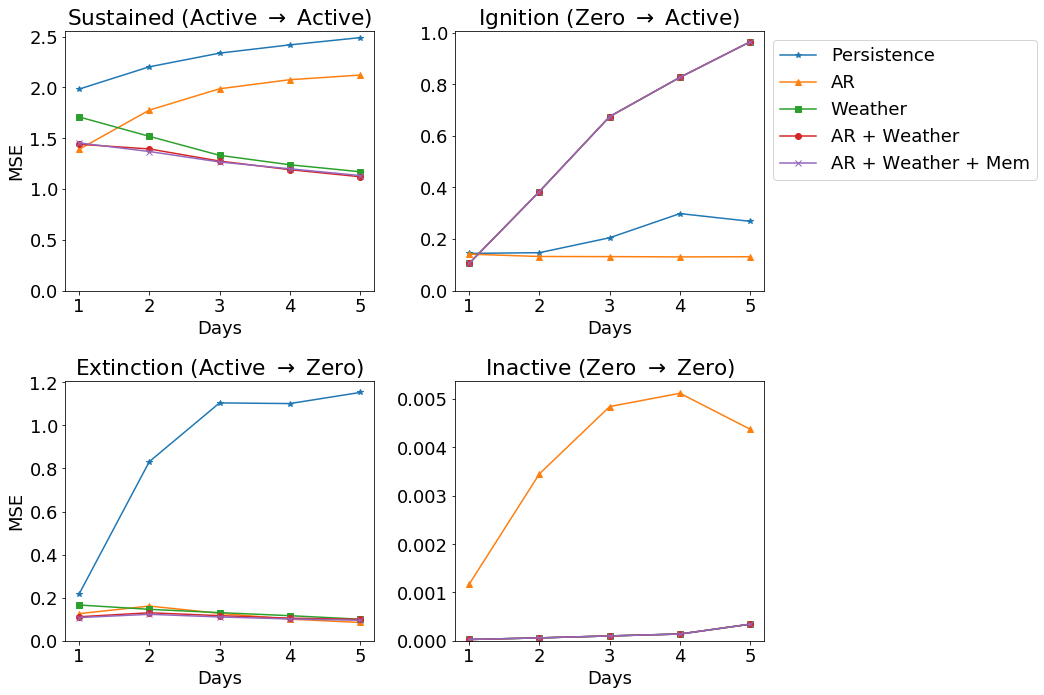

In [40]:
plt.rcParams['figure.figsize'] = [15,10]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

results_dict = {'Persistence': results_persistence,
                'AR': results_ar, 
                'Weather': results_weather_era,
                'AR + Weather': results_ar_weather_era,
                'AR + Weather + Mem': results_all_era}
measurements = [(r'Sustained (Active $\rightarrow$ Active)','root_mean_squared_error_active_target', False, False),
                (r'Ignition (Zero $\rightarrow$ Active)', 'root_mean_squared_error_ignition_target', False, False),
                (r'Extinction (Active $\rightarrow$ Zero)','root_mean_squared_error_extinction_target', False, False),
                (r'Inactive (Zero $\rightarrow$ Zero)','root_mean_squared_error_zero_zero_target', False, False)]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, scale=True, markers=['*', '^', 's', 'o', 'x'], min_y=0)

In [1917]:
results_joint_poisson_ar_weather_norm_model[1][0].afm.model.fit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         num_det_target   No. Observations:                 9122
Model:                            GLM   Df Residuals:                     9116
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -82287.
Date:                Mon, 20 Aug 2018   Deviance:                   1.5009e+05
Time:                        10:26:14   Pearson chi2:                 2.71e+05
No. Iterations:                     7   Covariance Type:             nonrobust
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.3457      0.007    197.801      0.000       1.332       1.359
temperature     0.1663      0.006     29.792      0.000       0.155       0.177
humidity       -0.5124      0.006    -79.023      0.000      -0.525      -0.500
rain           -0.5256      0.013    -39.478      0.000      -0.552      -0.499
wind           -0.2784      0.005    -59.324      0.000      -0.288      -0.269
num_det         0.6151      0.004    153.094      0.000       0.607       0.623
===============================================================================
"""

In [1913]:
results_joint_poisson_ar_weather_model[1][2].model.fit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         num_det_target   No. Observations:              1796850
Model:                            GLM   Df Residuals:                  1796844
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.6993e+05
Date:                Mon, 20 Aug 2018   Deviance:                   5.1531e+05
Time:                        10:25:56   Pearson chi2:                 1.33e+07
No. Iterations:                     8   Covariance Type:             nonrobust
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                               -32.0814      0.293   -109.537      0.000     -32.655     -31.507
temperature                               0.1150      0.001    117.281      0.000       0.113       0.117
humidity                                 -0.0396      0.000   -131.495      0.000      -0.040      -0.039
rain                                     -0.0728      0.003    -27.285      0.000      -0.078      -0.068
wind                                     -0.3161      0.003   -112.425      0.000      -0.322      -0.311
np.log(np.maximum(num_det, 0.500000))     1.1474      0.002    714.575      0.000       1.144       1.151
=========================================================================================================
"""

In [1895]:
results_joint_poisson_weather_model[1][0].model.fit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         num_det_target   No. Observations:              1796850
Model:                            GLM   Df Residuals:                  1796845
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.3106e+05
Date:                Mon, 20 Aug 2018   Deviance:                   8.3757e+05
Time:                        09:32:40   Pearson chi2:                 3.28e+07
No. Iterations:                    10   Covariance Type:             nonrobust
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -53.4012      0.297   -179.719      0.000     -53.984     -52.819
temperature     0.1897      0.001    191.858      0.000       0.188       0.192
humidity       -0.0453      0.000   -146.653      0.000      -0.046      -0.045
rain           -0.0581      0.003    -21.859      0.000      -0.063      -0.053
wind           -0.3657      0.003   -132.399      0.000      -0.371      -0.360
===============================================================================
"""

In [277]:
results_joint_poisson_ar_w_models[1][1].model.predict(X_grid_dict_nw[1])

time        x   y 
2007-05-14  0   0     0.000341
                1     0.000309
                2     0.000275
                3     0.000311
                4     0.000556
                5     0.000936
                6     0.001234
                7     0.001128
                8     0.000944
                9     0.001053
                10    0.000826
                11    0.000658
                12    0.000680
                13    0.000621
                14    0.000611
                15    0.000545
                16    0.000464
                17    0.000542
                18    0.000844
                19    0.000874
                20    0.000644
                21    0.000681
                22    0.000326
                23    0.000282
                24    0.000369
                25    0.000456
                26    0.000408
                27    0.000350
                28    0.000317
                29    0.000337
                        ...   
2016-08-31  54  3   

In [276]:
len(results_joint_poisson_ar_w_models[0])

10

In [1866]:
results_joint_poisson_model[1][4].model.fit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         num_det_target   No. Observations:              1796850
Model:                            GLM   Df Residuals:                  1796844
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.6993e+05
Date:                Tue, 14 Aug 2018   Deviance:                   5.1531e+05
Time:                        21:12:34   Pearson chi2:                 1.33e+07
No. Iterations:                     8   Covariance Type:             nonrobust
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                               -32.0814      0.293   -109.537      0.000     -32.655     -31.507
temperature                               0.1150      0.001    117.281      0.000       0.113       0.117
humidity                                 -0.0396      0.000   -131.495      0.000      -0.040      -0.039
rain                                     -0.0728      0.003    -27.285      0.000      -0.078      -0.068
wind                                     -0.3161      0.003   -112.425      0.000      -0.322      -0.311
np.log(np.maximum(num_det, 0.500000))     1.1474      0.002    714.575      0.000       1.144       1.151
=========================================================================================================
"""

In [1863]:
results_joint_poisson_weather_model[1][0].model.fit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         num_det_target   No. Observations:              1796850
Model:                            GLM   Df Residuals:                  1796845
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.3106e+05
Date:                Tue, 14 Aug 2018   Deviance:                   8.3757e+05
Time:                        21:12:24   Pearson chi2:                 3.28e+07
No. Iterations:                    10   Covariance Type:             nonrobust
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -53.4012      0.297   -179.719      0.000     -53.984     -52.819
temperature     0.1897      0.001    191.858      0.000       0.188       0.192
humidity       -0.0453      0.000   -146.653      0.000      -0.046      -0.045
rain           -0.0581      0.003    -21.859      0.000      -0.063      -0.053
wind           -0.3657      0.003   -132.399      0.000      -0.371      -0.360
===============================================================================
"""

### Comparing Coeffecients

In [2230]:
import tabulate

def print_coeff(models, unit_change=False, fmt=None):
    header = ['Model'] + list(models[0][1].params.index)
    params = []
    
    for i,h in enumerate(header):
        if h == 'np.log(np.maximum(num_det, 0.500000))':
            header[i] = 'num_det'
        if h == 'np.log(np.maximum(num_det_expon, 0.500000))':
            header[i] = 'num_det_expon'
            
    for name,m,exp in models:
        param = m.params.copy()
        if name == 'Poisson - Ignition':
            print(param)
            param[0] = param[0] + param[-1]
            print(np.log(.5), param[-1], np.log(.5) * param[-1], param[0] - np.log(.5) * param[-1], param[0]+param[-1])
            param = param[:-1]
        if unit_change:
            if exp=='exp':
                param_c = np.exp(param[1:]+param[0])/np.exp(0+param[0])
                param = [np.exp(param[0])] + list(param_c)
            elif exp=='lin':
                pass
            else:
                param_c = scipy.special.expit(1*param[1:]+param[0])/scipy.special.expit(0*param[1:]+param[0])
                param = [scipy.special.expit(param[0])] + list(param_c)

        params.append([name]+list(np.round(param, 3)))
        
    print(tabulate.tabulate(params, headers=header, tablefmt=fmt))

In [2122]:
# 203689848777140016917329873323950803670
# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/153720846362400442122411054569788761961.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_active_hurdle_ar_w = saved['summary_results']
results_active_hurdle_ar_w_models = saved['models']
print(saved['params'])

not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in depth 2
not in depth 3
not in dep

In [2133]:


# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/72884963519692473971895292397254769627.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
temp = saved['summary_results']
temp_models = saved['models']
print(saved['params'])

not in depth 2
not in depth 3
{'model_structure': 'grid', 'separated_ignitions': 'separated', 'active_model_type': 'hurdle_p', 'ignition_model_type': 'poisson', 'covariates': ('temperature', 'humidity', 'rain', 'wind'), 'ignition_covariates_exclude': ('num_det',), 'memory_type': 'none', 'memory_covariates': ('temperature', 'humidity', 'rain'), 'memory_log_covariates': ('num_det',), 'memory_length': 10, 'decay_method': 'fixed', 'decay_values': <FrozenOrderedDict OrderedDict([('default', 0.05), ('num_det', 0.05), ('temperature', 0.25), ('humidity', 0.5), ('rain', 0.25)])>, 'forecast_method': 'separate', 'active_check_days': 2, 'regularization_weight': None, 'log_correction_type': 'max', 'log_correction_constant': 0.5, 'log_covariates': ('num_det',), 'fill_method': 'integrate_interp', 'resolution': '4', 'region': 'alaska', 'forecast_horizon': 1, 'normalize_params': True}


In [2135]:
temp_models[0][cv].igm.model.fit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         num_det_target   No. Observations:              1787728
Model:                            GLM   Df Residuals:                  1787723
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -66161.
Date:                Mon, 20 Aug 2018   Deviance:                   1.2618e+05
Time:                        13:09:23   Pearson chi2:                 1.59e+07
No. Iterations:                    11   Covariance Type:             nonrobust
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -6.7129      0.023   -298.220      0.000      -6.757      -6.669
temperature     1.2171      0.014     88.837      0.000       1.190       1.244
humidity       -0.4260      0.012    -35.832      0.000      -0.449      -0.403
rain           -0.1961      0.027     -7.322      0.000      -0.249      -0.144
wind           -0.9980      0.020    -50.104      0.000      -1.037      -0.959
===============================================================================
"""

In [2095]:

# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/52992343311060398433359771272697493123.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_active_poisson_ar_w_norm = saved['summary_results']
results_active_poisson_ar_w_norm_models = saved['models']
print(saved['params'])

{'model_structure': 'grid', 'separated_ignitions': 'active_only', 'active_model_type': 'poisson', 'ignition_model_type': 'poisson', 'covariates': ('temperature', 'humidity', 'rain', 'wind'), 'ignition_covariates_exclude': (), 'memory_type': 'none', 'memory_covariates': ('temperature', 'humidity', 'rain'), 'memory_log_covariates': ('num_det',), 'memory_length': 10, 'decay_method': 'fixed', 'decay_values': <FrozenOrderedDict OrderedDict([('default', 0.05), ('num_det', 0.05), ('temperature', 0.25), ('humidity', 0.5), ('rain', 0.25)])>, 'forecast_method': 'separate', 'active_check_days': 2, 'regularization_weight': None, 'log_correction_type': 'max', 'log_correction_constant': 0.5, 'log_covariates': ('num_det',), 'fill_method': 'integrate_interp', 'resolution': '4', 'region': 'alaska', 'forecast_horizon': 5, 'normalize_params': True}


In [2226]:
cv = 0
print_coeff([('Hurdle - Active', results_active_hurdle_ar_w_models[0][cv].afm.model.fit_result_positive, True),
            ('Hurdle - Zero', results_active_hurdle_ar_w_models[0][cv].afm.model.fit_result_inflated, False),
            ('Poisson - Ignition', results_active_hurdle_ar_w_models[0][cv].igm.model.fit_result, True)], unit_change=False)

Intercept     -3.356471
temperature    1.217076
humidity      -0.425962
rain          -0.196071
wind          -0.998028
num_det       -3.356471
dtype: float64
-0.69314718056 -3.35647148822 2.32652874869 -9.03947172513 -10.0694144647
Model                 Intercept    temperature    humidity     rain     wind    num_det
------------------  -----------  -------------  ----------  -------  -------  ---------
Hurdle - Active          2.1992         0.0585     -0.1398  -0.0333  -0.1147     0.6366
Hurdle - Zero            0.0335        -0.087       0.4212   0.0754   0.244     -1.1071
Poisson - Ignition      -6.7129         1.2171     -0.426   -0.1961  -0.998


In [2101]:
print_coeff([('Poisson - Active', results_active_poisson_ar_w_norm_models[0][cv].afm.model.fit_result, True)], unit_change=False)

Model               Intercept    temperature    humidity     rain     wind    num_det
----------------  -----------  -------------  ----------  -------  -------  ---------
Poisson - Active       1.5537          0.059     -0.2685  -0.0878  -0.2028     0.9041


In [2231]:
print_coeff([('Hurdle - Active', results_active_hurdle_ar_w_models[0][cv].afm.model.fit_result_positive, 'exp'),
            ('Hurdle - Zero', results_active_hurdle_ar_w_models[0][cv].afm.model.fit_result_inflated, 'logit'),
            ('Poisson - Ignition', results_active_hurdle_ar_w_models[0][cv].igm.model.fit_result, 'exp')], unit_change=True, fmt='latex')

Intercept     -3.356471
temperature    1.217076
humidity      -0.425962
rain          -0.196071
wind          -0.998028
num_det       -3.356471
dtype: float64
-0.69314718056 -3.35647148822 2.32652874869 -9.03947172513 -10.0694144647
\begin{tabular}{lrrrrrr}
\hline
 Model              &   Intercept &   temperature &   humidity &   rain &   wind &   num\_det \\
\hline
 Hurdle - Active    &       9.018 &         1.06  &      0.87  &  0.967 &  0.892 &     1.89  \\
 Hurdle - Zero      &       0.508 &         0.957 &      1.203 &  1.037 &  1.119 &     0.501 \\
 Poisson - Ignition &       0.001 &         3.377 &      0.653 &  0.822 &  0.369 &           \\
\hline
\end{tabular}


In [2131]:
print_coeff([('Poisson - Active', results_active_poisson_ar_w_norm_models[0][cv].afm.model.fit_result, True)], unit_change=True)

Model               Intercept    temperature    humidity    rain    wind    num_det
----------------  -----------  -------------  ----------  ------  ------  ---------
Poisson - Active       4.7292         1.0607      0.7645   0.916  0.8165     2.4698


In [2335]:
act_models = [('Hurdle - Active (k==%d)' % i, results_active_hurdle_ar_w_models[i-1][cv].afm.model.fit_result_positive, True) for i in range(1,6)]
zero_models = [('Hurdle - Zero (k==%d)' % i, results_active_hurdle_ar_w_models[i-1][cv].afm.model.fit_result_inflated, False) for i in range(1,6)]

print_coeff(act_models + zero_models, fmt='latex')

\begin{tabular}{lrrrrrr}
\hline
 Model                  &   Intercept &   temperature &   humidity &   rain &   wind &   num\_det \\
\hline
 Hurdle - Active (k==1) &       2.199 &         0.059 &     -0.14  & -0.033 & -0.115 &     0.637 \\
 Hurdle - Active (k==2) &       2.32  &         0.123 &     -0.257 & -0.21  & -0.158 &     0.381 \\
 Hurdle - Active (k==3) &       2.338 &         0.15  &     -0.26  & -0.29  & -0.162 &     0.27  \\
 Hurdle - Active (k==4) &       2.346 &         0.134 &     -0.314 & -0.249 & -0.157 &     0.214 \\
 Hurdle - Active (k==5) &       2.285 &         0.112 &     -0.325 & -0.283 & -0.147 &     0.239 \\
 Hurdle - Zero (k==1)   &       0.033 &        -0.087 &      0.421 &  0.075 &  0.244 &    -1.107 \\
 Hurdle - Zero (k==2)   &       0.591 &        -0.107 &      0.659 &  0.428 &  0.278 &    -0.675 \\
 Hurdle - Zero (k==3)   &       0.986 &        -0.19  &      0.692 &  0.573 &  0.32  &    -0.571 \\
 Hurdle - Zero (k==4)   &       1.26  &        -0.326 &     

In [2104]:
act_models = [('Poisson - Active (k==%d)' % i, results_active_poisson_ar_w_norm_models[i-1][cv].afm.model.fit_result, True) for i in range(1,6)]
print_coeff(act_models)

Model                      Intercept    temperature    humidity     rain     wind    num_det
-----------------------  -----------  -------------  ----------  -------  -------  ---------
Poisson - Active (k==1)       1.5537         0.059      -0.2685  -0.0878  -0.2028     0.9041
Poisson - Active (k==2)       1.3457         0.1663     -0.5124  -0.5256  -0.2784     0.6151
Poisson - Active (k==3)       1.1015         0.2368     -0.5831  -0.7147  -0.3089     0.5062
Poisson - Active (k==4)       0.9103         0.3065     -0.6445  -0.7134  -0.3206     0.4613
Poisson - Active (k==5)       0.725          0.3201     -0.6638  -0.7445  -0.3201     0.4865


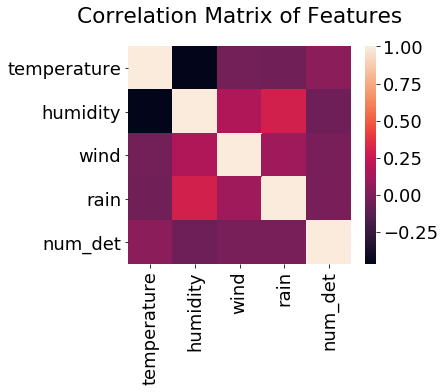

In [2312]:
plt.rcParams['figure.figsize'] = [5,4]

import matplotlib.pyplot as plt

import seaborn as sns
corr = X_grid_dict_nw[1][['temperature', 'humidity', 'wind', 'rain', 'num_det']].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
_ = plt.title('Correlation Matrix of Features', y=1.08)

In [2053]:
# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/327952630274473079428310939073343195108.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_joint_poisson_w = saved['summary_results']
results_joint_poisson_w_models = saved['models']
print(saved['params'])

{'model_structure': 'grid', 'separated_ignitions': 'unified', 'active_model_type': 'poisson', 'ignition_model_type': 'poisson', 'covariates': ('temperature', 'humidity', 'rain', 'wind'), 'ignition_covariates_exclude': (), 'memory_type': 'none', 'memory_covariates': ('temperature', 'humidity', 'rain'), 'memory_log_covariates': ('num_det',), 'memory_length': 10, 'decay_method': 'fixed', 'decay_values': <FrozenOrderedDict OrderedDict([('default', 0.05), ('num_det', 0.05), ('temperature', 0.25), ('humidity', 0.5), ('rain', 0.25)])>, 'forecast_method': 'separate', 'active_check_days': 2, 'regularization_weight': None, 'log_correction_type': 'max', 'log_correction_constant': 0.5, 'log_covariates': (), 'fill_method': 'integrate_interp', 'resolution': '4', 'region': 'alaska', 'forecast_horizon': 5, 'normalize_params': True}


In [268]:
%%capture

# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/239885816095561194487866455682174676337.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_joint_poisson_ar_w = saved['summary_results']
results_joint_poisson_ar_w_models = saved['models']
print(saved['params'])

In [2069]:
%%capture

# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/129611347732043612554359778939566953227.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_joint_linear_w = saved['summary_results']
results_joint_linear_w_models = saved['models']
print(saved['params'])

In [2079]:
%%capture

# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/45680718278070059629106344671526626397.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_joint_linear_ar_w = saved['summary_results']
results_joint_linear_ar_w_models = saved['models']
print(saved['params'])

In [2171]:
%%capture
# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/157010037221392699827506335360373792389.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_zeros = saved['summary_results']
results_zeros_model = saved['models']
print(saved['params'])

In [2152]:

%%capture

# Load results
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/297672648479240516459260716907566454847.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
results_log = saved['summary_results']
results_log_model = saved['models']
print(saved['params'])

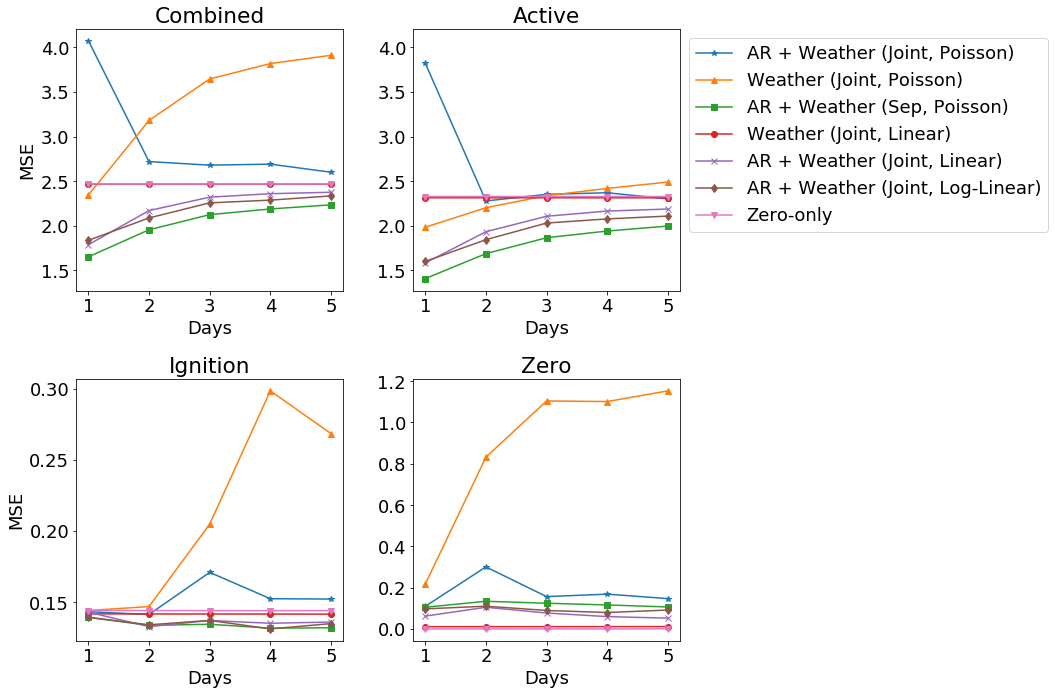

In [2173]:
plt.rcParams['figure.figsize'] = [15,10]
#'AR + Weather (Joint, Linear)': results_poisson_true
results_dict = {'AR + Weather (Joint, Poisson)': results_joint_poisson_ar_w, 'Weather (Joint, Poisson)': results_persistence, 'AR + Weather (Sep, Poisson)': results_poisson_true,
               'Weather (Joint, Linear)': results_joint_linear_w, 'AR + Weather (Joint, Linear)': results_joint_linear_ar_w, 'AR + Weather (Joint, Log-Linear)': results_log, 'Zero-only': results_zeros}
measurements = [('Combined','root_mean_squared_error', True), ('Active','root_mean_squared_error_active_target', True),
                ('Ignition', 'root_mean_squared_error_ignition_target', False), ('Zero','root_mean_squared_error_zero_target', False)]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, scale=True, markers=['*', '^', 's', 'o', 'x', 'd', 'v'])

In [ ]:
plt.rcParams['figure.figsize'] = [15,10]
#'AR + Weather (Joint, Linear)': results_poisson_true
results_dict = {'AR + Weather (Joint, Poisson)': results_joint_poisson_ar_w, 'Weather (Joint, Poisson)': results_persistence, 'AR + Weather (Sep, Poisson)': results_poisson_true,
               'Weather (Joint, Linear)': results_joint_linear_w, 'AR + Weather (Joint, Linear)': results_joint_linear_ar_w, 'AR + Weather (Joint, Log-Linear)': results_log}
measurements = [('Active','root_mean_squared_error_active_target', False), ('Ignition', 'root_mean_squared_error_ignition_target', False), ('Zero','root_mean_squared_error_zero_target', False), ('Extinction','root_mean_squared_error_zero_target', False)]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, scale=True, markers=['*', '^', 's', 'o', 'x', 'd', 'v'])

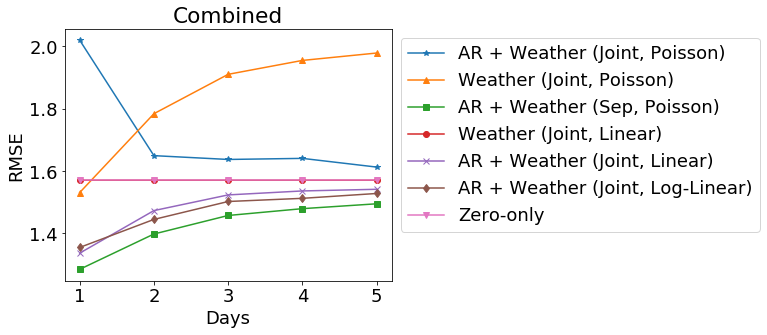

In [2175]:
plt.rcParams['figure.figsize'] = [15,5]
#'AR + Weather (Joint, Linear)': results_poisson_true
results_dict = {'AR + Weather (Joint, Poisson)': results_joint_poisson_ar_w, 'Weather (Joint, Poisson)': results_persistence, 'AR + Weather (Sep, Poisson)': results_poisson_true,
               'Weather (Joint, Linear)': results_joint_linear_w, 'AR + Weather (Joint, Linear)': results_joint_linear_ar_w, 'AR + Weather (Joint, Log-Linear)': results_log, 'Zero-only': results_zeros}
measurements = [('Combined','root_mean_squared_error', True)]
alpha = 0.0049727
plot_active_ignition(results_dict, measurements, scale=False, markers=['*', '^', 's', 'o', 'x', 'd', 'v'])

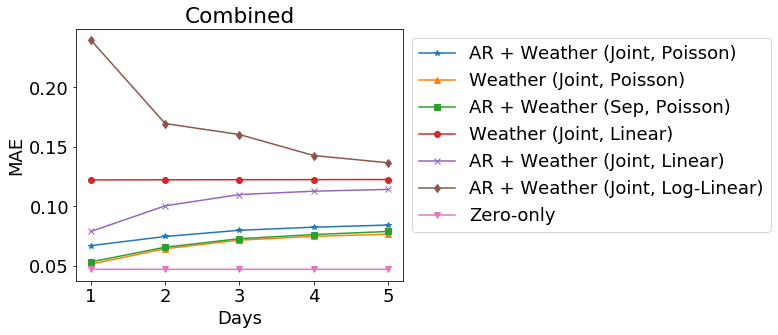

In [2176]:
plt.rcParams['figure.figsize'] = [15,5]
#'
results_dict = {'AR + Weather (Joint, Poisson)': results_joint_poisson_ar_w, 'Weather (Joint, Poisson)': results_persistence, 'AR + Weather (Sep, Poisson)': results_poisson_true,
                'Weather (Joint, Linear)': results_joint_linear_w, 'AR + Weather (Joint, Linear)': results_joint_linear_ar_w, 'AR + Weather (Joint, Log-Linear)': results_log, 'Zero-only': results_zeros}
#measurements = [('Combined','mean_absolute_error', True), ('Active','mean_absolute_error_active_target', False),
#                ('Ignition', 'mean_absolute_error_ignition_target', False), ('Zero','mean_absolute_error_zero_target', False)]
measurements = [('Combined','mean_absolute_error', True)]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, scale=False, markers=['*', '^', 's', 'o', 'x', 'd', 'v'], label='MAE')

In [2157]:
print_coeff([('AR + Weather (Joint, Poisson)', results_joint_poisson_ar_w_models[0][0].model.fit_result, 'exp'),
             ('Weather (Joint, Poisson)', results_joint_poisson_w_models[0][0].model.fit_result, 'exp'),
            ('AR + Weather (Joint, Linear)', results_joint_linear_ar_w_models[0][0].model.fit_result, 'lin'),
            ('Weather (Joint, Linear)', results_joint_linear_w_models[0][0].model.fit_result, 'lin'),
            ('AR + Weather (Joint, Log-Linear)', results_log_model[0][0].model.fit_result, 'exp'),], unit_change=False)

Model                               Intercept    temperature    humidity     rain     wind    num_det
--------------------------------  -----------  -------------  ----------  -------  -------  ---------
AR + Weather (Joint, Poisson)         -4.7869         0.5153     -0.4171  -0.3694  -0.8807     0.2142
Weather (Joint, Poisson)              -5.1224         1.3406     -0.5773  -0.5276  -0.9893
AR + Weather (Joint, Linear)           0.0498         0.0243     -0.0259  -0.0001  -0.0107     0.8581
Weather (Joint, Linear)                0.0498         0.054      -0.0556  -0.001   -0.0179
AR + Weather (Joint, Log-Linear)      -1.7776         0.0721     -0.2324  -0.4243  -0.4106     0.146


In [2160]:
print_coeff([('AR + Weather (Joint, Poisson)', results_joint_poisson_ar_w_models[0][0].model.fit_result, 'exp'),
             ('Weather (Joint, Poisson)', results_joint_poisson_w_models[0][0].model.fit_result, 'exp'),
            ('AR + Weather (Joint, Linear)', results_joint_linear_ar_w_models[0][0].model.fit_result, 'lin'),
            ('Weather (Joint, Linear)', results_joint_linear_w_models[0][0].model.fit_result, 'lin'),
            ('AR + Weather (Joint, Log-Linear)', results_log_model[0][0].model.fit_result, 'exp'),], unit_change=True)

Model                               Intercept    temperature    humidity     rain     wind    num_det
--------------------------------  -----------  -------------  ----------  -------  -------  ---------
AR + Weather (Joint, Poisson)          0.0083         1.6742      0.659    0.6911   0.4145     1.2389
Weather (Joint, Poisson)               0.006          3.8214      0.5614   0.59     0.3719
AR + Weather (Joint, Linear)           0.0498         0.0243     -0.0259  -0.0001  -0.0107     0.8581
Weather (Joint, Linear)                0.0498         0.054      -0.0556  -0.001   -0.0179
AR + Weather (Joint, Log-Linear)       0.169          1.0747      0.7927   0.6542   0.6633     1.1572


In [ ]:
def compute_calibration_plot(results):
    y, y_hat = map(lambda x: x.flatten().copy(), results)
    bins = list(range(0,10)) + list(range(10,100,10)) + [np.max([y,y_hat])]
    if np.any(y_hat<0):
        bins = [round(np.min(y_hat),2)] + bins
    y_hist, _ = np.histogram(y, bins=bins)
    y_hat_hist, _ = np.histogram(y_hat, bins=bins)
    print(np.sqrt(np.mean(np.square(y-y_hat))))
    print(np.any(y_hat<0), np.sum(y>90))
    
    diff=plt.bar(range(len(y_hist)), 
             height=(y_hat_hist-y_hist), edgecolor='black',
             linewidth=1.2, color='red',width=1) 
    """
    diff=plt.bar(range(len(y_hist)), 
             height=(np.log(y_hist)), edgecolor='black',
             linewidth=1.2, color='red',width=1) 
    diff=plt.bar(range(len(y_hist)), 
             height=(-np.log(y_hat_hist)), edgecolor='black',
             linewidth=1.2, color='blue',width=1) 
    """
    plt.xticks(np.array(list(range(len(y_hist))))-.5,bins)

In [2309]:
def generate_hist_natural(df, inputs, scaled=False):
    fig = plt.figure()
    
    for i,var in enumerate(inputs):
        ax = fig.add_subplot(len(inputs)//3 + 1, 3, i+1)
        data = df[var]
        plt.title(var.replace('_', ' ').capitalize())
        if var == 'num_det':
            data = np.log(np.maximum(.5,data[df.active]))
            plt.title('Num Det (Active) - Log/Max Transformed')
            
        if var == 'humidity':
            data = data[data>1]
            
        std = np.std(data)
        f = np.abs(data - np.mean(data)) < std*3
        data = data[f]
        
        if scaled:
            data = (data - np.mean(data))/np.std(data)
            
        plt.hist(data, bins=100, density=True)

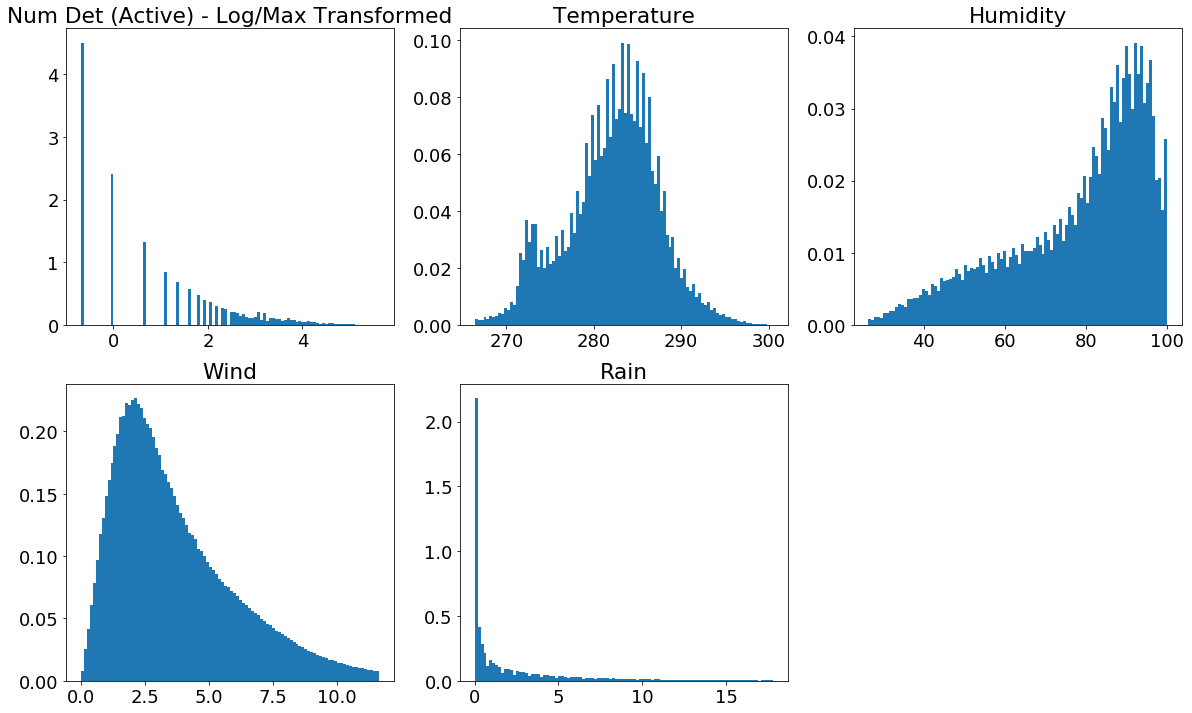

In [2307]:
plt.rcParams['figure.figsize'] = [20,12]

generate_hist_natural(X_grid_dict_nw[1], ['num_det', 'temperature', 'humidity', 'wind', 'rain'])

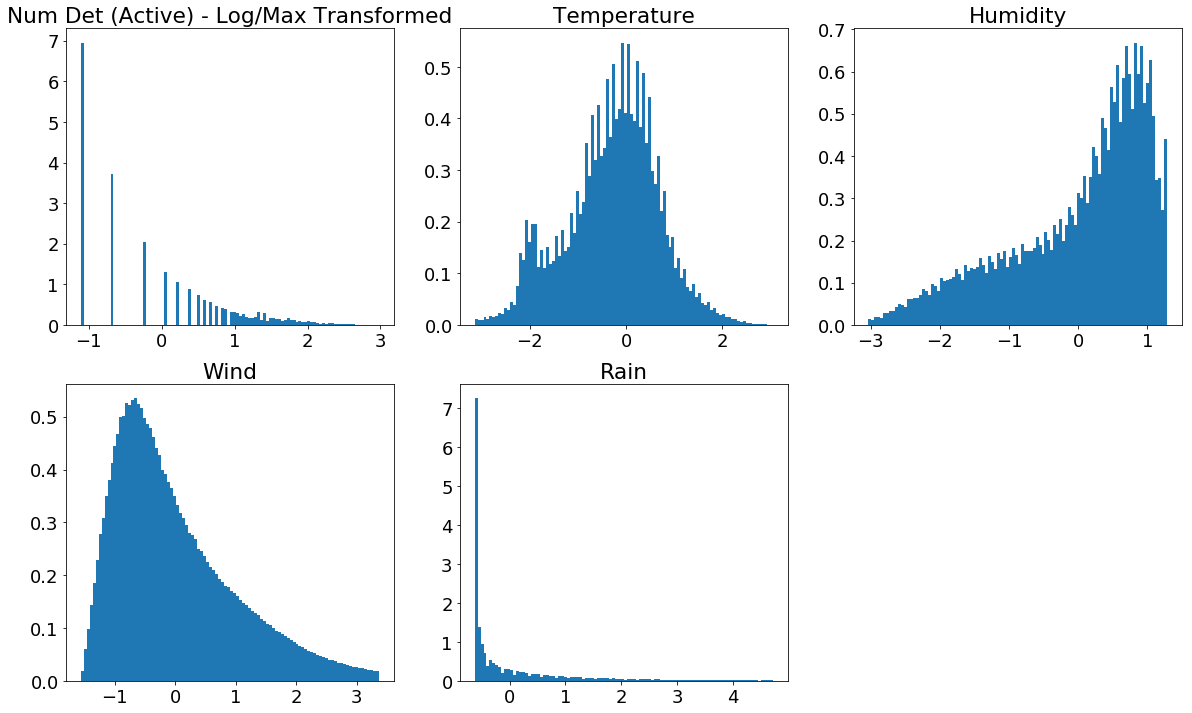

In [2310]:
generate_hist_natural(X_grid_dict_nw[1], ['num_det', 'temperature', 'humidity', 'wind', 'rain'], True)

In [340]:
data =

In [342]:
X_grid_dict_nw

{1:                   num_det  num_det_target  active  temperature   humidity  \
 time       x  y                                                             
 2007-05-14 0  0       0.0             0.0   False   263.799988  93.000000   
               1       0.0             0.0   False   264.500000  92.000000   
               2       0.0             0.0   False   265.100006  92.000000   
               3       0.0             0.0   False   265.899994  92.000000   
               4       0.0             0.0   False   266.500000  92.000000   
               5       0.0             0.0   False   268.600006  95.000000   
               6       0.0             0.0   False   270.500000  91.000000   
               7       0.0             0.0   False   269.500000  88.000000   
               8       0.0             0.0   False   269.399994  88.000000   
               9       0.0             0.0   False   269.100006  90.000000   
               10      0.0             0.0   False   267.5000

In [344]:
models_hurdle_dict[1]


In [14]:
from helper.multidata_wrapper import MultidataWrapper
df = X_grid_dict_nw[1]
data = MultidataWrapper((df,df))
pred, rem = models_hurdle_dict[1].predict(data, choice='all')


In [71]:
data_out =  xr.open_dataset('/lv_scratch/scratch/graffc0/fire_prediction/data/processed/grid/grid_ds_gfs_4_modis_alaska_2007-01-01_2016-12-31_integrate_interp_0roff_1k.nc')

In [65]:
data[0].to_csv('data_out.csv')

In [75]:
print(list(data[0]))

['num_det', 'num_det_target', 'active', 'temperature', 'humidity', 'wind', 'rain', 'in_filled', 'interpolated', 'vpd', 'temperature_1', 'temperature_2', 'temperature_3', 'temperature_4', 'temperature_5', 'temperature_6', 'temperature_7', 'temperature_8', 'temperature_9', 'temperature_10', 'temperature_expon', 'humidity_1', 'humidity_2', 'humidity_3', 'humidity_4', 'humidity_5', 'humidity_6', 'humidity_7', 'humidity_8', 'humidity_9', 'humidity_10', 'humidity_expon', 'rain_1', 'rain_2', 'rain_3', 'rain_4', 'rain_5', 'rain_6', 'rain_7', 'rain_8', 'rain_9', 'rain_10', 'rain_expon', 'wind_1', 'wind_2', 'wind_3', 'wind_4', 'wind_5', 'wind_6', 'wind_7', 'wind_8', 'wind_9', 'wind_10', 'wind_expon', 'num_det_1', 'num_det_2', 'num_det_3', 'num_det_4', 'num_det_5', 'num_det_6', 'num_det_7', 'num_det_8', 'num_det_9', 'num_det_10', 'num_det_expon', 'ignition']


In [97]:
temp = ['temperature_%d' % i for i in range(5,11)]
num_det = ['num_det_%d' % i for i in range(5,11)]
humidity = ['humidity_%d' % i for i in range(5,11)]
wind = ['wind_%d' % i for i in range(5,11)]
rain = ['rain_%d' % i for i in range(5,11)]

drop =['vpd', 'ignition', 'num_det_expon', 'temperature_expon', 'humidity_expon', 'wind_expon', 'rain_expon'] + temp + num_det + humidity + wind + rain

In [98]:
data_out2 = data[0].drop(drop, axis=1)

In [99]:
print(list(data_out2))

['num_det', 'num_det_target', 'active', 'temperature', 'humidity', 'wind', 'rain', 'in_filled', 'interpolated', 'temperature_1', 'temperature_2', 'temperature_3', 'temperature_4', 'humidity_1', 'humidity_2', 'humidity_3', 'humidity_4', 'rain_1', 'rain_2', 'rain_3', 'rain_4', 'wind_1', 'wind_2', 'wind_3', 'wind_4', 'num_det_1', 'num_det_2', 'num_det_3', 'num_det_4']


In [108]:
data

num_det                 0
num_det_target          0
active              False
temperature         268.9
humidity               90
wind              4.96488
rain                    0
in_filled               0
interpolated            0
temperature_1       263.8
temperature_2       262.1
temperature_3       265.1
temperature_4       263.8
humidity_1             93
humidity_2             98
humidity_3             88
humidity_4             91
rain_1                  0
rain_2                0.3
rain_3                0.4
rain_4                0.2
wind_1            4.38292
wind_2            2.61725
wind_3            5.06063
wind_4              4.531
num_det_1               0
num_det_2               0
num_det_3               0
num_det_4               0
Name: (2007-05-15 00:00:00, 0, 0), dtype: object

In [111]:
data_out2.iloc[0]

num_det                 0
num_det_target          0
active              False
temperature         263.8
humidity               93
wind              4.38292
rain                    0
in_filled               0
interpolated            0
temperature_1       262.1
temperature_2       265.1
temperature_3       263.8
temperature_4       260.5
humidity_1             98
humidity_2             88
humidity_3             91
humidity_4             99
rain_1                0.3
rain_2                0.4
rain_3                0.2
rain_4                0.1
wind_1            2.61725
wind_2            5.06063
wind_3              4.531
wind_4            2.86007
num_det_1               0
num_det_2               0
num_det_3               0
num_det_4               0
Name: (2007-05-14 00:00:00, 0, 0), dtype: object

In [109]:
data_out2.to_csv('data_out2.csv')

In [35]:
rem[0][:10]

((time        x   y 
  2007-05-14  0   0     0.984752
                  1     0.988826
                  2     0.987169
                  3     0.986667
                  4     0.992110
                  5     0.985566
                  6     0.995322
                  7     0.998590
                  8     0.998525
                  9     0.997602
                  10    0.985912
                  11    0.984778
                  12    0.988573
                  13    0.999472
                  14    0.999340
                  15    0.997454
                  16    0.998940
                  17    0.999662
                  18    0.999912
                  19    0.999893
                  20    0.999858
                  21    0.999912
                  22    0.999845
                  23    0.999907
                  24    0.999932
                  25    0.999908
                  26    0.999835
                  27    0.999640
                  28    0.999323
                  29  

In [44]:
rem[1][0][:10] * rem[0][0]

ValueError: operands could not be broadcast together with shapes (10,) (2,1996500) 

In [69]:
rem[1][0][data[0].active.values].mean()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1996499 but corresponding boolean dimension is 1996500

In [ ]:
import helper.date_util as du
from evaluation.setup_data_structs import get_weather_variables

def extract_per_day(ds):
    dates = np.array(list(map(lambda x: pd.Timestamp(x).to_pydatetime().date(), ds.time.values)))
    vals = defaultdict(list)
    for date in dates:
        time =14
        dt.datetime.combine(date, dt.time(time, 0, 0, tzinfo=du.TrulyLocalTzInfo(153, du.round_to_nearest_quarter_hour)))
        get_weather_variables_nw(vals, X, weather_dates, target_datetime, ['temperature','humidity','wind_speed','precipitation_24hr', 'vpd', 'in_filled', 'interpolated'])
        for k,v in vals.items():
            vals[k] = np.rollaxis(np.array(v), 0, 3)
            
        return vals
                
                

In [108]:
import evaluation.setup_data_structs as sds
fn_weather = '/lv_scratch/scratch/graffc0/fire_prediction/data/interim/gfs/grid/era_4_alaska_20070101_20161231_interpolate_grid_0roff.nc'
weather_grid = xr.open_dataset(fn_weather)

fn_fire = '/lv_scratch/scratch/graffc0/fire_prediction/data/interim/modis/fire_grid/fire_grid_mcd14ml_006_200701_201612_alaska_alaska_20070101_20161201.nc'
fire_grid = xr.open_dataset(fn_fire)

In [109]:
ds = sds.build_x_grid_nw(weather_grid, fire_grid, None, [0], list(range(2007,2017)))

T_k=0


In [110]:
import evaluation.setup_data_structs as sds
reload(sds)

<module 'evaluation.setup_data_structs' from '/home/graffc/Documents/dev/fire_prediction/src/evaluation/setup_data_structs.py'>

In [111]:
ds[0].temperature[0,0,1].values, ds[0].time[1].values

(array(243.1278533935547, dtype=float32),
 numpy.datetime64('2007-01-02T00:00:00.000000000'))

In [112]:
grid_ds.temperature[5,0,0].values,grid_ds.time[5].values

NameError: name 'grid_ds' is not defined

In [ ]:
grid_ds

In [114]:
ds_out = ds[0].drop(['vpd','active','num_det_target'])

In [115]:
ds_out['active'] = (('y','x','time'), ds[0]['active'].values.astype(int))

In [119]:
ds_out_filter = filter_fire_season(ds_out, start=(5,14), end=(8,31))
df_out = ds_out_filter.to_dataframe().reset_index()

In [120]:
df_out['year'] = df_out['time'].dt.year
df_out['month'] = df_out['time'].dt.month
df_out['day'] = df_out['time'].dt.day

In [121]:
cols = list(df_out)[:-3]
cols = ['year', 'month', 'day'] + cols
df_out = df_out.ix[:, cols]

/home/graffc/miniconda3/envs/fire_pred/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [122]:
from helper.date_util import filter_fire_season
df_out.drop('time', inplace=True, axis=1)

In [123]:
df_out

year  month  day   x   y  num_det  temperature   humidity       wind  \
0        2007      5   14   0   0      0.0   263.840424  80.343712   1.756564   
1        2007      5   14   0   1      0.0   263.662567  79.143394   1.392864   
2        2007      5   14   0   2      0.0   263.814392  77.976181   3.066642   
3        2007      5   14   0   3      0.0   263.973572  77.697357   4.752205   
4        2007      5   14   0   4      0.0   264.140137  78.294952   6.082440   
5        2007      5   14   0   5      0.0   264.840240  78.578423   6.531318   
6        2007      5   14   0   6      0.0   266.039154  76.560661   6.520236   
7        2007      5   14   0   7      0.0   267.736908  72.487602   6.099427   
8        2007      5   14   0   8      0.0   268.456940  70.823387   5.676750   
9        2007      5   14   0   9      0.0   268.734558  66.382103   5.065982   
10       2007      5   14   0  10      0.0   268.569733  59.609264   4.228525   
11       2007      5   14   0  11      0.0   268.732819  61.770695   4.143560   
12       2007      5   14   0  12      0.0   269.751282  63.207653   4.497199   
13       2007      5   14   0  13      0.0   271.625153  63.864704   5.321960   
14       2007      5   14   0  14      0.0   271.740540  66.725632   5.882761   
15       2007      5   14   0  15      0.0   271.561829  69.053238   6.466235   
16       2007      5   14   0  16      0.0   271.089020  70.806175   7.073619   
17       2007      5   14   0  17      0.0   271.707550  66.211227   7.371820   
18       2007      5   14   0  18      0.0   271.862396  65.250031   8.207547   
19       2007      5   14   0  19      0.0   271.553558  67.759453   9.582312   
20       2007      5   14   0  20      0.0   271.531006  70.592461  10.365719   
21       2007      5   14   0  21      0.0   272.000793  73.300735  10.970879   
22       2007      5   14   0  22      0.0   272.962860  75.833672  11.398046   
23       2007      5   14   0  23      0.0   273.610901  73.912827  11.723927   
24       2007      5   14   0  24      0.0   273.877686  73.288811  11.681888   
25       2007      5   14   0  25      0.0   273.763153  73.918526  11.277876   
26       2007      5   14   0  26      0.0   273.493347  74.789543  10.823504   
27       2007      5   14   0  27      0.0   273.329834  75.301025  10.491746   
28       2007      5   14   0  28      0.0   273.272552  75.443520  10.279495   
29       2007      5   14   0  29      0.0   273.437378  73.785774  10.279401   
...       ...    ...  ...  ..  ..      ...          ...        ...        ...   
1996470  2016      8   31  54   3      0.0   279.386200  82.512329   7.403245   
1996471  2016      8   31  54   4      0.0   279.631989  78.993134   3.229607   
1996472  2016      8   31  54   5      0.0   279.072021  82.224335   2.109016   
1996473  2016      8   31  54   6      0.0   278.669525  85.039780   1.467436   
1996474  2016      8   31  54   7      0.0   278.424500  87.378609   1.284080   
1996475  2016      8   31  54   8      0.0   278.182526  90.786354   1.376112   
1996476  2016      8   31  54   9      0.0   277.738159  93.774223   1.600105   
1996477  2016      8   31  54  10      0.0   277.091400  96.308418   1.896574   
1996478  2016      8   31  54  11      0.0   276.615936  93.236786   2.059909   
1996479  2016      8   31  54  12      0.0   276.746918  88.001884   2.238022   
1996480  2016      8   31  54  13      0.0   277.484314  81.014832   2.406478   
1996481  2016      8   31  54  14      0.0   279.381592  70.066078   2.529749   
1996482  2016      8   31  54  15      0.0   280.760376  64.048737   2.488089   
1996483  2016      8   31  54  16      0.0   281.620697  61.807327   2.307610   
1996484  2016      8   31  54  17      0.0   280.779602  66.753906   2.389205   
1996485  2016      8   31  54  18      0.0   279.347778  75.508316   2.417684   
1996486  2016      8   31  54  19      0.0   277.325287  89.575653   2.435348   
1996487  2016      8   31  54  20      0

In [124]:
# Load data
from pipeline import train_pipeline 

file_str = '/lv_scratch/scratch/graffc0/fire_prediction/data/processed/grid/grid_ds_gfs_4_modis_alaska_2007-01-01_2016-12-31_integrate_interp_0roff_%dk.nc'
in_files = {k: file_str % k for k in range(1,6)}

start_date = dt.date(2007,1,1)
end_date = dt.date(2016,12,31)

forecast_horizon = 5
params_poisson['memory_covariates']+= ('wind',)
X_grid_dict_nw, y_grid_dict, _, _, _ = train_pipeline.setup_data(in_files, start_date, end_date, forecast_horizon, params_poisson)
X_grid_dict_nw = {k: v[0].to_dataframe() for (k,v) in X_grid_dict_nw.items()}

In [ ]:
# Load models
fn = '/lv_scratch/scratch/graffc0/fire_prediction/experiments/339456281351332664148843495347011284794.pkl'
with open(fn, 'rb') as fin:
    saved = pickle.load(fin)
    
models_test = saved['models']

In [ ]:
df = X_grid_dict_nw[1]
data_in = MultidataWrapper((df,df))
pred = models_test[0][0].predict(data_in,choice='all')
add_pred_info(df_out, pred, 1)

In [ ]:
def add_pred_info(df, pred, t_k):
    df['pred_k=%d' % t_k] = pred[0].values
    
    extinct_prob = np.array(pred[1][0][0].values)
    extinct_prob[df.active==0] = 0
    
    df['extinction_k=%d' % t_k] = extinct_prob
        
    ignition_prob = np.full_like(pred[0].values, 0)
    ignition_prob = 1-scipy.stats.poisson.pmf(0,pred[0])
    ignition_prob[df.active==1] = 0
    
    df['ignition_k=%d' % t_k] = ignition_prob

In [ ]:
df = X_grid_dict_nw[2]
data_in = MultidataWrapper((df,df))
pred = models_test[0][0].predict(data_in,choice='all')
add_pred_info(df_out, pred, 2)

In [ ]:
df = X_grid_dict_nw[3]
data_in = MultidataWrapper((df,df))
pred = models_test[0][0].predict(data_in,choice='all')
add_pred_info(df_out, pred, 3)

In [ ]:
df = X_grid_dict_nw[4]
data_in = MultidataWrapper((df,df))
pred = models_test[0][0].predict(data_in,choice='all')
add_pred_info(df_out, pred, 4)

In [ ]:
df = X_grid_dict_nw[5]
data_in = MultidataWrapper((df,df))
pred = models_test[0][0].predict(data_in,choice='all')
add_pred_info(df_out, pred, 5)

In [ ]:
np.argmax(df_out['ignition_k=1'])

In [ ]:
1-scipy.stats.poisson.pmf(0,0.000019)

In [113]:
df_out.iloc[1825890]

NameError: name 'df_out' is not defined

In [433]:
df_out

year  month  day   x   y  num_det  temperature   humidity       wind  \
0        2007      5   14   0   0      0.0   262.100006  98.000000   2.617250   
1        2007      5   14   0   1      0.0   262.600006  99.000000   2.282542   
2        2007      5   14   0   2      0.0   264.100006  98.000000   1.902630   
3        2007      5   14   0   3      0.0   263.899994  95.000000   3.328663   
4        2007      5   14   0   4      0.0   263.799988  94.000000   4.920366   
5        2007      5   14   0   5      0.0   264.799988  95.000000   5.162364   
6        2007      5   14   0   6      0.0   268.299988  88.000000   5.147815   
7        2007      5   14   0   7      0.0   268.700012  88.000000   4.522168   
8        2007      5   14   0   8      0.0   269.000000  88.000000   4.257934   
9        2007      5   14   0   9      0.0   269.399994  90.000000   4.000000   
10       2007      5   14   0  10      0.0   268.399994  95.000000   4.304649   
11       2007      5   14   0  11      0.0   267.600006  96.000000   4.701064   
12       2007      5   14   0  12      0.0   267.399994  95.000000   4.318565   
13       2007      5   14   0  13      0.0   271.100006  80.000000   5.920304   
14       2007      5   14   0  14      0.0   271.600006  78.000000   6.229767   
15       2007      5   14   0  15      0.0   270.000000  86.000000   5.651548   
16       2007      5   14   0  16      0.0   269.700012  86.000000   6.166036   
17       2007      5   14   0  17      0.0   270.000000  83.000000   6.935416   
18       2007      5   14   0  18      0.0   270.899994  77.000000   7.310951   
19       2007      5   14   0  19      0.0   271.299988  75.000000   7.605919   
20       2007      5   14   0  20      0.0   272.399994  74.000000   8.902246   
21       2007      5   14   0  21      0.0   272.799988  73.000000   9.308599   
22       2007      5   14   0  22      0.0   273.299988  73.000000  10.679420   
23       2007      5   14   0  23      0.0   273.500000  74.000000  11.936499   
24       2007      5   14   0  24      0.0   273.500000  74.000000  12.083873   
25       2007      5   14   0  25      0.0   273.700012  74.000000  11.923925   
26       2007      5   14   0  26      0.0   273.799988  74.000000  11.692733   
27       2007      5   14   0  27      0.0   274.000000  74.000000  11.326517   
28       2007      5   14   0  28      0.0   274.200012  74.000000  11.183022   
29       2007      5   14   0  29      0.0   274.500000  74.000000  11.162885   
...       ...    ...  ...  ..  ..      ...          ...        ...        ...   
1996470  2016      8   31  54   3      0.0   280.300018  80.300003  11.515216   
1996471  2016      8   31  54   4      0.0   279.100006  75.099998   4.817302   
1996472  2016      8   31  54   5      0.0   277.899994  75.700005   2.833513   
1996473  2016      8   31  54   6      0.0   277.600006  78.500000   2.623738   
1996474  2016      8   31  54   7      0.0   276.700012  84.900002   2.313979   
1996475  2016      8   31  54   8      0.0   276.700012  85.500000   1.893066   
1996476  2016      8   31  54   9      0.0   276.600006  87.500000   1.762640   
1996477  2016      8   31  54  10      0.0   275.500000  94.300003   1.862713   
1996478  2016      8   31  54  11      0.0   273.200012  96.700005   1.000900   
1996479  2016      8   31  54  12      0.0   271.600006  94.599998   0.952943   
1996480  2016      8   31  54  13      0.0   270.200012  90.500000   1.694520   
1996481  2016      8   31  54  14      0.0   277.899994  57.600002   2.159282   
1996482  2016      8   31  54  15      0.0   273.899994  87.000000   1.213796   
1996483  2016      8   31  54  16      0.0   274.800018  78.400002   1.029563   
1996484  2016      8   31  54  17      0.0   272.100006  90.200005   1.418238   
1996485  2016      8   31  54  18      0.0   274.399994  82.099998   1.268227   
1996486  2016      8   31  54  19      0.0   274.300018  91.900002   1.405845   
1996487  2016      8   31  54  20      0

In [432]:
df_out.to_csv('data_out.csv')

In [61]:
diff_80 = np.array([0.15816747087037791, 0.09401809090221401, 0.15312708053680379, 0.072731007142731174, 0.12783571416145914, 0.20897871000852747, 0.15282886013705879, 0.14308815918219336, 0.15351708822899454, 0.1038069284693643, 0.15360677724448002, 0.086053834879081401, 0.15779270889874375, 0.11573060449346403, 0.15273459853296953, 0.058454350311545028, 0.13541965599579334, 0.17660196324793317, 0.15530286101116714, 0.089230152946626132, 0.1678892802016507, 0.083607564426381162, 0.16156775735413817, 0.069973707743574892, 0.13394346905878488, 0.22652605392862207, 0.16279815469669026, 0.1365464995066871, 0.16238683585851837, 0.099479174666509365, 0.16226552420962931, 0.080784110973009582, 0.16558348778820764, 0.12503425384455563, 0.16106021017106351, 0.051576708833855761, 0.14227012556464599, 0.18920145137184352, 0.1626956058822536, 0.11128386446684242, 0.17052600997882975, 0.078731228272208617, 0.16343576075566649, 0.073270106108866376, 0.13397006545402601, 0.2348683773355332, 0.16486181372621672, 0.13225035893331069, 0.16495414331673269, 0.086437709145723129, 0.16440163416900952, 0.081003459950700643, 0.16822995714248429, 0.12887564715663768, 0.16298033753154437, 0.049246910050208002, 0.14243261661994933, 0.19439349589239599, 0.16526125472376021, 0.10486290773915267, 0.16377236609363774, 0.080377283980811801, 0.15727574520859927, 0.063092368696128359, 0.12488627340424985, 0.23487081385877259, 0.15820660243944029, 0.12378701467475166, 0.15868102266972264, 0.080401385538641165, 0.15809247865290904, 0.073274847738730775, 0.16170257209693284, 0.12395568779901711, 0.15659454173346526, 0.042116097277584599, 0.13678569361509715, 0.19061459611429024, 0.16042781870790784, 0.069233558343444052, 0.15712635195560895, 0.071110184134140372, 0.15023020594373643, 0.055663763283204451, 0.11281768394016847, 0.23620900438046957, 0.15054382540256461, 0.11842064798815072, 0.15146445155214336, 0.076199875548850826, 0.15089959170805015, 0.0649090952237735, 0.15357134982887496, 0.11928440254106724, 0.14927879705280253, 0.039553702735981161, 0.13418251192390199, 0.17874894921899548, 0.15373820994113491, 0.054236938521956504])
diff_80_in = diff_80[1::2].reshape(5,10)
diff_80_out = diff_80[0::2].reshape(5,10)

In [66]:
diff_50 = np.array([0.25325255126330676, 0.22416488841951962, 0.25043188431782459, 0.2137896286346378, 0.24338096282456781, 0.26499333901741262, 0.24915721193129056, 0.25232805611031639, 0.25028060246605105, 0.23151051817388346, 0.24994812265136646, 0.23643591266991767, 0.25302914404164512, 0.23825606161014676, 0.2516547058679876, 0.14443596518813975, 0.23747823562874562, 0.26587668642219647, 0.25148352417924941, 0.22418164007304811, 0.28748401235446436, 0.22585710335017614, 0.28368803433358242, 0.19627977220678078, 0.26681613674028049, 0.32199713201420566, 0.28153567280632463, 0.27296422894091504, 0.28340075593225394, 0.23365024710100199, 0.28273476723556051, 0.24592633669200545, 0.28471984568613495, 0.26644262278224662, 0.28378770515346041, 0.14229265323304657, 0.26806851253561964, 0.30949637745110892, 0.28340706929037524, 0.25507831131395625, 0.27124714058899368, 0.19440938330281729, 0.26644840271156439, 0.1664257810456207, 0.24327808920508123, 0.32407175288172546, 0.26433090418192962, 0.24862914655000157, 0.26780157852713826, 0.18858902375694167, 0.26601741784103605, 0.20760366970068519, 0.26760524212114434, 0.24469620152623026, 0.26648316361685337, 0.10825128081170451, 0.24628293404203785, 0.30015013568843341, 0.26835766212197532, 0.20391147213222774, 0.24618564891471037, 0.17433380681172947, 0.24185557635256616, 0.13727371575512673, 0.21312510841510876, 0.31114448694060209, 0.23924556423835155, 0.22104393426764279, 0.24298757827623485, 0.16594694869049725, 0.24150906838541297, 0.1742220412116115, 0.24354600667346848, 0.21490973017155485, 0.24177289741647517, 0.080126210452627036, 0.2214989729613368, 0.27932672433335304, 0.24653651487235639, 0.13356226691856407, 0.23049899488703857, 0.15113487643798471, 0.22506939043997207, 0.12316668969520576, 0.19325708130449895, 0.30356776115296552, 0.22248085810690876, 0.20308626833729057, 0.22609627826289092, 0.15175051321390462, 0.22545543873942211, 0.1434683149933722, 0.22655956792646895, 0.19983702408199244, 0.22495815352172541, 0.064347709909439096, 0.20535752738160126, 0.25924957896962769, 0.23057314526620667, 0.10070344961656179])
diff_50_in = diff_50[1::2].reshape(5,10)
diff_50_out = diff_50[0::2].reshape(5,10)

In [73]:
diff_90 = np.array([0.10635058687146783, 0.044760157208103266, 0.10085106969298079, 0.040145291089037242, 0.070877660754187652, 0.16434825418570057, 0.10525855043439411, 0.075691674230687345, 0.10231407817125839, 0.049068902007290902, 0.10175860418101225, 0.038213080873275289, 0.10398458801682293, 0.07104767712163762, 0.10021813363109286, 0.052898412246281432, 0.090537872476663714, 0.11621567073326095, 0.1029048828238016, 0.049106717991479566, 0.10714987817346115, 0.035902727944643109, 0.10144217026701462, 0.033126185312243886, 0.072549486420186354, 0.1679706254365502, 0.10552238030443471, 0.071511125064990244, 0.10269795034900574, 0.047332271414097259, 0.10212008777176899, 0.035521400299843256, 0.10443327153314759, 0.071581570564177632, 0.10049421258701152, 0.046627351129258227, 0.089673866305775354, 0.11869777504687298, 0.1026693457577486, 0.056409964939951415, 0.10688651471016317, 0.031330212321730916, 0.10091188022416625, 0.033400237223702514, 0.072681064135142914, 0.16894114981852834, 0.10505097708302463, 0.064720820602617454, 0.10234359409628349, 0.040156515243462435, 0.10156850863157328, 0.037636156143418587, 0.10353862449798974, 0.076223477719529212, 0.10002235103079529, 0.040006880416738069, 0.08824770895513244, 0.11991163269228146, 0.10248670946480659, 0.052091254777193008, 0.10420825721810142, 0.031826104419509921, 0.098187489263095507, 0.032051013380391409, 0.069397734195893013, 0.16888098237683358, 0.10200907418415302, 0.059410690927227339, 0.099702214859700683, 0.03665304716330748, 0.09890329302344722, 0.035746244660930272, 0.10116113023855534, 0.07464685155865064, 0.097441857523839395, 0.031026582419222029, 0.08484462858964209, 0.12028760715175703, 0.10064693859881463, 0.032355176374880765, 0.10398049910985645, 0.031309619316717961, 0.097824154002243827, 0.033489325216232872, 0.067014240615994897, 0.17043995272259904, 0.10114867605925988, 0.061116373682717551, 0.09943999263058062, 0.035810482259347846, 0.098535922055210348, 0.034726625470587129, 0.10103724770698379, 0.072372569031061929, 0.097122885502521794, 0.028451828688609015, 0.085728707787280437, 0.11972723823563515, 0.10039950409445401, 0.030506985002292])
diff_90_in = diff_90[1::2].reshape(5,10)
diff_90_out = diff_90[0::2].reshape(5,10)

In [74]:
print(np.mean(diff_90_out, axis=1))
print(np.mean(diff_80_out, axis=1))
print(np.mean(diff_50_out, axis=1))


[ 0.0985056   0.09887526  0.09837379  0.09565026  0.09522318]
[ 0.15003328  0.15824605  0.16010536  0.15364251  0.1463853 ]
[ 0.24900969  0.28056425  0.26278525  0.23782629  0.22103064]


array([ 0.09401809,  0.07273101,  0.20897871,  0.14308816,  0.10380693,
        0.08605383,  0.1157306 ,  0.05845435,  0.17660196,  0.08923015])